In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerBase
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import scienceplots
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statannotations.Annotator import Annotator
import itertools
from tqdm import tqdm
from scipy import stats
import textalloc

In [2]:
# paper style
plt.style.use(['science', 'notebook'])
# plt.rcParams.update({'figure.dpi': '150'})

In [3]:
class MultipleRectanglesHandler(HandlerBase):
    def __init__(self, colors):
        self.colors = colors
        super().__init__()

    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # Create as many rectangles as there are colors
        rects = []
        for i, color in enumerate(self.colors):
            rect = Rectangle([x0 + (width / len(self.colors)) * i, y0], 
                                     width / len(self.colors), height, 
                                     facecolor=color, edgecolor=None, 
                                     transform=trans)
            rects.append(rect)
        return rects

In [4]:
# Function to calculate the luminance of a color
def get_luminance(color):
    # Convert color to RGB (assuming it's in hex format if it's a string)
    if isinstance(color, str):
        color = plt.colors.to_rgb(color)  # Converts hex to RGB if necessary
    # Calculate luminance using a formula that accounts for human eye sensitivity
    luminance = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
    return luminance

In [5]:
def make_color_gradient(color1, color2, n):
    # Convert color to RGB (assuming it's in hex format if it's a string)
    if isinstance(color1, str):
        color1 = mcolors.to_rgb(color1)  # Converts hex to RGB if necessary
    if isinstance(color2, str):
        color2 = mcolors.to_rgb(color2)  # Converts hex to RGB if necessary
    # Create a color gradient
    gradient = [color1]
    for i in range(1, n):
        # Calculate the intermediate color
        new_color = [color1[j] + (color2[j] - color1[j]) * i / (n - 1) for j in range(3)]
        gradient.append(new_color + [1])
    return gradient

In [6]:
RG_DATASET_COLOR = 'dodgerblue'
RGID_DATASET_COLOR = 'deepskyblue'
IDRBIND_DATASET_COLOR= 'limegreen'
FUZZY_DATASET_COLOR = 'orange'
SCANIDR_DATASET_COLOR = 'slateblue'
DECOYS_DATASET_COLOR = 'darkgrey'

In [7]:
LIGHT_GREY = mcolors.to_rgba('lightgrey')
CAPRI_COLORS_RG = [LIGHT_GREY] + make_color_gradient('white', RG_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_RGID = [LIGHT_GREY] + make_color_gradient('white', RGID_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_IDRBIND = [LIGHT_GREY] + make_color_gradient('white', IDRBIND_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_FUZZY = [LIGHT_GREY] + make_color_gradient('white', FUZZY_DATASET_COLOR, 5)[-3:]
CAPRI_COLORS_SCANIDR = [LIGHT_GREY] + make_color_gradient('white', SCANIDR_DATASET_COLOR, 5)[-3:]

In [8]:
df_dockq_fuz = pd.read_csv('../data/fuzidp_uniprot_dockq.csv')
df_dockq_fuz_notail = pd.read_csv('../data/fuzidp_uniprot_dockq_no-tails.csv')
df_dockq = pd.merge(
    df_dockq_fuz,
    df_dockq_fuz_notail,
    on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'reference_model'],
    how='outer',
    suffixes=('', '_notail'),
)
# df_fuztoremove = pd.read_csv('../data/fuzidp_to_remove.csv')
# df_dockq = df_dockq[~df_dockq['pdb_id'].isin(df_fuztoremove['pdb_id'])]
# df_dockq_frag = pd.read_csv('../data/fuzidp_uniprot_dockq_fragmented.csv')

df_dockq_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_dockq_recycle.csv')
df_dockq_rg_notail = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_dockq_notails_recycle.csv')
df_dockq_rg = pd.merge(
    df_dockq_rg,
    df_dockq_rg_notail,
    on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'reference_model'],
    how='outer',
    suffixes=('', '_notail'),
)
df_dockq_rgid = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_iface_iupred_disorder_half.csv')
df_dockq_rgid = pd.merge(
    df_dockq_rg,
    df_dockq_rgid,
    on=['pdb_id', 'idp_id', 'receptor_id'],
    how='inner',
)

df_dockq_idrbind = pd.read_csv('../data/idrbind_uniprot_dockq_recycles.csv')
df_dockq_idrbind_notail = pd.read_csv('../data/idrbind_uniprot_dockq_recycles_notails.csv')
df_dockq_idrbind = pd.merge(
    df_dockq_idrbind,
    df_dockq_idrbind_notail,
    on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'reference_model'],
    how='outer',
    suffixes=('', '_notail'),
)

df_dockq = pd.concat([
    df_dockq.assign(exp='delim_idp', dataset='Fuzzy'),
    # df_dockq_frag.assign(exp='fragmented', dataset='Fuzzy'),
    df_dockq_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_dockq_rgid.assign(exp='delim_idp', dataset='Rg', is_disorder=True),
    df_dockq_rg.assign(exp='delim_idp', dataset='Rg'),
], ignore_index=True)
print(df_dockq.shape)
df_dockq.head()

(56200, 67)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,receptor_core_true,receptor_rim_true,buried_surface_area,idp_helices,idp_sheets,receptor_helices,receptor_sheets,idp_iupred_long,receptor_iupred_long,is_disorder
0,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_score_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_scores_recycle.csv')
df_score_rg_decoy = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_scores_fullidp_decoy.csv')
df_score_idrbind = pd.read_csv('../data/idrbind_uniprot_scores_recycles.csv')
df_score_fuzzy = pd.read_csv('../data/fuzidp_uniprot_scores.csv')
# df_score_fuzzy = df_score_fuzzy[~df_score_fuzzy['pdb_id'].isin(df_fuztoremove['pdb_id'])]

df_score = pd.concat([
    df_score_fuzzy.assign(exp='delim_idp', dataset='Fuzzy'),
    df_score_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_score_rg.assign(exp='delim_idp', dataset='Rg'),
    df_score_rg_decoy.assign(exp='delim_idp', dataset='Decoys'),
], ignore_index=True)
print(df_score.shape)
df_score.head()

(2000, 43)


,pdb_id,idp_id,receptor_id,plddt_idp,plddt_receptor,pae_idp_idp_mean,pae_idp_idp_min,pae_idp_idp_max,pae_receptor_receptor_mean,pae_receptor_receptor_min,...,pae_receptor_idp_raw,jobname,rank,model_name,model,seed,exp,dataset,idp_id_af,idp_fragment
0,2LPB,B,A,"[41.34, 41.38, 41.88, 50.88, 48.78, 46.25, 45....","[38.59, 44.19, 56.97, 69.56, 70.69, 76.56, 82....","[19.16441176470588, 17.779117647058825, 16.975...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[30.05, 30.05, 29.95, 29.72, 29.86, 29.55, 28....","[9.326296296296299, 8.465679012345676, 7.38740...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[25.94, 25.67, 24.14, 23.94, 23.33, 23.3, 21....",2LPB_B_A,1,alphafold2_multimer_v2,5,0,delim_idp,Fuzzy,NaN,NaN
1,2LPB,B,A,"[39.16, 43.16, 45.91, 49.41, 50.0, 49.91, 44.2...","[44.59, 44.31, 56.41, 59.81, 67.19, 73.56, 78....","[18.912058823529414, 17.459705882352946, 17.08...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[29.14, 28.95, 29.31, 28.92, 28.56, 28.92, 28....","[9.778518518518519, 9.1, 8.212592592592591, 7....","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[27.0, 26.27, 26.19, 25.53, 24.44, 24.81, 23....",2LPB_B_A,2,alphafold2_multimer_v2,2,0,delim_idp,Fuzzy,NaN,NaN
2,2LPB,B,A,"[38.72, 44.16, 42.03, 47.94, 48.91, 46.06, 43....","[51.84, 53.81, 55.69, 61.53, 66.56, 73.69, 81....","[19.701764705882358, 18.319705882352938, 18.26...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[30.14, 29.38, 30.16, 30.14, 29.91, 29.62, 28....","[8.989259259259258, 8.428024691358027, 7.43938...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[26.06, 25.48, 25.33, 23.97, 23.2, 23.44, 20....",2LPB_B_A,3,alphafold2_multimer_v2,1,0,delim_idp,Fuzzy,NaN,NaN
3,2LPB,B,A,"[43.38, 49.84, 48.78, 50.69, 49.47, 48.0, 45.1...","[49.34, 52.0, 59.09, 63.53, 69.12, 71.56, 77.7...","[19.578529411764706, 18.295882352941174, 17.81...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[28.98, 29.28, 29.3, 29.06, 28.48, 28.08, 27.6...","[9.305308641975309, 8.566296296296299, 7.48234...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[25.53, 25.27, 25.19, 24.06, 22.94, 23.64, 20...",2LPB_B_A,4,alphafold2_multimer_v2,3,0,delim_idp,Fuzzy,NaN,NaN
4,2LPB,B,A,"[44.06, 50.53, 48.12, 53.38, 52.38, 50.38, 46....","[50.03, 50.03, 55.38, 66.44, 71.38, 75.94, 82....","[19.34823529411765, 18.383823529411767, 17.838...","[0.76, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...","[29.52, 29.2, 29.86, 29.11, 29.02, 28.92, 28.9...","[8.89716049382716, 8.08259259259259, 7.4330864...","[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.7...",...,"[[26.86, 26.41, 26.02, 25.06, 24.89, 24.06, 23...",2LPB_B_A,5,alphafold2_multimer_v2,4,0,delim_idp,Fuzzy,NaN,NaN


In [10]:
df_pdist_rg = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_pdistance_recycle.csv')
df_pdist_fuz = pd.read_csv('../data/fuzidp_uniprot_pdistance.csv')
df_pdist_idrbind = pd.read_csv('../data/idrbind_uniprot_pdistance_recycles.csv')
df_pdist_rg_decoy = pd.read_csv('../data/rgidp_dupdrop_clustered_uniprot_pdistance_fullidp_decoy.csv')

df_pdist = pd.concat([
    df_pdist_rg.assign(exp='delim_idp', dataset='Rg'),
    df_pdist_fuz.assign(exp='delim_idp', dataset='Fuzzy'),
    df_pdist_idrbind.assign(exp='delim_idp', dataset='IDRBind'),
    df_pdist_rg_decoy.assign(exp='delim_idp', dataset='Decoys'),
], ignore_index=True)
print(df_pdist.shape)
df_pdist.head()

(9754, 25)


,pdb_id,idp_id,receptor_id,distogram_idp_idp_mean,distogram_idp_idp_min,distogram_idp_idp_max,distogram_receptor_receptor_mean,distogram_receptor_receptor_min,distogram_receptor_receptor_max,distogram_idp_receptor_mean,...,jobname,rank,model_name,model,seed,recycle,exp,dataset,idp_id_af,idp_fragment
0,6C0A,B,A,"[15.329130434782611, 14.937826086956523, 14.38...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.2, 22.19, 22.2, 22.2, 22.19, 22.14, 22.09,...","[18.4056338028169, 18.035211267605632, 17.8847...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.2, 22.2, 22.22, 22.2, 22.19, 22.2, ...","[17.680434782608696, 18.038260869565217, 17.00...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,NaN,delim_idp,Rg,NaN,NaN
1,6C0A,B,A,"[15.263478260869565, 14.93304347826087, 14.388...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.19, 22.19, 22.16, 22.19, 22.17, 22....","[19.282112676056332, 18.584929577464784, 17.58...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.22, 22.2, 22.23, 22.2, 22.19, 22.17, 22.23...","[16.954347826086963, 16.151739130434784, 14.66...",...,6C0A_B_A,2,alphafold2_multimer_v2,4,0,0.0,delim_idp,Rg,NaN,NaN
2,6C0A,B,A,"[15.329130434782611, 14.937826086956523, 14.38...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.2, 22.19, 22.2, 22.2, 22.19, 22.14, 22.09,...","[18.4056338028169, 18.035211267605632, 17.8847...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.2, 22.2, 22.22, 22.2, 22.19, 22.2, ...","[17.680434782608696, 18.038260869565217, 17.00...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,3.0,delim_idp,Rg,NaN,NaN
3,6C0A,B,A,"[15.339565217391305, 14.99130434782609, 14.408...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.19, 22.2, 22.2, 22.16, 22.17, 22.03...","[18.501408450704226, 17.99014084507042, 17.907...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.22, 22.25, 22.19, 22.2, 22.23, 22.23, 22.2...","[18.09478260869565, 18.13608695652174, 17.3386...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,1.0,delim_idp,Rg,NaN,NaN
4,6C0A,B,A,"[15.35521739130435, 14.978695652173913, 14.397...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.2, 22.2, 22.17, 22.17, 22.16, 22.06...","[18.44577464788732, 18.026901408450712, 17.860...","[2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.47, 2.4...","[22.19, 22.19, 22.2, 22.2, 22.22, 22.19, 22.22...","[17.75565217391304, 17.99, 17.014782608695654,...",...,6C0A_B_A,1,alphafold2_multimer_v2,5,0,2.0,delim_idp,Rg,NaN,NaN


In [11]:
df_score['recycle'] = np.nan

In [12]:
df_pred = pd.merge(df_dockq, df_score, on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'exp', 'dataset'], how='outer')
df_pred = pd.merge(df_pred, df_pdist, on=['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'recycle', 'exp', 'dataset'], how='outer')
print(df_pred.shape)
df_pred.head()

(58000, 116)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,distogram_receptor_receptor_max,distogram_idp_receptor_mean,distogram_idp_receptor_min,distogram_idp_receptor_max,distogram_receptor_idp_mean,distogram_receptor_idp_min,distogram_receptor_idp_max,jobname_y,idp_id_af_y,idp_fragment_y
0,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,1.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
1,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,2.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
2,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,3.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
3,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,4.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN
4,2LPB,B,A,False,4,alphafold2_multimer_v2,3,0,NaN,5.0,...,"[22.2, 22.25, 22.2, 22.23, 22.23, 22.23, 22.2,...","[20.8485294117647, 20.389411764705883, 19.7835...","[18.81, 18.11, 16.08, 16.39, 12.78, 12.52, 16....","[22.11, 22.14, 22.06, 22.05, 22.02, 21.78, 21....","[21.54345679012345, 21.499629629629634, 21.357...","[18.02, 17.16, 16.02, 14.49, 12.76, 11.26, 11....","[22.2, 22.2, 22.2, 22.22, 22.2, 22.2, 22.2, 22...",2LPB_B_A,NaN,NaN


In [13]:
df_pred.loc[df_pred['is_disorder'].notna() & df_pred['is_disorder'], 'dataset'] = 'Rg+ID'

In [14]:
# rank per seed
df_pred['seed_rank'] = df_pred.groupby(['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'dataset'], dropna=False)['rank'].rank(method='dense')
print(df_pred['seed_rank'].value_counts())
print(df_pred['seed_rank'].isna().sum())

4.0    11600
3.0    11600
1.0    11600
2.0    11600
5.0    11600
Name: seed_rank, dtype: int64
0


In [15]:
# rank per seed
df_pred['seed_rank_riptm_receptor_max'] = df_pred.groupby(['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'dataset'], dropna=False)['riptm_idp_max'].rank(method='dense', ascending=False)
print(df_pred['seed_rank_riptm_receptor_max'].value_counts())
print(df_pred['seed_rank_riptm_receptor_max'].isna().sum())

1.0    2350
3.0    2323
4.0    2321
2.0    2320
5.0    2286
Name: seed_rank_riptm_receptor_max, dtype: int64
46400


In [16]:
# rank per seed
df_pred['riptm_min_max'] = df_pred[['riptm_receptor_max', 'riptm_idp_max']].min(axis=1)
df_pred['seed_rank_riptm_min_max'] = df_pred.groupby(['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'dataset'], dropna=False)['riptm_min_max'].rank(method='dense', ascending=False)
print(df_pred['seed_rank_riptm_min_max'].value_counts())
print(df_pred['seed_rank_riptm_min_max'].isna().sum())

2.0    2362
3.0    2321
4.0    2321
1.0    2320
5.0    2276
Name: seed_rank_riptm_min_max, dtype: int64
46400


In [17]:
df_pred[['rank', 'seed_rank', 'seed_rank_riptm_receptor_max', 'seed_rank_riptm_min_max']].corr()

,rank,seed_rank,seed_rank_riptm_receptor_max,seed_rank_riptm_min_max
rank,1.000000,1.000000,0.826111,0.696460
seed_rank,1.000000,1.000000,0.826111,0.696460
seed_rank_riptm_receptor_max,0.826111,0.826111,1.000000,0.807307
seed_rank_riptm_min_max,0.696460,0.696460,0.807307,1.000000


In [18]:
CAPRI_CLASSES = ['Incorrect', 'Acceptable', 'Medium', 'High']
def get_capri(fnat, iRMS, LRMS):
    if fnat < 0.1 or (LRMS > 10.0 and iRMS > 4.0):
        return "Incorrect"
    elif (
        (fnat >= 0.1 and fnat < 0.3)
        and (LRMS <= 10.0 or iRMS <= 4.0)
        or (fnat >= 0.3 and LRMS > 5.0 and iRMS > 2.0)
    ):
        return "Acceptable"
    elif (
        (fnat >= 0.3 and fnat < 0.5)
        and (LRMS <= 5.0 or iRMS <= 2.0)
        or (fnat >= 0.5 and LRMS > 1.0 and iRMS > 1.0)
    ):
        return "Medium"
    elif fnat >= 0.5 and (LRMS <= 1.0 or iRMS <= 1.0):
        return "High"
    else:
        return None

def get_capri_dockq(dockq):
    if 0 <= dockq < 0.23:
        return "Incorrect"
    elif dockq < 0.49:
        return "Acceptable"
    elif dockq < 0.8:
        return "Medium"
    elif 0.8 <= dockq <= 1:
        return "High"
    else:
        return None

df_pred['capri'] = df_pred[['fnat', 'irms', 'lrms']].apply(lambda x: get_capri(*x), axis=1)
df_pred['capri_dockq'] = df_pred['dockq'].apply(get_capri_dockq)
df_pred['capri_notail'] = df_pred[['fnat_notail', 'irms_notail', 'lrms_notail']].apply(lambda x: get_capri(*x), axis=1)
df_pred['capri_dockq_notail'] = df_pred['dockq_notail'].apply(get_capri_dockq)
print(df_pred['capri'].value_counts(), df_pred['capri'].isna().sum())
print(df_pred['capri_dockq'].value_counts(), df_pred['capri_dockq'].isna().sum())
print(df_pred['capri_notail'].value_counts(), df_pred['capri_notail'].isna().sum())
print(df_pred['capri_dockq_notail'].value_counts(), df_pred['capri_dockq_notail'].isna().sum())

Incorrect     24310
Acceptable    18150
Medium        12420
High           1320
Name: capri, dtype: int64 1800
Acceptable    22259
Incorrect     16095
Medium        15679
High           2167
Name: capri_dockq, dtype: int64 1800
Medium        20487
Incorrect     17306
Acceptable    14841
High           3066
Name: capri_notail, dtype: int64 2300
Medium        21875
Acceptable    17509
Incorrect     12846
High           3470
Name: capri_dockq_notail, dtype: int64 2300


In [19]:
# scanidr
df_scanidr = pd.read_csv('../data/scanidr_dockq.csv')
df_scanidr_pred = pd.read_csv('../data/scanidr_dockq.csv')
df_scanidr_pred = df_scanidr_pred[['pdb_id', 'seed', 'rank', 'combined', 'seed_rank', 'dockq', 'capri', 'iptm', 'ptm', 'index']]
df_scanidr_pred['dockq_notail'] = df_scanidr_pred['dockq']
df_scanidr_pred['capri_notail'] = df_scanidr_pred['capri']
df_scanidr_pred['capri_dockq'] = df_scanidr_pred['dockq'].apply(get_capri_dockq)
df_scanidr_pred['capri_dockq_notail'] = df_scanidr_pred['dockq_notail'].apply(get_capri_dockq)
df_scanidr_pred['reference_model'] = 1
df_scanidr_pred['seed'] = df_scanidr_pred['seed'].astype(int) - 1
# df_scanidr_pred = pd.merge(df_scanidr, df_scanidr_pred, on=['pdb_id', 'se
print(df_scanidr_pred.shape)
df_scanidr_pred.head()

(210, 15)


,pdb_id,seed,rank,combined,seed_rank,dockq,capri,iptm,ptm,index,dockq_notail,capri_notail,capri_dockq,capri_dockq_notail,reference_model
0,5NCL,0,3,0.773,3.0,0.47,Incorrect,0.781,0.741,1,0.47,Incorrect,Acceptable,Acceptable,1
1,5NCL,0,4,0.763,4.0,0.00,Incorrect,0.772,0.726,1,0.00,Incorrect,Incorrect,Incorrect,1
2,5NCL,0,5,0.751,5.0,0.53,Acceptable,0.771,0.673,1,0.53,Acceptable,Medium,Medium,1
3,5NCL,0,2,0.775,2.0,0.61,Acceptable,0.786,0.729,1,0.61,Acceptable,Medium,Medium,1
4,5NCL,0,1,0.777,1.0,0.71,Acceptable,0.788,0.734,1,0.71,Acceptable,Medium,Medium,1


In [20]:
df_pred = pd.concat([
    df_pred,
    df_scanidr_pred.assign(exp='delim_idp', dataset='Bret et al.'),
], ignore_index=True)
print(df_pred.shape)
df_pred.tail()

(58210, 125)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,idp_fragment_y,seed_rank,seed_rank_riptm_receptor_max,riptm_min_max,seed_rank_riptm_min_max,capri,capri_dockq,capri_notail,capri_dockq_notail,index
58205,6GP7,NaN,NaN,NaN,2,NaN,NaN,0,NaN,1.0,...,NaN,2.0,NaN,NaN,NaN,Incorrect,Acceptable,Incorrect,Acceptable,42.0
58206,6GP7,NaN,NaN,NaN,3,NaN,NaN,0,NaN,1.0,...,NaN,3.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0
58207,6GP7,NaN,NaN,NaN,5,NaN,NaN,0,NaN,1.0,...,NaN,5.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0
58208,6GP7,NaN,NaN,NaN,1,NaN,NaN,0,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0
58209,6GP7,NaN,NaN,NaN,4,NaN,NaN,0,NaN,1.0,...,NaN,4.0,NaN,NaN,NaN,Medium,High,Medium,High,42.0


In [21]:
# df_pred['plddt_idp'] = df_pred['plddt_idp'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# df_pred['plddt_idp_mean'] = df_pred['plddt_idp'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

# df_pred['riptm_idp'] = df_pred['riptm_idp'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# df_pred['riptm_receptor'] = df_pred['riptm_receptor'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# df_pred['riptm_idp_max'] = df_pred['riptm_idp'].apply(lambda x: np.max(x) if isinstance(x, list) else x)
# df_pred['riptm_receptor_max'] = df_pred['riptm_receptor'].apply(lambda x: np.max(x) if isinstance(x, list) else x)

# df_pred['distogram_receptor_idp_min'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# df_pred['distogram_idp_receptor_min'] = df_pred['distogram_idp_receptor_min'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# df_pred['distogram_idp_min'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: np.min(x) if isinstance(x, list) else x)
# df_pred['distogram_receptor_min'] = df_pred['distogram_receptor_idp_min'].apply(lambda x: np.min(x) if isinstance(x, list) else x)

In [22]:
df_dv_fuz = pd.read_csv('../data/fuzidp_uniprot_dv.csv').assign(dataset='Fuzzy', exp='delim_idp')
df_dv_af_fuz = pd.read_csv('../data/fuzidp_uniprot_dv_colabfold.csv').assign(dataset='Fuzzy', exp='delim_idp')
df_dv_fuz = pd.merge(df_dv_fuz, df_dv_af_fuz, on=['pdb_id', 'idp_id', 'receptor_id'], how='inner', suffixes=('', '_af'))
# df_dv_fuz = df_dv_fuz[~df_dv_fuz['pdb_id'].isin(df_fuztoremove['pdb_id'])]

df_dv_idrbind = pd.read_csv('../data/idrbind_uniprot_dv.csv').assign(dataset='IDRBind', exp='delim_idp')
df_dv_af_idrbind = pd.read_csv('../data/idrbind_uniprot_dv_colabfold.csv').assign(dataset='IDRBind', exp='delim_idp')
df_dv_idrbind = pd.merge(df_dv_idrbind, df_dv_af_idrbind, on=['pdb_id', 'idp_id', 'receptor_id'], how='inner', suffixes=('', '_af'))

df_dv = pd.concat([
    df_dv_fuz,
    df_dv_idrbind,
], ignore_index=True)
print(df_dv.shape)
df_dv.head()

(79, 29)


,pdb_id,idp_id,receptor_id,idp_dv,receptor_dv,idp_receptor_dv,idp_rmsf,receptor_rmsf,idp_rmsf_align_idp,receptor_rmsf_align_idp,...,idp_rmsf_af,receptor_rmsf_af,idp_rmsf_align_idp_af,receptor_rmsf_align_idp_af,idp_rmsf_align_receptor_af,receptor_rmsf_align_receptor_af,dv_idp_residue_ids_af,dv_receptor_residue_ids_af,dataset_af,exp_af
0,2FWL,A,B,"[[0.0, 0.006515172775834799, 0.054656680673360...","[[0.0, 0.0030857492238283157, 0.03427463024854...","[[1.336385726928711, 1.344677448272705, 1.1680...","[1.12342369556427, 1.0653663873672485, 1.07113...","[0.5466516017913818, 0.6110708117485046, 0.474...","[0.6813686490058899, 0.28272730112075806, 0.27...","[3.4838545322418213, 3.4061737060546875, 3.415...",...,"[4.614601135253906, 4.253925800323486, 3.70549...","[4.897770881652832, 4.374241828918457, 3.82431...","[0.3753046691417694, 0.277302622795105, 0.1432...","[7.01102352142334, 6.566216945648193, 6.384009...","[11.264853477478027, 10.524271965026855, 9.434...","[4.736575603485107, 3.7862467765808105, 3.4982...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
1,2PHG,B,A,"[[0.0, 0.011509883217513561, 0.408845216035842...","[[0.0, 0.007814378477633, 0.35270559787750244,...","[[4.403522491455078, 4.2852396965026855, 4.040...","[5.711840629577637, 3.9398066997528076, 4.8359...","[2.3367602825164795, 2.224485158920288, 2.0427...","[1.886544108390808, 2.17637300491333, 1.296996...","[24.940439224243164, 25.15792465209961, 21.997...",...,"[12.148033142089844, 11.564597129821777, 11.40...","[4.367869853973389, 4.698641300201416, 4.03805...","[4.385508060455322, 2.366819143295288, 2.08060...","[23.125200271606445, 24.05459213256836, 21.686...","[13.362451553344727, 12.79879379272461, 12.528...","[3.9912831783294678, 4.248000621795654, 3.5499...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
2,2LPB,B,A,"[[0.0, 0.004420892801135778, 0.476684689521789...","[[0.0, 0.00769254844635725, 0.3701004981994629...","[[15.945747375488281, 15.239696502685547, 14.9...","[25.30580711364746, 24.345640182495117, 24.347...","[13.092268943786621, 12.39355182647705, 10.918...","[11.57382869720459, 10.420004844665527, 8.1001...","[23.97511863708496, 22.386951446533203, 20.766...",...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
3,1DWL,A,B,"[[0.0, 0.01738859713077545, 0.396296888589859,...","[[0.0, 0.005714617669582367, 0.517996311187744...","[[2.195725202560425, 1.624964714050293, 1.6593...","[2.4475317001342773, 1.7964707612991333, 2.559...","[3.117403268814087, 1.4037431478500366, 1.7259...","[0.42664089798927307, 0.4306984841823578, 1.18...","[9.196304321289062, 9.357419967651367, 8.27342...",...,"[4.1207051277160645, 2.9875271320343018, 3.098...","[2.503847360610962, 2.4457192420959473, 1.8493...","[0.071476511657238, 0.04692750796675682, 0.064...","[14.894906997680664, 13.875907897949219, 11.13...","[6.475425720214844, 5.109221935272217, 3.04827...","[0.2507331967353821, 0.18765230476856232, 0.10...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
4,1KDX,B,A,"[[0.0, 0.011171231046319008, 0.143704548478126...","[[0.0, 0.011617963202297688, 0.456853181123733...","[[3.2171154022216797, 2.4720346927642822, 2.51...","[2.4075191020965576, 1.761776328086853, 1.7871...","[3.9739909172058105, 1.8997701406478882, 1.657...","[1.3094465732574463, 0.977782130241394, 1.2248...","[4.558317184448242, 2.9537036418914795, 2.9900...",...,"[1.3975565433502197, 1.1846904754638672,

In [23]:
df = pd.merge(df_pred, df_dv, on=['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'exp'], how='left')
print(df.shape)
df.head()

(58210, 149)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,idp_rmsf_af,receptor_rmsf_af,idp_rmsf_align_idp_af,receptor_rmsf_align_idp_af,idp_rmsf_align_receptor_af,receptor_rmsf_align_receptor_af,dv_idp_residue_ids_af,dv_receptor_residue_ids_af,dataset_af,exp_af
0,2LPB,B,A,False,4,alphafold2_multimer_v2,3.0,0,NaN,1.0,...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
1,2LPB,B,A,False,4,alphafold2_multimer_v2,3.0,0,NaN,2.0,...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
2,2LPB,B,A,False,4,alphafold2_multimer_v2,3.0,0,NaN,3.0,...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
3,2LPB,B,A,False,4,alphafold2_multimer_v2,3.0,0,NaN,4.0,...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
4,2LPB,B,A,False,4,alphafold2_multimer_v2,3.0,0,NaN,5.0,...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp


In [24]:
df_fuztoremove = pd.read_csv('../data/fuzidp_to_remove.csv')
df = df[~(df['pdb_id'].isin(df_fuztoremove['pdb_id']) & df['dataset'].eq('Fuzzy'))]
print(df.shape)

(55610, 149)


In [25]:
datasets = ['Fuzzy', 'IDRBind']
df_tmp = df[(df['recycle'].isna()) & (df['exp'] == 'delim_idp') & (df['seed'] == 0) & (df['dataset'].isin(datasets))]
df_tmp_maxdockq = df_tmp.loc[df_tmp.groupby(['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'seed_rank', 'seed', 'model', 'model_name'], dropna=False)['dockq'].idxmax()]
df_tmp_maxgtdockq = df_tmp.loc[df_tmp.groupby(['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'reference_model'], dropna=False)['dockq'].idxmax()]
df_tmp_bestrankmaxdockq = df_tmp.loc[df_tmp.groupby(['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'seed_rank', 'seed', 'model', 'model_name'], dropna=False)['dockq'].idxmax()]
df_tmp_bestrankmaxdockq = df_tmp_bestrankmaxdockq[(df_tmp_bestrankmaxdockq['seed_rank'] == 1)]
df_tmp = pd.concat([
    df_tmp[(df_tmp['seed_rank'] == 1) & (df_tmp['reference_model'] == 1)].assign(protocol='Standard'),
    df_tmp_bestrankmaxdockq.assign(protocol='Max\nDockQ'),
    df_tmp_maxdockq.assign(protocol='Precision'),
    df_tmp_maxgtdockq.assign(protocol='Recall'),
], ignore_index=True)
df_tmp

,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,receptor_rmsf_af,idp_rmsf_align_idp_af,receptor_rmsf_align_idp_af,idp_rmsf_align_receptor_af,receptor_rmsf_align_receptor_af,dv_idp_residue_ids_af,dv_receptor_residue_ids_af,dataset_af,exp_af,protocol
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,"[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Standard
1,1KDX,B,A,False,1,alphafold2_multimer_v2,3.0,0,NaN,1.0,...,"[0.9285249710083008, 0.5962011814117432, 0.602...","[0.5069566369056702, 0.3874449133872986, 0.368...","[1.7623697519302368, 1.7712185382843018, 1.588...","[1.6732209920883179, 1.4281058311462402, 1.230...","[0.9042866826057434, 0.5225505232810974, 0.571...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Standard
2,2KJE,B,A,False,1,alphafold2_multimer_v2,1.0,0,NaN,1.0,...,"[2.6236133575439453, 2.3483428955078125, 2.467...","[10.399741172790527, 8.181036949157715, 6.2920...","[18.38439178466797, 15.595551490783691, 14.544...","[11.55700397491455, 11.865933418273926, 12.060...","[1.3999924659729004, 1.2320514917373657, 1.010...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Standard
3,2LWW,B,A,False,1,alphafold2_multimer_v2,2.0,0,NaN,1.0,...,"[3.59214186668396, 3.1974992752075195, 2.15016...","[10.414929389953613, 9.581012725830078, 9.0443...","[6.5025529861450195, 6.25172758102417, 4.79063...","[16.116987228393555, 15.167434692382812, 14.22...","[2.8978521823883057, 2.4940338134765625, 1.501...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Standard
4,2LXS,B,A,False,1,alphafold2_multimer_v2,4.0,0,NaN,1.0,...,"[0.6962434649467468, 0.6568000316619873, 0.461...","[2.3433759212493896, 1.1613621711730957, 1.447...","[16.31722640991211, 17.693416595458984, 19.874...","[7.266795635223389, 7.8689422607421875, 6.1379...","[0.40859660506248474, 0.3072725236415863, 0.26...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,6.0,...,"[16.153539657592773, 14.341766357421875, 12.40...","[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Recall
2185,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,7.0,...,"[16.153539657592773, 14.341766357421875, 12.40...","[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Recall
2186,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,8.0,...,"[16.153539657592773, 14.341766357421875, 12.40...","[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,Recall
2187,6FGP,A,B,False,5,alph

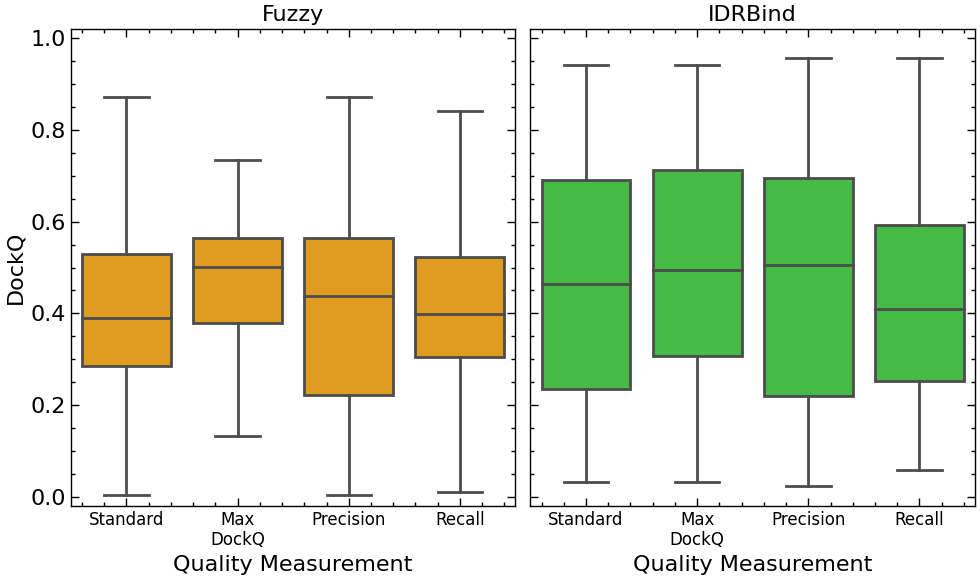

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
order=['Standard', 'Max\nDockQ', 'Precision', 'Recall']
g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == 'Fuzzy'],
                x='protocol', y='dockq', ax=ax[0], order=order, showfliers=False, color=FUZZY_DATASET_COLOR)
g.set(xlabel='Quality Measurement', ylabel='DockQ', ylim=(-0.02, 1.02))
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_title('Fuzzy')

pairs = [
    ('Standard', 'Precision'),
    ('Standard', 'Recall'),
    ('Precision', 'Recall'),
    ('Standard', 'BestRank'),
    ('Precision', 'BestRank'),
    ('Recall', 'BestRank'),
]

# annotator = Annotator(g, pairs, x='protocol', y='dockq', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2, hide_non_significant=True)

g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == 'IDRBind'],
                x='protocol', y='dockq', ax=ax[1], order=order, showfliers=False, color=IDRBIND_DATASET_COLOR)
g.set(xlabel='Quality Measurement', ylabel='')
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_title('IDRBind')

pairs = [
    ('Standard', 'Precision'),
    ('Standard', 'Recall'),
    ('Precision', 'Recall'),
    ('Standard', 'BestRank'),
    ('Precision', 'BestRank'),
    ('Recall', 'BestRank'),
]

plt.tight_layout()
fig.savefig('../figures/fuzzy_dockq_protocol_comparison.pdf', bbox_inches='tight')
plt.show()

In [27]:
def annotate_stacked_barplot(ax, colors, order):
    for i, bar in enumerate(ax.patches):
        bar.set_color(colors[i//len(order)+1])
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        color = 'white' if get_luminance(p.get_facecolor()) <= 0.7 else 'black'  # Choose color based on luminance
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', color=color, fontsize=10)
    x_sum = {}
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        x_sum[x] = x_sum.get(x, 0) + height
    for p in ax.patches[-len(order):]:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{x_sum[x]:.1f}%', (x + width / 2, y + height+2), ha='center', va='bottom', color='k', fontsize=16)

    # legend
    high_handle = object()
    medium_handle = object()
    acceptable_handle = object()
    pals = [colors]
    ax.legend(
        title='',
        handles=[acceptable_handle, medium_handle, high_handle],
        handler_map={
            high_handle: MultipleRectanglesHandler([pal[3] for pal in pals]),
            medium_handle: MultipleRectanglesHandler([pal[2] for pal in pals]),
            acceptable_handle: MultipleRectanglesHandler([pal[1] for pal in pals]),
        },
        labels=['Acceptable', 'Medium', 'High'],
        loc='upper left'
        # loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True
    )

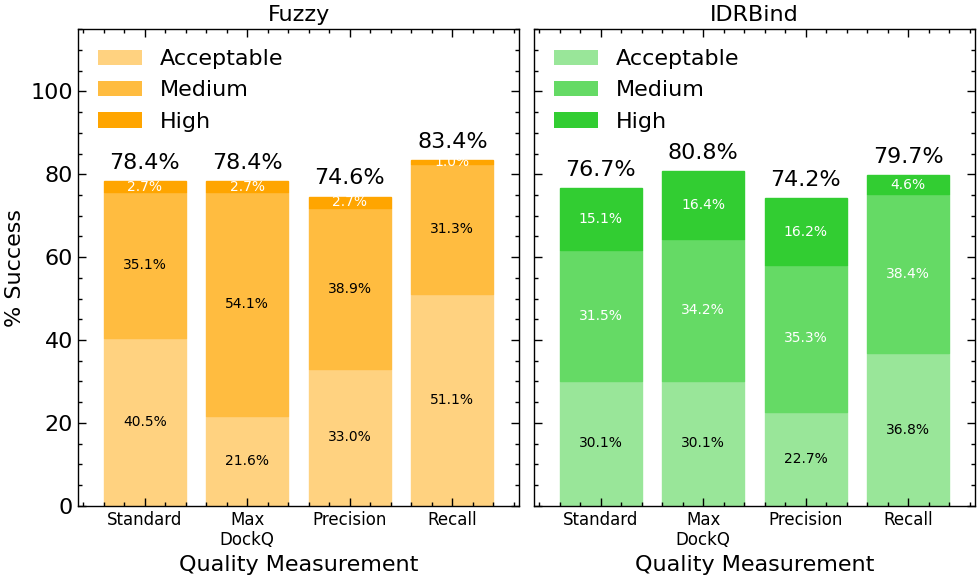

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
df_tmp2 = (df_tmp
 .groupby(['dataset', 'protocol'])['capri_dockq']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pivot(index=['dataset', 'protocol'], columns='capri_dockq', values='percent')[CAPRI_CLASSES[1:]]
    .reindex(CAPRI_CLASSES[1:], axis=1)
    .reindex(datasets, axis=0, level=0)
    .reindex(order, axis=0, level=1)
    .reset_index()
)
df_tmp2[df_tmp2['dataset'] == 'Fuzzy'].set_index('protocol').plot(kind='bar', stacked=True, rot=0, legend=False, ax=ax[0], width=0.8)
ax[0].set_title('Fuzzy')
ax[0].set_xlabel('Quality Measurement')
ax[0].set_ylabel('% Success')
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=12)
ax[0].set_ylim(0, 115)
annotate_stacked_barplot(ax[0], CAPRI_COLORS_FUZZY, order)

df_tmp2[df_tmp2['dataset'] == 'IDRBind'].set_index('protocol').plot(kind='bar', stacked=True, rot=0, legend=False, ax=ax[1], width=0.8)
ax[1].set_title('IDRBind')
ax[1].set_xlabel('Quality Measurement')
ax[1].set_ylabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=12)
annotate_stacked_barplot(ax[1], CAPRI_COLORS_IDRBIND, order)
    
plt.tight_layout()
fig.savefig('../figures/fuzzy_capri_protocol_comparison.pdf', bbox_inches='tight')
plt.show()

In [29]:
# add idp_fuzzy_residues column to fuzzy dataset
def extract_pdb_residues(row):
    regions = row['idp_fuzzy_residues']
    regions = [r.split('/')[0] for r in regions.split('_')]
    regions = [list(range(int(r.split('-')[0]), int(r.split('-')[1])+1)) for r in regions]
    regions = sum(regions, [])
    return regions

def regions_to_onehot(row, regions_key, plddt_key):
    regions = row[regions_key]
    if np.isnan(regions).all():
        return np.ones_like(row[plddt_key], dtype=int)
    length = len(row[plddt_key])
    onehot = np.zeros(length, dtype=int)
    regions = np.array(regions)
    onehot[regions-1] = 1
    return onehot

df_fuz_info = pd.read_csv('../data/fuzidp_uniprot.csv')
df_fuz_info['idp_fuzzy_pdb_residues'] = df_fuz_info.apply(extract_pdb_residues, axis=1)
print(df_fuz_info.shape)
df_fuz_info.head()

(46, 25)


,idp_uniprot_id,fuzzy_regions,sequence,pdb_id,n_models,min_chains,max_chains,idp_id,idp_fuzzy_residues,merged_idp_fuzzy_residues,...,idp_mutation_count,idp_mutation_coverage,idp_artifact_count,idp_artifact_coverage,receptor_uniprot,receptor_mutation_count,receptor_mutation_coverage,receptor_artifact_count,receptor_artifact_coverage,idp_fuzzy_pdb_residues
0,P03069,1-100_101-134,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,2LPB,13.0,2.0,2.0,B,1-34/101-134,1-134,...,NaN,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,P15337,101-120_146-160,MTMDSGADNQQSGDAAVTEAESQQMTVQAQPQIATLAQVSMPAAHA...,1KDX,17.0,2.0,2.0,B,1-16/105-120,101-160,...,2.0,0.03571,NaN,NaN,P45481:1:81:586,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,P03255,82-121,MRHIICHGGVITEEMAASLLDQLIEEVLADNLPPPSHFEPPTLHEL...,2KJE,20.0,2.0,2.0,B,33-42/82-91,50-121,...,NaN,NaN,2.0,0.07143,Q92793:1:92:1763,NaN,NaN,NaN,NaN,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42]"
3,Q04207,425-439_482-490,MDDLFPLIFPSEPAQASGPYVEIIEQPKQRGMRFRYKCEGRSAGSI...,2LWW,20.0,2.0,2.0,B,5-19/425-439_62-70/482-490,421-490,...,NaN,NaN,2.0,0.05714,P45481:1:100:340,NaN,NaN,NaN,NaN,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
4,Q03164,2839-2869_2840-2858,MAHSCRWRFPARPGTTGGGGGGGRRGLGGAPRQRVPALLLPPGPPV...,2LXS,20.0,2.0,2.0,B,1-19/2840-2858_1-19/2840-2858,2839-2869,...,2.0,0.05263,NaN,NaN,Q92793:1:87:587,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [30]:
order = ['Fuzzy', 'IDRBind']
df_tmp = df[(df['recycle'].isna()) & (df['exp'] == 'delim_idp') & (df['seed'] == 0) & (df['seed_rank'] == 1)
            & df['dataset'].isin(order) & df['reference_model'].eq(1)]
print(df_tmp.shape)
df_tmp['dataset'].value_counts()

(110, 149)


IDRBind    73
Fuzzy      37
Name: dataset, dtype: int64

In [31]:
df_tmp = pd.merge(
    df_tmp,
    df_fuz_info,
    on=['pdb_id', 'idp_id', 'receptor_id'],
    how='left'
)
df_tmp.head()

,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,idp_mutation_count_y,idp_mutation_coverage_y,idp_artifact_count_y,idp_artifact_coverage_y,receptor_uniprot_y,receptor_mutation_count_y,receptor_mutation_coverage_y,receptor_artifact_count_y,receptor_artifact_coverage_y,idp_fuzzy_pdb_residues
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,1KDX,B,A,False,1,alphafold2_multimer_v2,3.0,0,NaN,1.0,...,2.0,0.03571,NaN,NaN,P45481:1:81:586,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,2KJE,B,A,False,1,alphafold2_multimer_v2,1.0,0,NaN,1.0,...,NaN,NaN,2.0,0.07143,Q92793:1:92:1763,NaN,NaN,NaN,NaN,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42]"
3,2LWW,B,A,False,1,alphafold2_multimer_v2,2.0,0,NaN,1.0,...,NaN,NaN,2.0,0.05714,P45481:1:100:340,NaN,NaN,NaN,NaN,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
4,2LXS,B,A,False,1,alphafold2_multimer_v2,4.0,0,NaN,1.0,...,2.0,0.05263,NaN,NaN,Q92793:1:87:587,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [32]:
for col in tqdm([
    'plddt_idp',
    'riptm_idp',
    'pae_receptor_idp_mean', 'pae_receptor_idp_min',
]):
    df_tmp[col] = df_tmp[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

100%|██████████| 4/4 [00:00<00:00, 225.40it/s]


In [33]:
df_tmp['idp_fuzzy_residues_onehot'] = df_tmp.apply(lambda x: regions_to_onehot(x, 'idp_fuzzy_pdb_residues', 'plddt_idp'), axis=1)
df_tmp[['dataset', 'pdb_id', 'idp_id', 'receptor_id', 'idp_fuzzy_residues', 'idp_fuzzy_residues_onehot']].head()

,dataset,pdb_id,idp_id,receptor_id,idp_fuzzy_residues,idp_fuzzy_residues_onehot
0,Fuzzy,2LPB,B,A,1-34/101-134,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Fuzzy,1KDX,B,A,1-16/105-120,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Fuzzy,2KJE,B,A,33-42/82-91,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Fuzzy,2LWW,B,A,5-19/425-439_62-70/482-490,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Fuzzy,2LXS,B,A,1-19/2840-2858_1-19/2840-2858,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [34]:
df_1d = df_tmp.explode(['idp_fuzzy_residues_onehot', 'plddt_idp', 'riptm_idp', 'pae_receptor_idp_mean', 'pae_receptor_idp_min'])
df_1d

,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,idp_mutation_coverage_y,idp_artifact_count_y,idp_artifact_coverage_y,receptor_uniprot_y,receptor_mutation_count_y,receptor_mutation_coverage_y,receptor_artifact_count_y,receptor_artifact_coverage_y,idp_fuzzy_pdb_residues,idp_fuzzy_residues_onehot
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,P19659:1:81:158,NaN,NaN,NaN,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,3H8K,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
109,3H8K,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
109,3H8K,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
109,3H8K,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


/tmp/ipykernel_2413617/425564028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1d_fuz[y] = df_1d_fuz[y].astype(float)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:8.692e-09 U_stat=9.608e+05


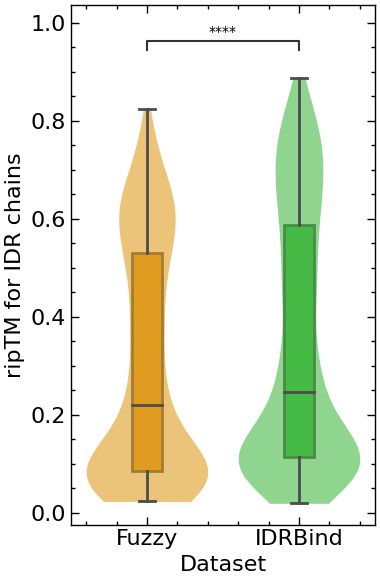

In [53]:
fig, ax = plt.subplots(figsize=(4, 6))

df_1d_fuz = df_1d[df_1d['idp_fuzzy_residues_onehot'].eq(1)]
# df_1d_fuz = df_1d
y='riptm_idp'
# y='pae_receptor_idp_min'
df_1d_fuz[y] = df_1d_fuz[y].astype(float)
palette = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR]
g = sns.violinplot(x='dataset', y=y, data=df_1d_fuz, ax=ax, showfliers=False, order=datasets,
                    palette=palette, inner=None, linewidth=0, cut=0, scale='width')
plt.setp(g.collections, alpha=0.6)
g = sns.boxplot(data=df_1d_fuz, y=y, x='dataset', showfliers=False, palette=palette, ax=ax, order=datasets,
                zorder=2, width=0.2)
g.set(xlabel='Dataset', ylabel='ripTM for IDR chains')

annotator = Annotator(g, pairs=[('Fuzzy', 'IDRBind')], x='dataset', y=y, verbose=2, data=df_1d_fuz)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
annotator.apply_and_annotate()

plt.tight_layout()
fig.savefig('../figures/fuzzy_riptm_idp_violin.pdf', bbox_inches='tight')


In [36]:
df_1d[df_1d['idp_fuzzy_residues_onehot'].eq(0) & df_1d['dataset'].eq('Fuzzy')]['pdb_id'].value_counts().sort_values()

1IDH     1
1LXG     1
2MH0     2
2N55     2
2L1L     2
5XV8     3
2VDA     3
2KNC     5
2N8J     6
2MZP     7
1KDX    12
1EES    18
1YX6    21
2MBH    22
2LQI    28
2KJE    32
2LWW    46
Name: pdb_id, dtype: int64

In [37]:
order = ['Decoys', 'Fuzzy', 'IDRBind']#, 'Rg+ID', 'Rg', 'Bret et al.']
df_tmp = df[(df['recycle'].isna()) & (df['exp'] == 'delim_idp') & (df['seed'] == 0) & (df['seed_rank'] == 1)
                 & ((df['reference_model'] == 1) | (df['dataset'] == 'Decoys'))
                 & (df['dataset'].isin(order))
                 & (df['idp_dv'].notna())]
print(df_tmp.shape)
df_tmp.head()

(71, 149)


,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,idp_rmsf_af,receptor_rmsf_af,idp_rmsf_align_idp_af,receptor_rmsf_align_idp_af,idp_rmsf_align_receptor_af,receptor_rmsf_align_receptor_af,dv_idp_residue_ids_af,dv_receptor_residue_ids_af,dataset_af,exp_af
104,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,"[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
427,1KDX,B,A,False,1,alphafold2_multimer_v2,3.0,0,NaN,1.0,...,"[1.3975565433502197, 1.1846904754638672, 0.996...","[0.9285249710083008, 0.5962011814117432, 0.602...","[0.5069566369056702, 0.3874449133872986, 0.368...","[1.7623697519302368, 1.7712185382843018, 1.588...","[1.6732209920883179, 1.4281058311462402, 1.230...","[0.9042866826057434, 0.5225505232810974, 0.571...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
870,2KJE,B,A,False,1,alphafold2_multimer_v2,1.0,0,NaN,1.0,...,"[8.194504737854004, 8.317364692687988, 8.81126...","[2.6236133575439453, 2.3483428955078125, 2.467...","[10.399741172790527, 8.181036949157715, 6.2920...","[18.38439178466797, 15.595551490783691, 14.544...","[11.55700397491455, 11.865933418273926, 12.060...","[1.3999924659729004, 1.2320514917373657, 1.010...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
1330,2LWW,B,A,False,1,alphafold2_multimer_v2,2.0,0,NaN,1.0,...,"[12.686895370483398, 11.957334518432617, 11.17...","[3.59214186668396, 3.1974992752075195, 2.15016...","[10.414929389953613, 9.581012725830078, 9.0443...","[6.5025529861450195, 6.25172758102417, 4.79063...","[16.116987228393555, 15.167434692382812, 14.22...","[2.8978521823883057, 2.4940338134765625, 1.501...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp
1810,2LXS,B,A,False,1,alphafold2_multimer_v2,4.0,0,NaN,1.0,...,"[6.154327392578125, 6.9408488273620605, 5.2686...","[0.6962434649467468, 0.6568000316619873, 0.461...","[2.3433759212493896, 1.1613621711730957, 1.447...","[16.31722640991211, 17.693416595458984, 19.874...","[7.266795635223389, 7.8689422607421875, 6.1379...","[0.40859660506248474, 0.3072725236415863, 0.26...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp


In [38]:
for col in tqdm(['pae_idp_idp_raw', 'pae_idp_receptor_raw', 'pae_receptor_idp_raw', 'pae_receptor_receptor_raw',
            'dv_idp_residue_ids', 'dv_receptor_residue_ids', 'idp_dv', 'receptor_dv', 'idp_receptor_dv',
            'idp_rmsf', 'receptor_rmsf',
            'idp_rmsf_align_idp', 'receptor_rmsf_align_idp',
            'idp_rmsf_align_receptor', 'receptor_rmsf_align_receptor',
            'dv_idp_residue_ids_af', 'dv_receptor_residue_ids_af', 'idp_dv_af', 'receptor_dv_af', 'idp_receptor_dv_af',
            'idp_rmsf_af', 'receptor_rmsf_af',
            'idp_rmsf_align_idp_af', 'receptor_rmsf_align_idp_af',
            'idp_rmsf_align_receptor_af', 'receptor_rmsf_align_receptor_af',
            'plddt_idp', 'plddt_receptor',
            'riptm_idp', 'riptm_receptor',
            'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'pae_receptor_idp_mean', 'pae_receptor_receptor_mean',
            'pae_idp_idp_min', 'pae_idp_receptor_min', 'pae_receptor_idp_min', 'pae_receptor_receptor_min',]):
    df_tmp[col] = df_tmp[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

  0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_1936396/873662902.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[col] = df_tmp[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


In [39]:
df_tmp = df_tmp.dropna(subset=['pae_idp_idp_raw', 'pae_idp_receptor_raw', 'pae_receptor_idp_raw', 'pae_receptor_receptor_raw',
            'dv_idp_residue_ids', 'dv_receptor_residue_ids', 'idp_dv', 'receptor_dv', 'idp_receptor_dv',
            'idp_rmsf', 'receptor_rmsf',
            'idp_rmsf_align_idp', 'receptor_rmsf_align_idp',
            'idp_rmsf_align_receptor', 'receptor_rmsf_align_receptor',
            'dv_idp_residue_ids_af', 'dv_receptor_residue_ids_af', 'idp_dv_af', 'receptor_dv_af', 'idp_receptor_dv_af',
            'idp_rmsf_af', 'receptor_rmsf_af',
            'idp_rmsf_align_idp_af', 'receptor_rmsf_align_idp_af',
            'idp_rmsf_align_receptor_af', 'receptor_rmsf_align_receptor_af',
            'plddt_idp', 'plddt_receptor',
            'riptm_idp', 'riptm_receptor',
            'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'pae_receptor_idp_mean', 'pae_receptor_receptor_mean',
            'pae_idp_idp_min', 'pae_idp_receptor_min', 'pae_receptor_idp_min', 'pae_receptor_receptor_min',])
print(df_tmp.shape)

(71, 149)


In [40]:
def map_range(ids, uniprot_info):
    _, pdb_start, length, uniprot_start = uniprot_info.split(':')
    pdb_start, length, uniprot_start = tuple(map(int, [pdb_start, length, uniprot_start]))
    ids = np.array(ids)
    ids = ids - pdb_start + uniprot_start
    mask = ids > 0
    return ids[mask], mask

In [41]:
def prepare_2d_data(row, fragmented=False, colabfold=False):
    # idp_ids, idp_mask = map_range(row['dv_idp_residue_ids'], row['idp_uniprot'].split(';')[0])
    idp_ids = row['dv_idp_residue_ids']
    receptor_ids = row['dv_receptor_residue_ids']
    if fragmented:
        idp_start, idp_end = map(int, row['merged_idp_fuzzy_residues'].split('-'))
    else:
        # idp_start, idp_end = min(idp_ids), max(idp_ids)
        idp_start = 1

    pae_idp_idp = row['pae_idp_idp_raw'][idp_ids-idp_start][:, idp_ids-idp_start]
    pae_idp_receptor = row['pae_idp_receptor_raw'][idp_ids-idp_start][:, receptor_ids-1]
    pae_receptor_idp = row['pae_receptor_idp_raw'][receptor_ids-1][:, idp_ids-idp_start]
    pae_receptor_receptor = row['pae_receptor_receptor_raw'][receptor_ids-1][:, receptor_ids-1]

    riptm_idp = row['riptm_idp'][idp_ids-idp_start]
    riptm_receptor = row['riptm_receptor'][receptor_ids-1]

    idp_dv = row['idp_dv' + ('_af' if colabfold else '')]
    receptor_dv = row['receptor_dv' + ('_af' if colabfold else '')]
    idp_receptor_dv = row['idp_receptor_dv' + ('_af' if colabfold else '')]
    if colabfold:
        if idp_ids.max() > idp_dv.shape[0]:
            return None
        if receptor_ids.max() > receptor_dv.shape[0]:
            return None
        idp_dv = idp_dv[idp_ids-idp_start][:, idp_ids-idp_start]
        idp_receptor_dv = idp_receptor_dv[idp_ids-idp_start][:, receptor_ids-1]

    idp_rmsf = row['idp_rmsf' + ('_af' if colabfold else '')]
    idp_rmsf_align_idp = row['idp_rmsf_align_idp' + ('_af' if colabfold else '')]
    idp_rmsf_align_receptor = row['idp_rmsf_align_receptor' + ('_af' if colabfold else '')]
    receptor_rmsf = row['receptor_rmsf' + ('_af' if colabfold else '')]
    receptor_rmsf_align_idp = row['receptor_rmsf_align_idp' + ('_af' if colabfold else '')]
    receptor_rmsf_align_receptor = row['receptor_rmsf_align_receptor' + ('_af' if colabfold else '')]
    if colabfold:
        if idp_ids.max() > idp_rmsf.shape[0]:
            return None
        if receptor_ids.max() > receptor_rmsf.shape[0]:
            return None
        idp_rmsf = idp_rmsf[idp_ids-idp_start]
        idp_rmsf_align_idp = idp_rmsf_align_idp[idp_ids-idp_start]
        idp_rmsf_align_receptor = idp_rmsf_align_receptor[idp_ids-idp_start]
        receptor_rmsf = receptor_rmsf[receptor_ids-1]
        receptor_rmsf_align_idp = receptor_rmsf_align_idp[receptor_ids-1]
        receptor_rmsf_align_receptor = receptor_rmsf_align_receptor[receptor_ids-1]

    pae_idp_idp_mean = row['pae_idp_idp_mean'][idp_ids-idp_start]
    pae_receptor_idp_mean = row['pae_receptor_idp_mean'][idp_ids-idp_start]
    pae_receptor_idp_min = row['pae_receptor_idp_min'][idp_ids-idp_start]

    pae = np.concatenate([
        np.concatenate([pae_idp_idp, pae_idp_receptor], axis=1),
        np.concatenate([pae_receptor_idp, pae_receptor_receptor], axis=1)
    ], axis=0)

    pae_mean = pae.mean(axis=0)
    pae_idp_mean = pae_mean[:len(idp_ids)]
    pae_receptor_mean = pae_mean[len(idp_ids):]

    plddt_idp = row['plddt_idp'][idp_ids-idp_start]
    plddt_receptor = row['plddt_receptor'][receptor_ids-1]

    to_return = {
        'dv_idp': idp_dv.ravel().tolist(),
        'dv_inter': idp_receptor_dv.ravel().tolist(),
        'dv_receptor': receptor_dv.ravel().tolist(),
        'idp_rmsf': idp_rmsf.tolist(),
        'receptor_rmsf': receptor_rmsf.tolist(),
        'idp_rmsf_align_idp': idp_rmsf_align_idp.tolist(),
        'receptor_rmsf_align_idp': receptor_rmsf_align_idp.tolist(),
        'idp_rmsf_align_receptor': idp_rmsf_align_receptor.tolist(),
        'receptor_rmsf_align_receptor': receptor_rmsf_align_receptor.tolist(),
    }

    if not colabfold:
        to_return['pae_idp'] = ((pae_idp_idp + pae_idp_idp.T) / 2).ravel().tolist()
        to_return['pae_inter'] = (pae_idp_receptor).ravel().tolist()
        to_return['pae_receptor'] = ((pae_receptor_receptor + pae_receptor_receptor.T) / 2).ravel().tolist()
        to_return['pae_idp_idp_mean'] = pae_idp_idp_mean.tolist()
        to_return['pae_receptor_idp_mean'] = pae_receptor_idp_mean.tolist()
        to_return['pae_receptor_idp_min'] = pae_receptor_idp_min.tolist()
        to_return['pae_idp_mean'] = pae_idp_mean.tolist()
        to_return['pae_receptor_mean'] = pae_receptor_mean.tolist()
        to_return['plddt_idp'] = plddt_idp.tolist()
        to_return['plddt_receptor'] = plddt_receptor.tolist()
        to_return['riptm_idp'] = riptm_idp.tolist()
        to_return['riptm_receptor'] = riptm_receptor.tolist()
    
    return to_return

In [42]:
df_1d = df_tmp[df_tmp['exp'] == 'delim_idp'].apply(lambda a: prepare_2d_data(a, fragmented=False, colabfold=False),
                                                   axis=1, result_type='expand')
df_1d_af = df_tmp[df_tmp['exp'] == 'delim_idp'].apply(lambda a: prepare_2d_data(a, fragmented=False, colabfold=True),
                                                      axis=1, result_type='expand')
df_1d_af.columns = [f'{col}_af' for col in df_1d_af.columns]
df_1d = pd.concat([df_1d, df_1d_af], axis=1)
print(df_1d.shape)
df_1d.head()

(71, 30)


,dv_idp,dv_inter,dv_receptor,idp_rmsf,receptor_rmsf,idp_rmsf_align_idp,receptor_rmsf_align_idp,idp_rmsf_align_receptor,receptor_rmsf_align_receptor,pae_idp,...,riptm_receptor,dv_idp_af,dv_inter_af,dv_receptor_af,idp_rmsf_af,receptor_rmsf_af,idp_rmsf_align_idp_af,receptor_rmsf_align_idp_af,idp_rmsf_align_receptor_af,receptor_rmsf_align_receptor_af
104,"[0.0, 0.004420892801135778, 0.4766846895217895...","[15.945747375488281, 15.239696502685547, 14.96...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[25.30580711364746, 24.345640182495117, 24.347...","[13.092268943786621, 12.39355182647705, 10.918...","[11.57382869720459, 10.420004844665527, 8.1001...","[23.97511863708496, 22.386951446533203, 20.766...","[40.86652755737305, 39.490501403808594, 38.454...","[7.090054035186768, 5.979752540588379, 4.87568...","[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...",...,"[0.0764, 0.0924, 0.1121, 0.1839, 0.2326, 0.280...","[0.0, 0.04653265327215195, 0.28023019433021545...","[3.4016311168670654, 2.9660816192626953, 3.047...","[0.0, 0.023441851139068604, 0.0946458131074905...","[5.077239036560059, 4.538157939910889, 4.05814...","[3.3395254611968994, 2.752061128616333, 2.4493...","[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889..."
427,"[0.0, 0.011171231046319008, 0.1437045484781265...","[3.2171154022216797, 2.4720346927642822, 2.519...","[0.0, 0.011617963202297688, 0.4568531811237335...","[2.4075191020965576, 1.761776328086853, 1.7871...","[3.9739909172058105, 1.8997701406478882, 1.657...","[1.3094465732574463, 0.977782130241394, 1.2248...","[4.558317184448242, 2.9537036418914795, 2.9900...","[2.9829254150390625, 2.2435715198516846, 2.178...","[3.997833013534546, 1.7963393926620483, 1.4807...","[0.75, 1.5499999999999998, 3.185, 3.4299999999...",...,"[0.0365, 0.0639, 0.1315, 0.275, 0.3313, 0.4872...","[0.0, 0.049856752157211304, 0.1924857050180435...","[1.141861915588379, 0.9444748759269714, 0.8778...","[0.0, 0.047710467129945755, 0.0988930687308311...","[1.3975565433502197, 1.1846904754638672, 0.996...","[0.9285249710083008, 0.5962011814117432, 0.602...","[0.5069566369056702, 0.3874449133872986, 0.368...","[1.7623697519302368, 1.7712185382843018, 1.588...","[1.6732209920883179, 1.4281058311462402, 1.230...","[0.9042866826057434, 0.5225505232810974, 0.571..."
870,"[0.0, 0.005769489333033562, 0.8059492707252502...","[3.1182353496551514, 3.1275107860565186, 2.932...","[0.0, 0.00823711883276701, 0.10360865294933319...","[6.478187561035156, 4.5563530921936035, 2.6501...","[2.3579840660095215, 1.926060676574707, 1.8695...","[6.094019412994385, 4.372585773468018, 2.81329...","[3.8458874225616455, 3.1434292793273926, 3.378...","[6.577322006225586, 4.701900959014893, 2.66464...","[1.8073033094406128, 1.3508872985839844, 1.062...","[0.75, 1.54, 4.01, 6.46, 8.14, 10.405000000000...",...,"[0.2428, 0.3326, 0.3567, 0.4146, 0.4395, 0.446...","[0.0, 0.04801749065518379, 0.1335156112909317,...","[4.605994701385498, 4.257450103759766, 3.94734...","[0.0, 0.012901302427053452, 0.0343587771058082...","[8.194504737854004, 8.317364692687988, 8.81126...","[2.6236133575439453, 2.3483428955078125, 2.467...","[10.399741172790527, 8.181036949157715, 6.2920...","[18.38439178466797, 15.595551490783691, 14.544...","[11.55700397491455, 11.865933418273926, 12.060...","[1.3999924659729004, 1.2320514917373657, 1.010..."
1330,"[0.0, 0.009119702503085136, 0.6786515116691589...","[7.39204216003418, 6.994258880615234, 6.819908...","[0.0, 0.008101323619484901, 0.7196610569953918...","[15.228927612304688, 13.610774040222168, 12.60...","[9.154064178466797, 7.211665153503418, 5.69236...","[13.621499061584473, 11.798469543457031, 10.73...","[10.730508804321289, 8.830914497375488, 7.2497...","[17.67160415649414, 16.294755935668945, 15.315...","[8.38552188873291, 6.3911943435668945, 4.69302...","[0.75, 1.8, 4.175000000000001, 6.

In [43]:
df_1d = df_1d.merge(df_tmp[df_tmp['exp'] == 'delim_idp'][['pdb_id', 'idp_id', 'receptor_id', 'seed', 'exp', 'seed_rank',
                                                  'combined', 'dockq', 'capri', 'iptm', 'ptm', 'dataset']], left_index=True, right_index=True)
print(df_1d.shape)
df_1d.head()

(71, 42)


,dv_idp,dv_inter,dv_receptor,idp_rmsf,receptor_rmsf,idp_rmsf_align_idp,receptor_rmsf_align_idp,idp_rmsf_align_receptor,receptor_rmsf_align_receptor,pae_idp,...,receptor_id,seed,exp,seed_rank,combined,dockq,capri,iptm,ptm,dataset
104,"[0.0, 0.004420892801135778, 0.4766846895217895...","[15.945747375488281, 15.239696502685547, 14.96...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[25.30580711364746, 24.345640182495117, 24.347...","[13.092268943786621, 12.39355182647705, 10.918...","[11.57382869720459, 10.420004844665527, 8.1001...","[23.97511863708496, 22.386951446533203, 20.766...","[40.86652755737305, 39.490501403808594, 38.454...","[7.090054035186768, 5.979752540588379, 4.87568...","[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...",...,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66,Fuzzy
427,"[0.0, 0.011171231046319008, 0.1437045484781265...","[3.2171154022216797, 2.4720346927642822, 2.519...","[0.0, 0.011617963202297688, 0.4568531811237335...","[2.4075191020965576, 1.761776328086853, 1.7871...","[3.9739909172058105, 1.8997701406478882, 1.657...","[1.3094465732574463, 0.977782130241394, 1.2248...","[4.558317184448242, 2.9537036418914795, 2.9900...","[2.9829254150390625, 2.2435715198516846, 2.178...","[3.997833013534546, 1.7963393926620483, 1.4807...","[0.75, 1.5499999999999998, 3.185, 3.4299999999...",...,A,0,delim_idp,1.0,0.810,0.872,High,0.81,0.81,Fuzzy
870,"[0.0, 0.005769489333033562, 0.8059492707252502...","[3.1182353496551514, 3.1275107860565186, 2.932...","[0.0, 0.00823711883276701, 0.10360865294933319...","[6.478187561035156, 4.5563530921936035, 2.6501...","[2.3579840660095215, 1.926060676574707, 1.8695...","[6.094019412994385, 4.372585773468018, 2.81329...","[3.8458874225616455, 3.1434292793273926, 3.378...","[6.577322006225586, 4.701900959014893, 2.66464...","[1.8073033094406128, 1.3508872985839844, 1.062...","[0.75, 1.54, 4.01, 6.46, 8.14, 10.405000000000...",...,A,0,delim_idp,1.0,0.782,0.371,Acceptable,0.79,0.75,Fuzzy
1330,"[0.0, 0.009119702503085136, 0.6786515116691589...","[7.39204216003418, 6.994258880615234, 6.819908...","[0.0, 0.008101323619484901, 0.7196610569953918...","[15.228927612304688, 13.610774040222168, 12.60...","[9.154064178466797, 7.211665153503418, 5.69236...","[13.621499061584473, 11.798469543457031, 10.73...","[10.730508804321289, 8.830914497375488, 7.2497...","[17.67160415649414, 16.294755935668945, 15.315...","[8.38552188873291, 6.3911943435668945, 4.69302...","[0.75, 1.8, 4.175000000000001, 6.075, 7.890000...",...,A,0,delim_idp,1.0,0.640,0.380,Acceptable,0.63,0.68,Fuzzy
1810,"[0.0, 0.007883669808506966, 0.3913037478923797...","[4.373047828674316, 4.3515520095825195, 4.5960...","[0.0, 0.01323478389531374, 0.3111036717891693,...","[3.5997579097747803, 3.7408180236816406, 3.106...","[6.831446647644043, 5.969977378845215, 5.70419...","[2.6728641986846924, 2.1719236373901367, 1.932...","[9.82140827178955, 8.80696964263916, 7.8907132...","[3.8469972610473633, 3.97347354888916, 3.35493...","[6.745087623596191, 5.866848468780518, 5.59209...","[0.75, 1.645, 4.300000000000001, 6.715, 8.9349...",...,A,0,delim_idp,1.0,0.722,0.523,Medium,0.70,0.81,Fuzzy


In [44]:
df_1d = df_1d.dropna(subset=['idp_rmsf_af', 'dv_idp_af'])
print(df_1d.shape)
df_1d.head()

(64, 42)


,dv_idp,dv_inter,dv_receptor,idp_rmsf,receptor_rmsf,idp_rmsf_align_idp,receptor_rmsf_align_idp,idp_rmsf_align_receptor,receptor_rmsf_align_receptor,pae_idp,...,receptor_id,seed,exp,seed_rank,combined,dockq,capri,iptm,ptm,dataset
104,"[0.0, 0.004420892801135778, 0.4766846895217895...","[15.945747375488281, 15.239696502685547, 14.96...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[25.30580711364746, 24.345640182495117, 24.347...","[13.092268943786621, 12.39355182647705, 10.918...","[11.57382869720459, 10.420004844665527, 8.1001...","[23.97511863708496, 22.386951446533203, 20.766...","[40.86652755737305, 39.490501403808594, 38.454...","[7.090054035186768, 5.979752540588379, 4.87568...","[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...",...,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66,Fuzzy
427,"[0.0, 0.011171231046319008, 0.1437045484781265...","[3.2171154022216797, 2.4720346927642822, 2.519...","[0.0, 0.011617963202297688, 0.4568531811237335...","[2.4075191020965576, 1.761776328086853, 1.7871...","[3.9739909172058105, 1.8997701406478882, 1.657...","[1.3094465732574463, 0.977782130241394, 1.2248...","[4.558317184448242, 2.9537036418914795, 2.9900...","[2.9829254150390625, 2.2435715198516846, 2.178...","[3.997833013534546, 1.7963393926620483, 1.4807...","[0.75, 1.5499999999999998, 3.185, 3.4299999999...",...,A,0,delim_idp,1.0,0.810,0.872,High,0.81,0.81,Fuzzy
870,"[0.0, 0.005769489333033562, 0.8059492707252502...","[3.1182353496551514, 3.1275107860565186, 2.932...","[0.0, 0.00823711883276701, 0.10360865294933319...","[6.478187561035156, 4.5563530921936035, 2.6501...","[2.3579840660095215, 1.926060676574707, 1.8695...","[6.094019412994385, 4.372585773468018, 2.81329...","[3.8458874225616455, 3.1434292793273926, 3.378...","[6.577322006225586, 4.701900959014893, 2.66464...","[1.8073033094406128, 1.3508872985839844, 1.062...","[0.75, 1.54, 4.01, 6.46, 8.14, 10.405000000000...",...,A,0,delim_idp,1.0,0.782,0.371,Acceptable,0.79,0.75,Fuzzy
1330,"[0.0, 0.009119702503085136, 0.6786515116691589...","[7.39204216003418, 6.994258880615234, 6.819908...","[0.0, 0.008101323619484901, 0.7196610569953918...","[15.228927612304688, 13.610774040222168, 12.60...","[9.154064178466797, 7.211665153503418, 5.69236...","[13.621499061584473, 11.798469543457031, 10.73...","[10.730508804321289, 8.830914497375488, 7.2497...","[17.67160415649414, 16.294755935668945, 15.315...","[8.38552188873291, 6.3911943435668945, 4.69302...","[0.75, 1.8, 4.175000000000001, 6.075, 7.890000...",...,A,0,delim_idp,1.0,0.640,0.380,Acceptable,0.63,0.68,Fuzzy
1810,"[0.0, 0.007883669808506966, 0.3913037478923797...","[4.373047828674316, 4.3515520095825195, 4.5960...","[0.0, 0.01323478389531374, 0.3111036717891693,...","[3.5997579097747803, 3.7408180236816406, 3.106...","[6.831446647644043, 5.969977378845215, 5.70419...","[2.6728641986846924, 2.1719236373901367, 1.932...","[9.82140827178955, 8.80696964263916, 7.8907132...","[3.8469972610473633, 3.97347354888916, 3.35493...","[6.745087623596191, 5.866848468780518, 5.59209...","[0.75, 1.645, 4.300000000000001, 6.715, 8.9349...",...,A,0,delim_idp,1.0,0.722,0.523,Medium,0.70,0.81,Fuzzy


In [45]:
df_1d_idp = df_1d.explode(['idp_rmsf', 'idp_rmsf_align_idp', 'idp_rmsf_align_receptor',
                           'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'pae_receptor_idp_min', 'pae_idp_mean',
                           'plddt_idp', 'riptm_idp',
                           'idp_rmsf_af', 'idp_rmsf_align_idp_af', 'idp_rmsf_align_receptor_af']
).reset_index()
df_1d_idp.shape

(1992, 43)

In [46]:
cols = ['idp_rmsf', 'idp_rmsf_af', 'idp_rmsf_align_idp', 'idp_rmsf_align_receptor', 'idp_rmsf_align_idp_af', 'idp_rmsf_align_receptor_af',
    'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'pae_receptor_idp_min', 'plddt_idp', 'pae_idp_mean', 'riptm_idp']
for col in cols:
    df_1d_idp.loc[:, col] = df_1d_idp[col].astype(float)
df_1d_idp.groupby('dataset')[cols].corr(method='spearman')

/tmp/ipykernel_1936396/1524368852.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_1d_idp.loc[:, col] = df_1d_idp[col].astype(float)


idp_rmsf  idp_rmsf_af  idp_rmsf_align_idp  \
dataset                                                                         
Fuzzy   idp_rmsf                    1.000000     0.429493            0.862036   
        idp_rmsf_af                 0.429493     1.000000            0.336629   
        idp_rmsf_align_idp          0.862036     0.336629            1.000000   
        idp_rmsf_align_receptor     0.837799     0.446089            0.577718   
        idp_rmsf_align_idp_af       0.520090     0.675081            0.597824   
        idp_rmsf_align_receptor_af  0.461681     0.971740            0.356942   
        pae_idp_idp_mean            0.561425     0.486584            0.675638   
        pae_receptor_idp_mean       0.582501     0.690927            0.488688   
        pae_receptor_idp_min        0.652443     0.674395            0.527907   
        plddt_idp                  -0.555712    -0.416609           -0.485499   
        pae_idp_mean                0.608655     0.668000            0.609027   
        riptm_idp                  -0.707046    -0.559212           -0.600004   
IDRBind idp_rmsf                    1.000000     0.387890            0.831749   
        idp_rmsf_af                 0.387890     1.000000            0.342034   
        idp_rmsf_align_idp          0.831749     0.342034            1.000000   
        idp_rmsf_align_receptor     0.889789     0.405268            0.604977   
        idp_rmsf_align_idp_af       0.409418     0.704182            0.495173   
        idp_rmsf_align_receptor_af  0.356181     0.928618            0.243415   
        pae_idp_idp_mean            0.416768     0.474847            0.641333   
        pae_receptor_idp_mean       0.551526     0.317671            0.521072   
        pae_receptor_idp_min        0.602201     0.449670            0.566605   
        plddt_idp                  -0.616501    -0.517446           -0.598616   
        pae_idp_mean                0.572742     0.404761            0.621721   
        riptm_idp                  -0.664230    -0.475060           -0.595513   

                                    idp_rmsf_align_receptor  \
dataset                                                       
Fuzzy   idp_rmsf                                   0.837799   
        idp_rmsf_af                                0.446089   
        idp_rmsf_align_idp                         0.577718   
        idp_rmsf_align_receptor                    1.000000   
        idp_rmsf_align_idp_af                      0.348955   
        idp_rmsf_align_receptor_af                 0.498223   
        pae_idp_idp_mean                           0.346959   
        pae_receptor_idp_mean                      0.648086   
        pae_receptor_idp_min                       0.746679   
        plddt_idp                                 -0.543608   
        pae_idp_mean                               0.541843   
        riptm_idp                                 -0.757914   
IDRBind idp_rmsf                                   0.889789   
        idp_rmsf_af                                0.405268   
        idp_rmsf_align_idp                         0.604977   
        idp_rmsf_align_receptor                    1.000000   
        idp_rmsf_align_idp_af                      0.349984   
        idp_rmsf_align_receptor_af                 0.464986   
        pae_idp_idp_mean                           0.225248   
        pae_receptor_idp_mean                      0.560176   
        pae_receptor_idp_min                       0.575532   
        plddt_idp                                 -0.534148   
        pae_idp_mean                               0.480453   
        riptm_idp                                 -0.619354   

                                    idp_rmsf_align_idp_af  \
dataset                                                     
Fuzzy   idp_rmsf                                 0.520090   
        idp_rmsf_af                              0.675081   
        idp_rmsf_align_idp                    

In [47]:
df_1d_receptor = df_1d.explode(['receptor_rmsf', 'receptor_rmsf_align_idp', 'receptor_rmsf_align_receptor',
                            'receptor_rmsf_af', 'receptor_rmsf_align_idp_af', 'receptor_rmsf_align_receptor_af']
    ).reset_index()
df_1d_receptor.shape

(7087, 43)

In [48]:
cols = ['receptor_rmsf', 'receptor_rmsf_af', 'receptor_rmsf_align_idp', 'receptor_rmsf_align_receptor', 'receptor_rmsf_align_idp_af', 'receptor_rmsf_align_receptor_af']
for col in cols:
    df_1d_receptor.loc[:, col] = df_1d_receptor[col].astype(float)
df_1d_receptor.groupby('dataset')[cols].corr(method='spearman')


/tmp/ipykernel_1936396/3505419113.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_1d_receptor.loc[:, col] = df_1d_receptor[col].astype(float)


receptor_rmsf  receptor_rmsf_af  \
dataset                                                                    
Fuzzy   receptor_rmsf                         1.000000          0.186877   
        receptor_rmsf_af                      0.186877          1.000000   
        receptor_rmsf_align_idp               0.137541          0.397718   
        receptor_rmsf_align_receptor          0.677430          0.158731   
        receptor_rmsf_align_idp_af           -0.109349          0.724187   
        receptor_rmsf_align_receptor_af       0.537870          0.620728   
IDRBind receptor_rmsf                         1.000000          0.545071   
        receptor_rmsf_af                      0.545071          1.000000   
        receptor_rmsf_align_idp               0.616205          0.351708   
        receptor_rmsf_align_receptor          0.755481          0.565050   
        receptor_rmsf_align_idp_af            0.351453          0.733263   
        receptor_rmsf_align_receptor_af       0.606447          0.698241   

                                         receptor_rmsf_align_idp  \
dataset                                                            
Fuzzy   receptor_rmsf                                   0.137541   
        receptor_rmsf_af                                0.397718   
        receptor_rmsf_align_idp                         1.000000   
        receptor_rmsf_align_receptor                    0.031664   
        receptor_rmsf_align_idp_af                      0.555886   
        receptor_rmsf_align_receptor_af                 0.130848   
IDRBind receptor_rmsf                                   0.616205   
        receptor_rmsf_af                                0.351708   
        receptor_rmsf_align_idp                         1.000000   
        receptor_rmsf_align_receptor                    0.304696   
        receptor_rmsf_align_idp_af                      0.428268   
        receptor_rmsf_align_receptor_af                 0.276727   

                                         receptor_rmsf_align_receptor  \
dataset                                                                 
Fuzzy   receptor_rmsf                                        0.677430   
        receptor_rmsf_af                                     0.158731   
        receptor_rmsf_align_idp                              0.031664   
        receptor_rmsf_align_receptor                         1.000000   
        receptor_rmsf_align_idp_af                           0.018604   
        receptor_rmsf_align_receptor_af                      0.527188   
IDRBind receptor_rmsf                                        0.755481   
        receptor_rmsf_af                                     0.565050   
        receptor_rmsf_align_idp                              0.304696   
        receptor_rmsf_align_receptor                         1.000000   
        receptor_rmsf_align_idp_af                           0.260541   
        receptor_rmsf_align_receptor_af                      0.808983   

                                         receptor_rmsf_align_idp_af  \
dataset                                                               
Fuzzy   receptor_rmsf                                     -0.109349   
        receptor_rmsf_af                                   0.724187   
        receptor_rmsf_align_idp                            0.555886   
        receptor_rmsf_align_receptor                       0.018604   
        receptor_rmsf_align_idp_af                         1.000000   
        receptor_rmsf_align_receptor_af                    0.251780   
IDRBind receptor_rmsf                                      0.351453   
        receptor_rmsf_af                                   0.733263   
        receptor_rmsf_align_idp                            0.428268   
        receptor_rmsf_align_receptor                       0.260541   
        receptor_rmsf_align_idp_af                         1.000000   
        receptor_rmsf_align_receptor_af                    0.334916   

     

In [49]:
df_2d_idp = df_1d.explode(['dv_idp', 'dv_idp_af', 'pae_idp']).reset_index()
df_2d_idp.shape

(83680, 43)

In [50]:
cols = ['dv_idp', 'dv_idp_af', 'pae_idp']
for col in cols:
    df_2d_idp.loc[:, col] = df_2d_idp[col].astype(float)
df_2d_idp.groupby('dataset')[cols].corr(method='spearman')

/tmp/ipykernel_1936396/199907376.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_2d_idp.loc[:, col] = df_2d_idp[col].astype(float)


dv_idp  dv_idp_af   pae_idp
dataset                                         
Fuzzy   dv_idp     1.000000   0.837666  0.891463
        dv_idp_af  0.837666   1.000000  0.905780
        pae_idp    0.891463   0.905780  1.000000
IDRBind dv_idp     1.000000   0.661233  0.759261
        dv_idp_af  0.661233   1.000000  0.775610
        pae_idp    0.759261   0.775610  1.000000

In [51]:
df_2d_receptor = df_1d.explode(['dv_receptor']).reset_index()
df_2d_receptor.shape

(1394847, 43)

In [52]:
cols = ['dv_receptor']
for col in cols:
    df_2d_receptor.loc[:, col] = df_2d_receptor[col].astype(float)
df_2d_receptor.groupby('dataset')[cols].corr(method='spearman')

/tmp/ipykernel_1936396/4188367438.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_2d_receptor.loc[:, col] = df_2d_receptor[col].astype(float)


,,dv_receptor
dataset,,
Fuzzy,dv_receptor,1.0
IDRBind,dv_receptor,1.0


In [53]:
df_2d_inter = df_1d.explode(['dv_inter', 'dv_inter_af', 'pae_inter']).reset_index()
df_2d_inter.shape

(228220, 43)

In [54]:
cols = ['dv_inter', 'dv_inter_af', 'pae_inter']
for col in cols:
    df_2d_inter.loc[:, col] = df_2d_inter[col].astype(float)
df_2d_inter.groupby('dataset')[cols].corr(method='spearman')

/tmp/ipykernel_1936396/467406313.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_2d_inter.loc[:, col] = df_2d_inter[col].astype(float)


dv_inter  dv_inter_af  pae_inter
dataset                                              
Fuzzy   dv_inter     1.000000     0.435895   0.680053
        dv_inter_af  0.435895     1.000000   0.686077
        pae_inter    0.680053     0.686077   1.000000
IDRBind dv_inter     1.000000     0.438439   0.632260
        dv_inter_af  0.438439     1.000000   0.448167
        pae_inter    0.632260     0.448167   1.000000

In [55]:
corr_1d = df_1d_idp.groupby('dataset')[
    ['idp_rmsf', 'idp_rmsf_af', 'plddt_idp', 'riptm_idp']
].corr(method='spearman')
corr_1d.drop('IDRBind', level=0, inplace=True)
corr_1d = corr_1d.droplevel(0)
corr_1d = corr_1d[['idp_rmsf']]
corr_1d.drop('idp_rmsf', axis=0, inplace=True)
corr_1d.rename(
    columns={'idp_rmsf': 'IDR RMSF'},
    index={'idp_rmsf_af': 'AFRMSF', 'plddt_idp': 'pLDDT', 'riptm_idp': 'ripTM'},
    inplace=True
)
corr_1d

,IDR RMSF
AFRMSF,0.429493
pLDDT,-0.555712
ripTM,-0.707046


In [56]:
corr_1d_inter = df_1d_idp.groupby('dataset')[
    ['idp_rmsf_align_receptor', 'idp_rmsf_align_receptor_af', 'plddt_idp', 'riptm_idp']
].corr(method='spearman')
corr_1d_inter.drop('IDRBind', level=0, inplace=True)
corr_1d_inter = corr_1d_inter.droplevel(0)
corr_1d_inter = corr_1d_inter[['idp_rmsf_align_receptor']]
corr_1d_inter.drop('idp_rmsf_align_receptor', axis=0, inplace=True)
corr_1d_inter.rename(
    columns={'idp_rmsf_align_receptor': 'IDR RMSF\n(align on receptor)'},
    index={'idp_rmsf_align_receptor_af': 'AFRMSF', 'plddt_idp': 'pLDDT', 'riptm_idp': 'ripTM'},
    inplace=True
)
corr_1d_inter

,IDR RMSF\n(align on receptor)
AFRMSF,0.498223
pLDDT,-0.543608
ripTM,-0.757914


In [57]:
corr_1d = pd.concat([corr_1d, corr_1d_inter], axis=1)
corr_1d

,IDR RMSF,IDR RMSF\n(align on receptor)
AFRMSF,0.429493,0.498223
pLDDT,-0.555712,-0.543608
ripTM,-0.707046,-0.757914


In [58]:
corr_2d = df_2d_idp.groupby('dataset')[['dv_idp', 'dv_idp_af', 'pae_idp']].corr(method='spearman')
corr_2d = corr_2d['dv_idp'].unstack().T
corr_2d.drop('dv_idp', axis=0, inplace=True)
corr_2d.drop('IDRBind', axis=1, inplace=True)
corr_2d.rename(index={'dv_idp_af': 'AFDV', 'pae_idp': 'PAE'}, columns={'Fuzzy': 'IDR DV'}, inplace=True)
corr_2d

dataset,IDR DV
AFDV,0.837666
PAE,0.891463


In [59]:
corr_2d_inter = df_2d_inter.groupby('dataset')[['dv_inter', 'dv_inter_af', 'pae_inter']].corr(method='spearman')
corr_2d_inter = corr_2d_inter['dv_inter'].unstack().T
corr_2d_inter.drop('dv_inter', axis=0, inplace=True)
corr_2d_inter.drop('IDRBind', axis=1, inplace=True)
corr_2d_inter.rename(index={'dv_inter_af': 'AFDV', 'pae_inter': 'PAE'}, columns={'Fuzzy': 'Inter-chain DV'}, inplace=True)
corr_2d_inter

dataset,Inter-chain DV
AFDV,0.435895
PAE,0.680053


In [60]:
corr_2d = pd.concat([corr_2d, corr_2d_inter], axis=1)
corr_2d

dataset,IDR DV,Inter-chain DV
AFDV,0.837666,0.435895
PAE,0.891463,0.680053


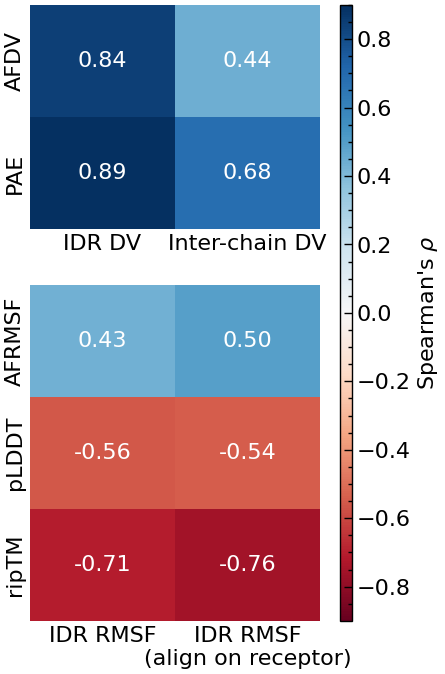

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8), gridspec_kw={'height_ratios': [2, 3]})

# First heatmap
g1 = sns.heatmap(corr_1d,
                 cmap='RdBu', annot=True, fmt='.2f', center=0, vmin=-0.9, vmax=0.9,
                 ax=ax[1], cbar=False, annot_kws={'fontsize': 16})
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)
g1.set_yticklabels(g1.get_yticklabels(), rotation=90)
g1.tick_params(axis='both', which='both', length=0)

# Second heatmap
g2 = sns.heatmap(corr_2d, cmap='RdBu', annot=True, fmt='.2f',
                 center=0, ax=ax[0], cbar=False, annot_kws={'fontsize': 16})
g2.set_xlabel('')
g2.tick_params(axis='both', which='both', length=0)

# Adding a colorbar to the right of the heatmaps
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])  # x, y, width, height
plt.colorbar(g1.collections[0], cax=cbar_ax, label=r"Spearman's $\rho$")

plt.subplots_adjust(right=.85)  # Adjust the right space to prevent overlap with colorbar
plt.subplots_adjust(hspace=0.2)  # Adjust the vertical space between the heatmaps
fig.savefig('../figures/rmsf_dv_correlations.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:2.207e-25 U_stat=6.024e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:1.554e-17 U_stat=5.788e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:3.555e-14 U_stat=5.669e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p

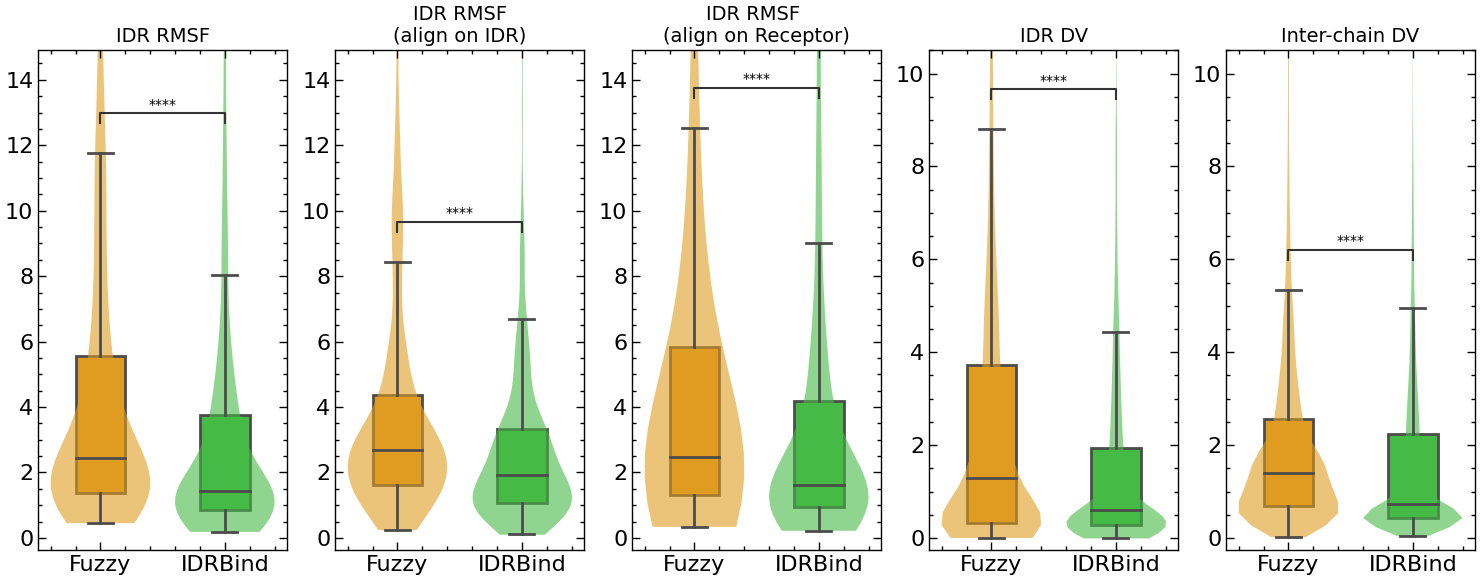

In [62]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
datasets = ['Fuzzy', 'IDRBind']
palette = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR]
for i, (df_tmp, measure, title, maxy) in enumerate(zip(
    [df_1d_idp, df_1d_idp, df_1d_idp, df_2d_idp, df_2d_inter],
    ['idp_rmsf', 'idp_rmsf_align_idp', 'idp_rmsf_align_receptor', 'dv_idp', 'dv_inter'],
    ['IDR RMSF', 'IDR RMSF\n(align on IDR)', 'IDR RMSF \n(align on Receptor)', 'IDR DV', 'Inter-chain DV'],
    [14.9, 14.9, 14.9, 10.5, 10.5],
)):
    g = sns.violinplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False, order=datasets,
                    palette=palette, inner=None, linewidth=0, cut=0, scale='width')
    plt.setp(g.collections, alpha=0.6)
    g = sns.boxplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False,
                    palette=palette, order=datasets, zorder=2, width=0.4)
    g.set_ylabel('')
    # g.set_yscale('log')
    g.set_title(title, fontsize=14)
    g.set_ylim(-maxy/40, maxy)
    g.set_xlabel('')

    pairs = [(datasets[0], datasets[1])]
    annotator = Annotator(g, pairs, x='dataset', y=measure, verbose=2, data=df_tmp, order=datasets)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
    annotator.apply_and_annotate()

plt.tight_layout()
fig.savefig('../figures/rmsf_dv_idr_fuzzy_idrbind.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

idp_rmsf_align_idp vs. idp_rmsf_align_idp_af: Mann-Whitney-Wilcoxon test two-sided, P_val:2.530e-66 U_stat=2.609e+06
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

receptor_rmsf_align_receptor vs. receptor_rmsf_align_receptor_af: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.854e+07


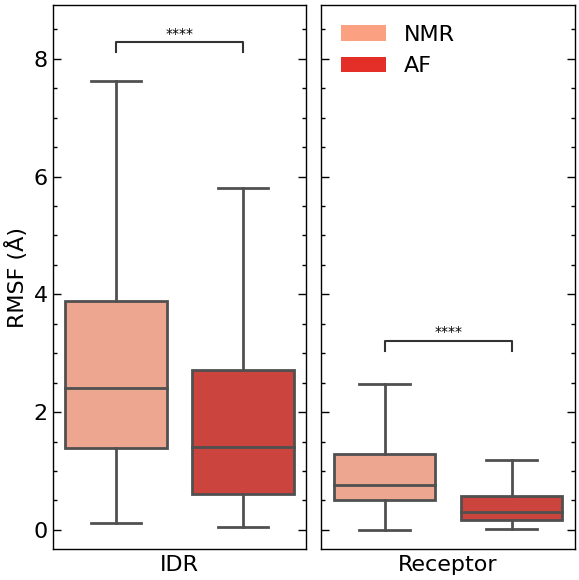

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6), sharey=True)
df_tmp = df_1d_idp.melt(id_vars=['dataset'], value_vars=['idp_rmsf_align_idp', 'idp_rmsf_align_idp_af'], var_name='rmsf_type', value_name='rmsf')
g = sns.boxplot(x='rmsf_type', y='rmsf',  data=df_tmp, showfliers=False, ax=ax[0], palette='Reds')
g.set_xticks([])
g.set_ylabel('RMSF (Å)')
g.set_xlabel('IDR')

pairs = [('idp_rmsf_align_idp', 'idp_rmsf_align_idp_af')]
annotator = Annotator(g, pairs, x='rmsf_type', y='rmsf', verbose=2, data=df_tmp)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
annotator.apply_and_annotate()

df_tmp = df_1d_receptor.melt(id_vars=['dataset'], value_vars=['receptor_rmsf_align_receptor', 'receptor_rmsf_align_receptor_af'], var_name='rmsf_type', value_name='rmsf')
g = sns.boxplot(x='rmsf_type', y='rmsf', data=df_tmp, showfliers=False, ax=ax[1], palette='Reds')
g.set_xticks([])
g.set_ylabel('')
g.set_xlabel('Receptor')
# legend, titles = [NMR, AF], using rectangles
g.legend([Patch(facecolor=sns.color_palette('Reds', 2)[0], edgecolor='none'), Patch(facecolor=sns.color_palette('Reds', 2)[1], edgecolor='none')],
         ['NMR', 'AF'], loc='upper left')

pairs = [('receptor_rmsf_align_receptor', 'receptor_rmsf_align_receptor_af')]
annotator = Annotator(g, pairs, x='rmsf_type', y='rmsf', verbose=2, data=df_tmp)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
annotator.apply_and_annotate()

plt.tight_layout()
fig.savefig('../figures/rmsf_idp_receptor_nmr_af.pdf', bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:2.207e-25 U_stat=6.024e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:1.554e-17 U_stat=5.788e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:3.555e-14 U_stat=5.669e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p

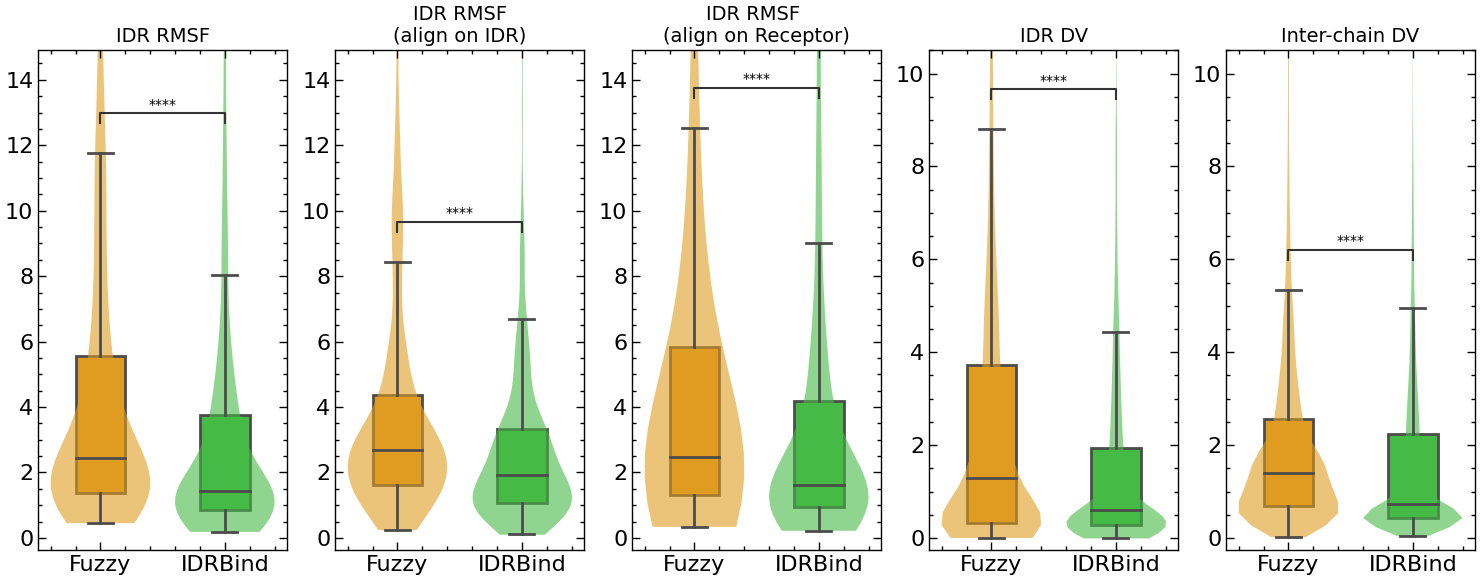

In [64]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
datasets = ['Fuzzy', 'IDRBind']
palette = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR]
for i, (df_tmp, measure, title, maxy) in enumerate(zip(
    [df_1d_idp, df_1d_idp, df_1d_idp, df_2d_idp, df_2d_inter],
    ['idp_rmsf', 'idp_rmsf_align_idp', 'idp_rmsf_align_receptor', 'dv_idp', 'dv_inter'],
    ['IDR RMSF', 'IDR RMSF\n(align on IDR)', 'IDR RMSF \n(align on Receptor)', 'IDR DV', 'Inter-chain DV'],
    [14.9, 14.9, 14.9, 10.5, 10.5],
)):
    g = sns.violinplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False, order=datasets,
                    palette=palette, inner=None, linewidth=0, cut=0, scale='width')
    plt.setp(g.collections, alpha=0.6)
    g = sns.boxplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False,
                    palette=palette, order=datasets, zorder=2, width=0.4)
    g.set_ylabel('')
    # g.set_yscale('log')
    g.set_title(title, fontsize=14)
    g.set_ylim(-maxy/40, maxy)
    g.set_xlabel('')

    pairs = [(datasets[0], datasets[1])]
    annotator = Annotator(g, pairs, x='dataset', y=measure, verbose=2, data=df_tmp, order=datasets)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
    annotator.apply_and_annotate()

plt.tight_layout()
fig.savefig('../figures/rmsf_dv_idr_fuzzy_idrbind.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:4.743e-118 U_stat=1.627e+11


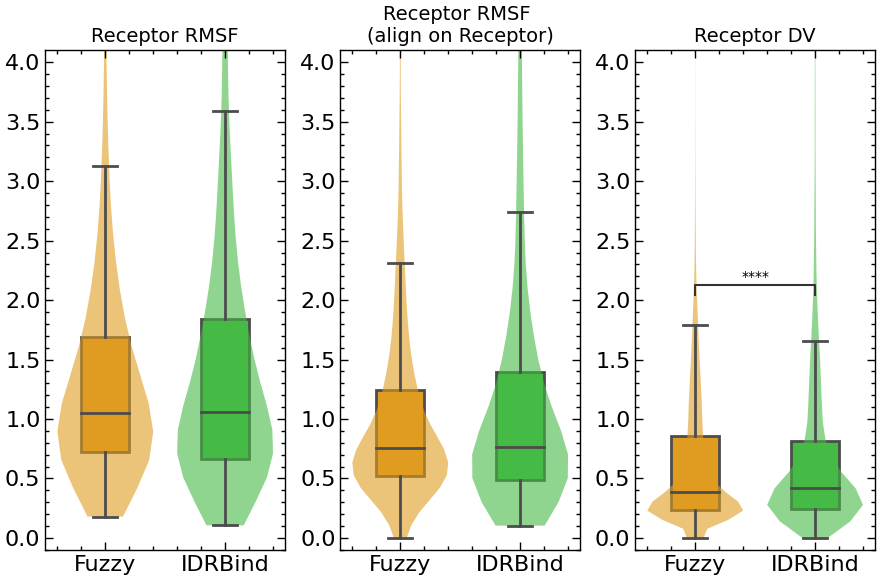

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(9, 6))
datasets = ['Fuzzy', 'IDRBind']
palette = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR]
for i, (df_tmp, measure, title, maxy) in enumerate(zip(
    [df_1d_receptor, df_1d_receptor, df_2d_receptor],
    ['receptor_rmsf', 'receptor_rmsf_align_receptor', 'dv_receptor'],
    ['Receptor RMSF', 'Receptor RMSF \n(align on Receptor)', 'Receptor DV'],
    [4.1, 4.1, 4.1],
)):
    g = sns.violinplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False, order=datasets,
                    palette=palette, inner=None, linewidth=0, cut=0, scale='width')
    plt.setp(g.collections, alpha=0.6)
    g = sns.boxplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False,
                    palette=palette, order=datasets, zorder=2, width=0.4)
    g.set_ylabel('')
    # g.set_yscale('log')
    g.set_title(title, fontsize=14)
    g.set_ylim(-maxy/40, maxy)
    g.set_xlabel('')

    pairs = [(datasets[0], datasets[1])]
    annotator = Annotator(g, pairs, x='dataset', y=measure, verbose=2, data=df_tmp, order=datasets)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
    annotator.apply_and_annotate()

plt.tight_layout()
fig.savefig('../figures/rmsf_dv_receptor_fuzzy_idrbind.pdf', bbox_inches='tight')
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:2.207e-25 U_stat=6.024e+05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fuzzy vs. IDRBind: Mann-Whitney-Wilcoxon test two-sided, P_val:3.555e-14 U_stat=5.669e+05


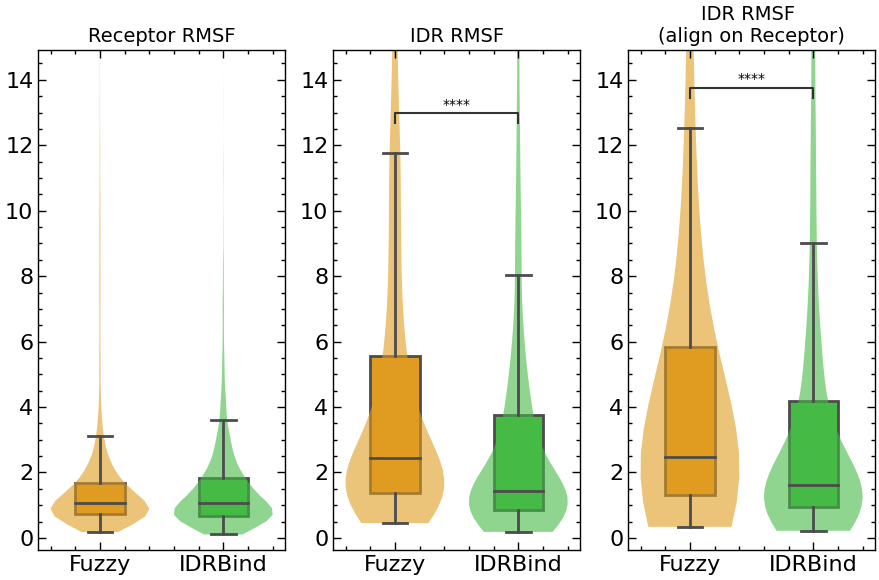

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(9, 6))
datasets = ['Fuzzy', 'IDRBind']
palette = [FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR]
for i, (df_tmp, measure, title, maxy) in enumerate(zip(
    [df_1d_receptor, df_1d_idp, df_1d_idp],
    ['receptor_rmsf', 'idp_rmsf', 'idp_rmsf_align_receptor'],
    ['Receptor RMSF', 'IDR RMSF', 'IDR RMSF \n(align on Receptor)'],
    [14.9, 14.9, 14.9],
)):
    g = sns.violinplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False, order=datasets,
                    palette=palette, inner=None, linewidth=0, cut=0, scale='width')
    plt.setp(g.collections, alpha=0.6)
    g = sns.boxplot(x='dataset', y=measure, data=df_tmp, ax=ax[i], showfliers=False,
                    palette=palette, order=datasets, zorder=2, width=0.4)
    g.set_ylabel('')
    # g.set_yscale('log')
    g.set_title(title, fontsize=14)
    g.set_ylim(-maxy/40, maxy)
    g.set_xlabel('')

    pairs = [(datasets[0], datasets[1])]
    annotator = Annotator(g, pairs, x='dataset', y=measure, verbose=2, data=df_tmp, order=datasets)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
    annotator.apply_and_annotate()

plt.tight_layout()
fig.savefig('../figures/rmsf_idr_receptor_fuzzy_idrbind.pdf', bbox_inches='tight')
plt.show()

---

In [56]:
df_truepdbstat = pd.read_csv('../data/fuzidp_uniprot_truepdbstat.csv')
df_pdbstat = pd.read_csv('../data/fuzidp_uniprot_pdbstat.csv')
df_truepdbstat_idrbind = pd.read_csv('../data/idrbind_uniprot_truepdbstat.csv')
df_pdbstat_idrbind = pd.read_csv('../data/idrbind_uniprot_pdbstat.csv')

In [57]:
df_truepdbstat = pd.wide_to_long(df_truepdbstat, stubnames=['Model_'], i=['pdb_id', 'idp_id', 'receptor_id', 'Metric', 'Averages'],
                j='Model').reset_index().rename(columns={'Model_': 'Value'})
df_pdbstat = pd.wide_to_long(df_pdbstat, stubnames=['Model_'], i=['pdb_id', 'idp_id', 'receptor_id', 'Metric', 'Averages'],
                j='Model').reset_index().rename(columns={'Model_': 'Value'})                
df_truepdbstat_idrbind = pd.wide_to_long(df_truepdbstat_idrbind, stubnames=['Model_'], i=['pdb_id', 'idp_id', 'receptor_id', 'Metric', 'Averages'],
                j='Model').reset_index().rename(columns={'Model_': 'Value'})
df_pdbstat_idrbind = pd.wide_to_long(df_pdbstat_idrbind, stubnames=['Model_'], i=['pdb_id', 'idp_id', 'receptor_id', 'Metric', 'Averages'],
                j='Model').reset_index().rename(columns={'Model_': 'Value'})

In [58]:
df_pdbstat = pd.concat([
    df_truepdbstat.assign(dataset='Fuzzy', subdataset='NMR'),
    df_pdbstat.assign(dataset='Fuzzy', subdataset='AF'),
    df_truepdbstat_idrbind.assign(dataset='IDRBind', subdataset='NMR'),
    df_pdbstat_idrbind.assign(dataset='IDRBind', subdataset='AF'),
], ignore_index=True)
print(df_pdbstat.shape)
df_pdbstat.head()

(49805, 9)


,pdb_id,idp_id,receptor_id,Metric,Averages,Model,Value,dataset,subdataset
0,2LPB,B,A,0.1 - 0.2 ang,6.46,1,6.0,Fuzzy,NMR
1,2LPB,B,A,0.1 - 0.2 ang,6.46,2,5.0,Fuzzy,NMR
2,2LPB,B,A,0.1 - 0.2 ang,6.46,3,10.0,Fuzzy,NMR
3,2LPB,B,A,0.1 - 0.2 ang,6.46,4,9.0,Fuzzy,NMR
4,2LPB,B,A,0.1 - 0.2 ang,6.46,5,4.0,Fuzzy,NMR


In [59]:
df_pdbstat = df_pdbstat[~(df_pdbstat['pdb_id'].isin(df_fuztoremove['pdb_id']) & df_pdbstat['dataset'].eq('Fuzzy'))]
print(df_pdbstat.shape)

(46880, 9)


In [60]:
error_pdb_ids = df_pdbstat[(df_pdbstat['Metric'] == 'Max. viol.') & (df_pdbstat['Value'] > 90)]['pdb_id'].unique()
error_pdb_ids

array(['2VDA', '1LXF', '6FGP', '2MH0', '1R8U', '2LXS', '2LQI', '1OZS',
       '1DT7', '2KQS', '2LB2', '1L3E', '2RSN', '2LAJ', '2K2U', '2CZY'],
      dtype=object)

In [61]:
df_pdbstat = df_pdbstat[~df_pdbstat['pdb_id'].isin(error_pdb_ids)]
print(df_pdbstat.shape)
df_pdbstat.head()

(30660, 9)


,pdb_id,idp_id,receptor_id,Metric,Averages,Model,Value,dataset,subdataset
0,2LPB,B,A,0.1 - 0.2 ang,6.46,1,6.0,Fuzzy,NMR
1,2LPB,B,A,0.1 - 0.2 ang,6.46,2,5.0,Fuzzy,NMR
2,2LPB,B,A,0.1 - 0.2 ang,6.46,3,10.0,Fuzzy,NMR
3,2LPB,B,A,0.1 - 0.2 ang,6.46,4,9.0,Fuzzy,NMR
4,2LPB,B,A,0.1 - 0.2 ang,6.46,5,4.0,Fuzzy,NMR


In [62]:
df['plddt_idp'] = df['plddt_idp'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['plddt_idp_mean'] = df['plddt_idp'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

In [63]:
df_tmp = df[df['recycle'].isna() & (df['exp'] == 'delim_idp') & (df['seed'] == 0) & (df['reference_model'] == 1)]
df_tmp = df_tmp[['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'seed_rank', 'dockq', 'capri_dockq', 'fnat', 'irms', 'lrms',
                'combined', 'iptm', 'ptm', 'plddt_idp_mean']]
df_pdbstat = pd.merge(df_pdbstat, df_tmp,
                      left_on=['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'Model'],
                      right_on=['pdb_id', 'idp_id', 'receptor_id', 'dataset', 'seed_rank'],
                      how='inner')
print(df_pdbstat.shape)
df_pdbstat.head()

(6440, 19)


,pdb_id,idp_id,receptor_id,Metric,Averages,Model,Value,dataset,subdataset,seed_rank,dockq,capri_dockq,fnat,irms,lrms,combined,iptm,ptm,plddt_idp_mean
0,2LPB,B,A,0.1 - 0.2 ang,6.460,1,6.0,Fuzzy,NMR,1.0,0.406,Acceptable,0.333,3.402,5.295,0.468,0.42,0.66,52.888235
1,2LPB,B,A,0.2 - 0.5 ang,4.770,1,4.0,Fuzzy,NMR,1.0,0.406,Acceptable,0.333,3.402,5.295,0.468,0.42,0.66,52.888235
2,2LPB,B,A,> 0.5 ang,4.000,1,5.0,Fuzzy,NMR,1.0,0.406,Acceptable,0.333,3.402,5.295,0.468,0.42,0.66,52.888235
3,2LPB,B,A,Total,33.850,1,30.0,Fuzzy,NMR,1.0,0.406,Acceptable,0.333,3.402,5.295,0.468,0.42,0.66,52.888235
4,2LPB,B,A,Max. viol.,3.662,1,1.1,Fuzzy,NMR,1.0,0.406,Acceptable,0.333,3.402,5.295,0.468,0.42,0.66,52.888235


In [64]:
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation') & (df_pdbstat['subdataset'] == 'AF')]
df_tmp.groupby(['dataset']).corr(method='spearman')

/tmp/ipykernel_2921950/258209362.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp.groupby(['dataset']).corr(method='spearman')


Averages     Model     Value  seed_rank     dockq  \
dataset                                                                     
Fuzzy   Averages        1.000000  0.000000  0.864475   0.000000 -0.518378   
        Model           0.000000  1.000000  0.109478   1.000000 -0.129290   
        Value           0.864475  0.109478  1.000000   0.109478 -0.551887   
        seed_rank       0.000000  1.000000  0.109478   1.000000 -0.129290   
        dockq          -0.518378 -0.129290 -0.551887  -0.129290  1.000000   
        fnat           -0.325539 -0.130376 -0.384304  -0.130376  0.817661   
        irms            0.485102  0.099498  0.549856   0.099498 -0.945218   
        lrms            0.532007  0.116131  0.515018   0.116131 -0.829501   
        combined       -0.374777 -0.273285 -0.422490  -0.273285  0.515149   
        iptm           -0.376033 -0.275355 -0.419529  -0.275355  0.492905   
        ptm            -0.243903 -0.192073 -0.336135  -0.192073  0.578308   
        plddt_idp_mean -0.071021 -0.189322 -0.192217  -0.189322  0.314820   
IDRBind Averages        1.000000  0.000000  0.937755   0.000000 -0.528925   
        Model           0.000000  1.000000  0.061245   1.000000 -0.152992   
        Value           0.937755  0.061245  1.000000   0.061245 -0.549483   
        seed_rank       0.000000  1.000000  0.061245   1.000000 -0.152992   
        dockq          -0.528925 -0.152992 -0.549483  -0.152992  1.000000   
        fnat           -0.497620 -0.177773 -0.515291  -0.177773  0.914173   
        irms            0.348067  0.162483  0.344700   0.162483 -0.907142   
        lrms            0.619225  0.132486  0.632152   0.132486 -0.921193   
        combined       -0.467616 -0.236029 -0.395382  -0.236029  0.649740   
        iptm           -0.486059 -0.232164 -0.413457  -0.232164  0.655760   
        ptm            -0.158822 -0.165694 -0.057207  -0.165694  0.323541   
        plddt_idp_mean -0.429800 -0.174481 -0.330738  -0.174481  0.661639   

                            fnat      irms      lrms  combined      iptm  \
dataset                                                                    
Fuzzy   Averages       -0.325539  0.485102  0.532007 -0.374777 -0.376033   
        Model          -0.130376  0.099498  0.116131 -0.273285 -0.275355   
        Value          -0.384304  0.549856  0.515018 -0.422490 -0.419529   
        seed_rank      -0.130376  0.099498  0.116131 -0.273285 -0.275355   
        dockq           0.817661 -0.945218 -0.829501  0.515149  0.492905   
        fnat            1.000000 -0.700825 -0.470343  0.578315  0.576252   
        irms           -0.700825  1.000000  0.778099 -0.380517 -0.351992   
        lrms           -0.470343  0.778099  1.000000 -0.446003 -0.419266   
        combined        0.578315 -0.380517 -0.446003  1.000000  0.996713   
        iptm            0.576252 -0.351992 -0.419266  0.996713  1.000000   
        ptm             0.499139 -0.544638 -0.486350  0.811165  0.776207   
        plddt_idp_mean  0.341419 -0.230421 -0.353458  0.652215  0.640199   
IDRBind Averages       -0.497620  0.348067  0.619225 -0.467616 -0.486059   
        Model          -0.177773  0.162483  0.132486 -0.236029 -0.232164   
        Value          -0.515291  0.344700  0.632152 -0.395382 -0.413457   
        seed_rank      -0.177773  0.162483  0.132486 -0.236029 -0.232164   
        dockq           0.914173 -0.907142 -0.921193  0.649740  0.655760   
        fnat            1.000000 -0.814592 -0.772311  0.600908  0.610325   
        irms           -0.814592  1.000000  0.786965 -0.557086 -0.558026   
        lrms           -0.772311  0.786965  1.000000 -0.660162 -0.665751   
        combined        0.600908 -0.557086 -0.660162  1.000000  0.996716   
        iptm            0.610325 -0.558026 -0.665751  0.996716  1.000000   
        ptm             0.284816 -0.331095 -0.358570  0.701457  0.661833   
        plddt_idp_mean  0.571319 -0.651334 -0.643776  0.597686  0.591716   

                             ptm  plddt_idp_

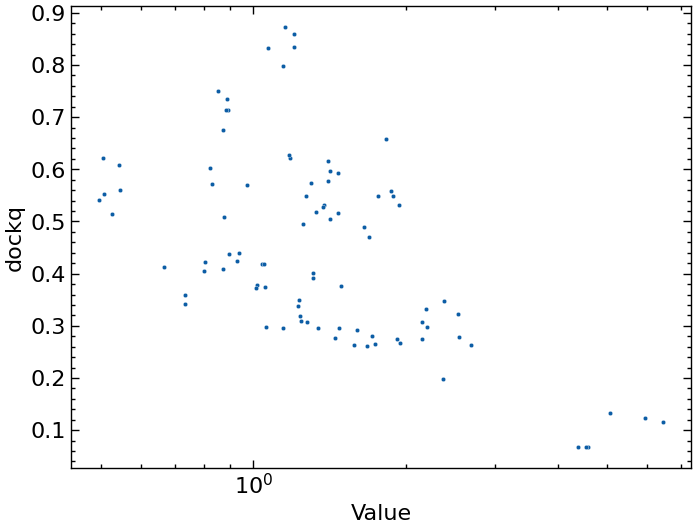

In [65]:
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation') & (df_pdbstat['subdataset'] == 'AF')]
g = sns.scatterplot(
    data=df_tmp[df_tmp['dataset'] == 'Fuzzy'],
    x='Value',
    y='dockq',
    s=10,
)
g.set_xscale('log')
plt.show()

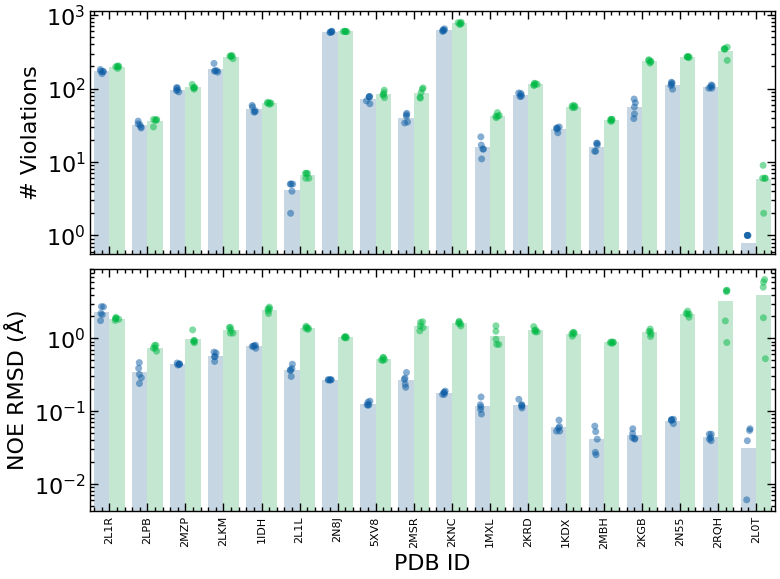

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# order
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation') & (df_pdbstat['dataset'] == 'Fuzzy')]
df_tmp = df_tmp.groupby(['subdataset', 'pdb_id'])['Value'].mean().reset_index()
df_tmp = df_tmp.pivot_table(index=['pdb_id'], columns=['subdataset'], values='Value').reset_index()
df_tmp['diff'] = df_tmp['AF'] / df_tmp['NMR']
# df_tmp = df_tmp.sort_values('AF', ascending=False)
df_tmp = df_tmp.sort_values('diff', ascending=True)
order = df_tmp['pdb_id'].tolist()

# Violations
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'Total') & (df_pdbstat['dataset'] == 'Fuzzy')]
g = sns.barplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.25,
    ci=None,
    ax=ax[0],
    order=order,
)
g = sns.stripplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.5,
    ax=ax[0],
    order=order,
)
g.set_yscale('log')
g.set_ylabel('# Violations')
g.set_xlabel('')
g.legend_.remove()

# RMSD
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation') & (df_pdbstat['dataset'] == 'Fuzzy')]
g = sns.barplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.25,
    ci=None,
    ax=ax[1],
    order=order,
)
g = sns.stripplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.5,
    s=5,
    ax=ax[1],
    order=order,
)
g.set_yscale('log')
g.set_ylabel('NOE RMSD (Å)')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
g.set_xlabel('PDB ID')
g.legend_.remove()

fig.tight_layout()
plt.show()

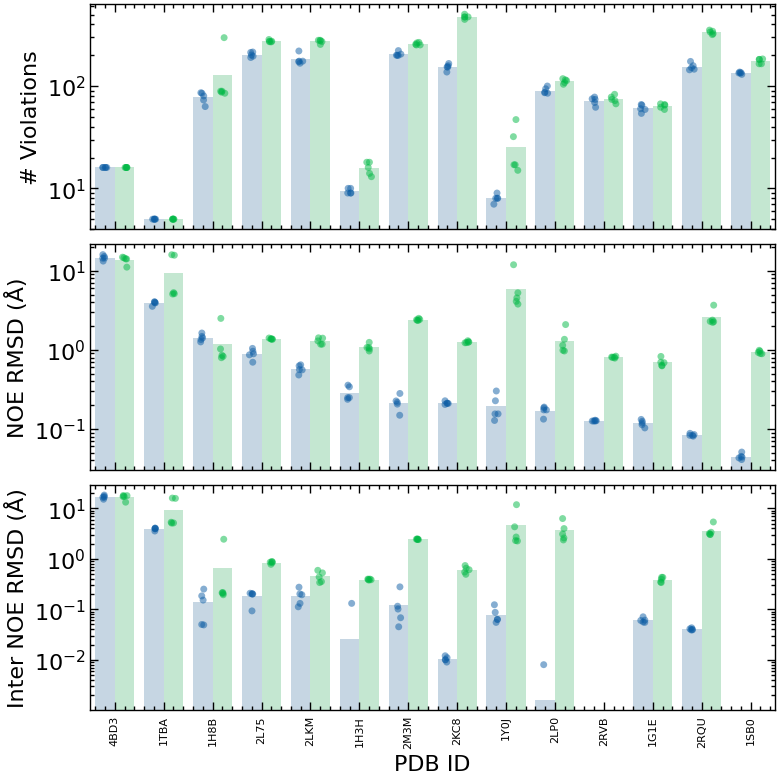

In [67]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# order
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation') & (df_pdbstat['dataset'] == 'IDRBind') & (df_pdbstat['subdataset'] == 'NMR')]
order = df_tmp.groupby('pdb_id')['Value'].mean().sort_values(ascending=False).index

# Violations
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'Total') & (df_pdbstat['dataset'] == 'IDRBind')]
g = sns.barplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.25,
    ci=None,
    ax=ax[0],
    order=order,
)
g = sns.stripplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.5,
    s=5,
    ax=ax[0],
    order=order,
)
g.set_yscale('log')
g.set_ylabel('# Violations')
g.set_xlabel('')
g.legend_.remove()

# RMSD
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation') & (df_pdbstat['dataset'] == 'IDRBind')]
# df_tmp = df_tmp.sort_values('Averages', ascending=False)
g = sns.barplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.25,
    ci=None,
    ax=ax[1],
    order=order,
)
g = sns.stripplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.5,
    ax=ax[1],
    order=order,
)
g.set_yscale('log')
g.set_ylabel('NOE RMSD (Å)')
g.set_xlabel('')
g.legend_.remove()

# RMSD Inter
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Inter') & (df_pdbstat['dataset'] == 'IDRBind')]
# df_tmp = df_tmp.sort_values('Averages', ascending=False)
g = sns.barplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.25,
    ci=None,
    ax=ax[2],
    order=order,
)
g = sns.stripplot(
    data=df_tmp,
    x='pdb_id',
    y='Value',
    hue='subdataset',
    dodge=True,
    alpha=0.5,
    ax=ax[2],
    order=order,
)
g.set_yscale('log')
g.set_ylabel('Inter NOE RMSD (Å)')
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
g.set_xlabel('PDB ID')
g.legend_.remove()

fig.tight_layout()
plt.show()

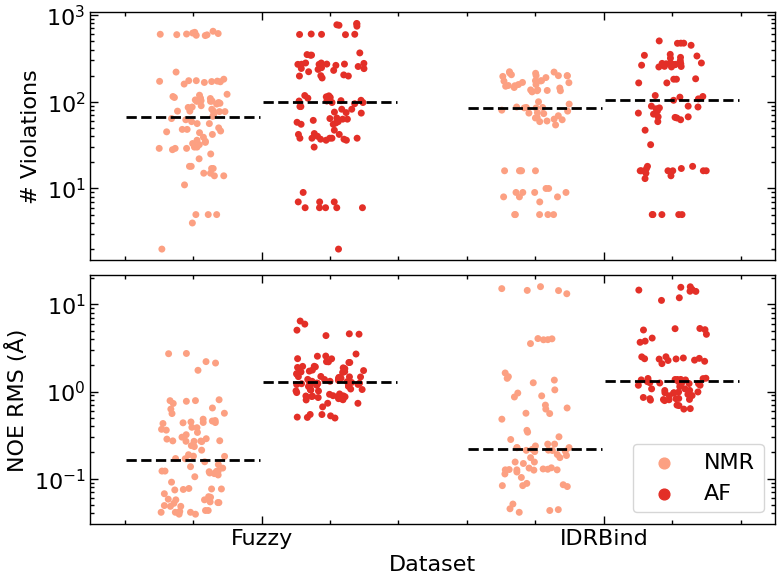

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
df_tmp=df_pdbstat[(df_pdbstat['Metric'] == 'Total')]
g = sns.boxplot(
    data=df_tmp,
    x='dataset',
    y='Value',
    hue='subdataset',
    medianprops=dict(color='black', linewidth=2, linestyle='--'),
    showfliers=False,
    ax=ax[0],
    showbox=False,
    showcaps=False,
    whis=False,
    dodge=True,
    zorder=100,
)
g.legend_.remove()
g = sns.stripplot(
    data=df_tmp,
    x='dataset',
    y='Value',
    hue='subdataset',
    dodge=True,
    jitter=0.2,
    ax=ax[0],
    palette='Reds',
)
g.set_yscale('log')
g.set_ylabel('# Violations')
g.set_xlabel('')
g.legend_.remove()

df_tmp=df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation')]
g = sns.boxplot(
    data=df_tmp,
    x='dataset',
    y='Value',
    hue='subdataset',
    medianprops=dict(color='black', linewidth=2, linestyle='--'),
    showfliers=False,
    ax=ax[1],
    showbox=False,
    showcaps=False,
    whis=False,
    dodge=True,
    zorder=100,
)
g.legend_.remove()
g = sns.stripplot(
    data=df_tmp,
    x='dataset',
    y='Value',
    hue='subdataset',
    dodge=True,
    jitter=0.2,
    ax=ax[1],
    palette='Reds',
)
g.set_yscale('log')
g.set_ylabel('NOE RMS (Å)')
g.set_xlabel('Dataset')
g.legend_.remove()

handles, labels = g.get_legend_handles_labels()
g.legend(handles[-2:], labels[-2:], title='', loc='lower right', frameon=True)

fig.tight_layout()

fig.savefig('../figures/violations_rmsd.pdf', bbox_inches='tight')
plt.show()

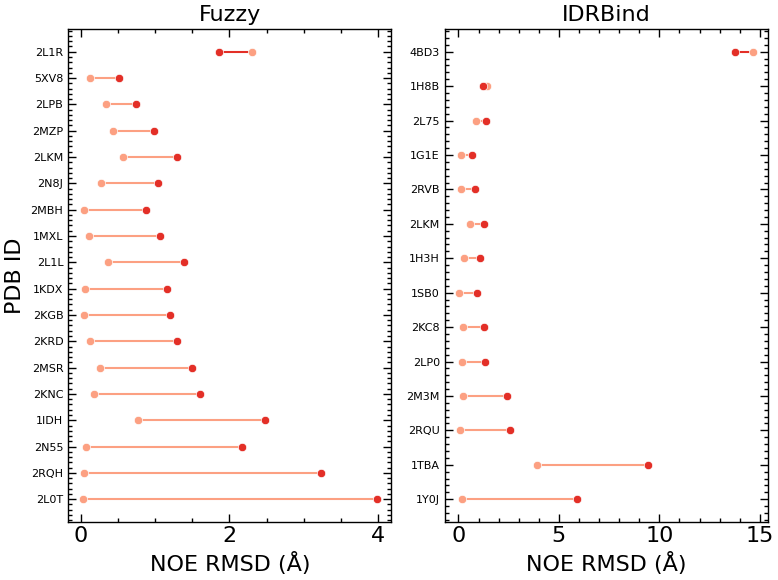

In [69]:
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation')]
df_tmp = df_tmp.groupby(['dataset', 'subdataset', 'pdb_id'])['Value'].mean().reset_index()
df_tmp = df_tmp.pivot_table(index=['dataset', 'pdb_id'], columns=['subdataset'], values='Value').reset_index()
df_tmp['diff'] = df_tmp['AF'] - df_tmp['NMR']
df_tmp = df_tmp.sort_values('AF', ascending=False)
df_tmp = df_tmp.sort_values('diff', ascending=False)
# df_tmp = df_tmp.sort_values('NMR', ascending=True)
df_tmp = df_tmp.reset_index(drop=True)

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
df_tmp2 = df_tmp[df_tmp['dataset'] == 'Fuzzy'].reset_index(drop=True)
pal = sns.color_palette('Reds', 2)
colors = [pal[0] if x['NMR'] - x['AF'] <= 0 else pal[1] for _, x in df_tmp2.iterrows()]
ax[0].hlines(y=df_tmp2.index, xmin=df_tmp2['NMR'], xmax=df_tmp2['AF'], color=colors, alpha=1, zorder=-100, linewidth=1.5)
g = sns.scatterplot(
    data=df_tmp2,
    x='NMR',
    y=df_tmp2.index,
    color=sns.color_palette('Reds', 2)[0],
    ax=ax[0],
)
g = sns.scatterplot(
    data=df_tmp2,
    x='AF',
    y=df_tmp2.index,
    color=sns.color_palette('Reds', 2)[1],
    ax=ax[0],
)
# g.set_xscale('log')
g.set_xlabel('NOE RMSD (Å)')
# g.set_xlim(df_tmp2['NMR'].min()-0.2, df_tmp2['AF'].max()*1.5)
g.set_yticks(df_tmp2.index, df_tmp2['pdb_id'], fontsize=8);
g.set_title('Fuzzy')
g.set_ylabel('PDB ID')

df_tmp2 = df_tmp[df_tmp['dataset'] == 'IDRBind'].reset_index(drop=True)
colors = [pal[0] if x['NMR'] - x['AF'] <= 0 else pal[1] for _, x in df_tmp2.iterrows()]
ax[1].hlines(y=df_tmp2.index, xmin=df_tmp2['NMR'], xmax=df_tmp2['AF'], color=colors, alpha=1, zorder=-100, linewidth=1.5)
g = sns.scatterplot(
    data=df_tmp2,
    x='NMR',
    y=df_tmp2.index,
    color=sns.color_palette('Reds', 2)[0],
    ax=ax[1],
)
g = sns.scatterplot(
    data=df_tmp2,
    x='AF',
    y=df_tmp2.index,
    color=sns.color_palette('Reds', 2)[1],
    ax=ax[1],
)
# g.set_xscale('symlog')
g.set_xlabel('NOE RMSD (Å)')
# g.set_xlim(df_tmp2['NMR'].min()-0.2, df_tmp2['AF'].max()*1.5)
g.set_yticks(df_tmp2.index, df_tmp2['pdb_id'], fontsize=8);
g.set_title('IDRBind')

fig.tight_layout()
plt.show()

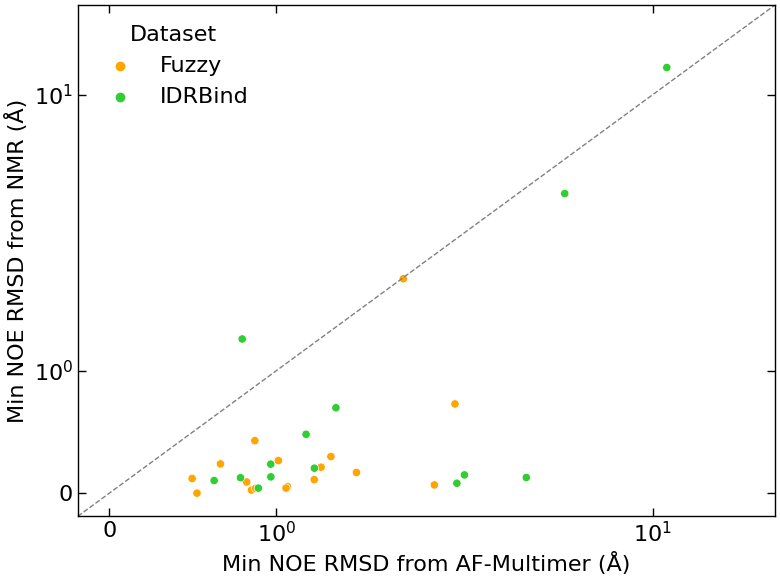

In [70]:
df_tmp = df_pdbstat[(df_pdbstat['Metric'] == 'RMS Violation')]
df_tmp = df_tmp.groupby(['dataset', 'subdataset', 'pdb_id'])['Value'].min().reset_index()
df_tmp = df_tmp.pivot_table(index=['dataset', 'pdb_id'], columns=['subdataset'], values='Value').reset_index()

fig, ax = plt.subplots(figsize=(8, 6))
g = sns.scatterplot(
    data=df_tmp,
    x='AF',
    y='NMR',
    hue='dataset',
    ax=ax,
    hue_order=['Fuzzy', 'IDRBind'],
    palette=[FUZZY_DATASET_COLOR, IDRBIND_DATASET_COLOR],
)
g.set_xscale('symlog')
g.set_yscale('symlog')
g.set_xlabel('Min NOE RMSD from AF-Multimer (Å)')
g.set_ylabel('Min NOE RMSD from NMR (Å)')
g.axline((0, 0), (20, 20), color='grey', linestyle='--', linewidth=1)
# g.set(ylim=(None, 49), xlim=(None, 49))
plt.legend(title='Dataset')

# annotate top left points
textlist = []
for i, row in df_tmp.iterrows():
    if row['AF'] - row['NMR'] < -5e-1:
        textlist.append([row['AF'], row['NMR'], row['pdb_id']])
        
fig.tight_layout()

# textalloc.allocate_text(
#     fig,
#     ax,
#     [x[0] for x in textlist],
#     [x[1] for x in textlist],
#     [x[2] for x in textlist],
#     x_scatter=g.get_xlim(),
#     y_scatter=g.get_ylim(),
#     textsize=11,
#     draw_lines=False,
#     min_distance=0.005,
#     max_distance=0.01,
# )

fig.savefig('../figures/min_noe_rmsd_scatter.pdf', bbox_inches='tight')
plt.show()

In [71]:
# pdb_ids_to_remove = ['2KWO']
# df = df[~df['pdb_id'].isin(pdb_ids_to_remove)]
# df.shape

In [72]:
df.groupby(['dataset', 'exp'])[['rank', 'seed_rank']].corr()

rank  seed_rank
dataset     exp                                 
Bret et al. delim_idp rank        1.0        1.0
                      seed_rank   1.0        1.0
Decoys      delim_idp rank        1.0        1.0
                      seed_rank   1.0        1.0
Fuzzy       delim_idp rank        1.0        1.0
                      seed_rank   1.0        1.0
IDRBind     delim_idp rank        1.0        1.0
                      seed_rank   1.0        1.0
Rg          delim_idp rank        1.0        1.0
                      seed_rank   1.0        1.0
Rg+ID       delim_idp rank        1.0        1.0
                      seed_rank   1.0        1.0

In [120]:
df_tmp[df_tmp['dataset'] == 'Fuzzy']['pdb_id'].nunique()

37

In [114]:
datasets = ['Fuzzy', 'IDRBind']
df_tmp = df[(df['recycle'].isna()) & (df['exp'] == 'delim_idp') & (df['seed'] == 0) & (df['dataset'].isin(datasets))]
df_tmp_maxdockq = df_tmp.loc[df_tmp.groupby(['pdb_id', 'idp_id', 'receptor_id', 'exp', 'dataset', 'rank', 'seed', 'model', 'model_name'], dropna=False)['dockq'].idxmax()]
df_tmp_maxgtdockq = df_tmp.loc[df_tmp.groupby(['pdb_id', 'idp_id', 'receptor_id', 'exp', 'dataset', 'reference_model'], dropna=False)['dockq'].idxmax()]
df_tmp_bestrankmaxdockq = df_tmp.loc[df_tmp.groupby(['pdb_id', 'idp_id', 'receptor_id', 'exp', 'dataset', 'rank', 'seed', 'model', 'model_name'], dropna=False)['dockq'].idxmax()]
df_tmp_bestrankmaxdockq = df_tmp_bestrankmaxdockq[(df_tmp_bestrankmaxdockq['seed_rank'] == 1) & (df_tmp_bestrankmaxdockq['seed'] == 0)]
df_tmp = pd.concat([
    df_tmp[(df_tmp['seed_rank'] == 1) & (df_tmp['reference_model'] == 1)].assign(protocol='Standard'),
    df_tmp_bestrankmaxdockq.assign(protocol='Max\nDockQ'),
    df_tmp_maxdockq.assign(protocol='Precision'),
    df_tmp_maxgtdockq.assign(protocol='Recall'),
], ignore_index=True)
df_tmp

,pdb_id,idp_id,receptor_id,relaxed,rank,model_name,model,seed,recycle,reference_model,...,idp_rmsf_align_idp_af,receptor_rmsf_align_idp_af,idp_rmsf_align_receptor_af,receptor_rmsf_align_receptor_af,dv_idp_residue_ids_af,dv_receptor_residue_ids_af,dataset_af,exp_af,plddt_idp_mean,protocol
0,2LPB,B,A,False,1,alphafold2_multimer_v2,5.0,0,NaN,1.0,...,"[2.4881298542022705, 2.2131898403167725, 2.361...","[6.373945713043213, 5.393565654754639, 5.06458...","[7.167209625244141, 6.47003698348999, 5.712983...","[2.9395017623901367, 2.2965264320373535, 1.889...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,52.888235,Standard
1,1KDX,B,A,False,1,alphafold2_multimer_v2,3.0,0,NaN,1.0,...,"[0.5069566369056702, 0.3874449133872986, 0.368...","[1.7623697519302368, 1.7712185382843018, 1.588...","[1.6732209920883179, 1.4281058311462402, 1.230...","[0.9042866826057434, 0.5225505232810974, 0.571...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,88.493214,Standard
2,2KJE,B,A,False,1,alphafold2_multimer_v2,1.0,0,NaN,1.0,...,"[10.399741172790527, 8.181036949157715, 6.2920...","[18.38439178466797, 15.595551490783691, 14.544...","[11.55700397491455, 11.865933418273926, 12.060...","[1.3999924659729004, 1.2320514917373657, 1.010...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,61.113810,Standard
3,2LWW,B,A,False,1,alphafold2_multimer_v2,2.0,0,NaN,1.0,...,"[10.414929389953613, 9.581012725830078, 9.0443...","[6.5025529861450195, 6.25172758102417, 4.79063...","[16.116987228393555, 15.167434692382812, 14.22...","[2.8978521823883057, 2.4940338134765625, 1.501...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,52.051857,Standard
4,2LXS,B,A,False,1,alphafold2_multimer_v2,4.0,0,NaN,1.0,...,"[2.3433759212493896, 1.1613621711730957, 1.447...","[16.31722640991211, 17.693416595458984, 19.874...","[7.266795635223389, 7.8689422607421875, 6.1379...","[0.40859660506248474, 0.3072725236415863, 0.26...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,74.267895,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,6.0,...,"[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,28.946667,Recall
2185,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,7.0,...,"[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,28.946667,Recall
2186,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,8.0,...,"[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Fuzzy,delim_idp,28.946667,Recall
2187,6FGP,A,B,False,5,alphafold2_multimer_v2,5.0,0,NaN,9.0,...,"[5.00747537612915, 6.0599751472473145, 4.22270...","[27.21878433227539, 24.181640625, 22.984270095...","[25.959482192993164, 23.85016632080078, 20.993...","[3.4108450412750244, 3.403870105743408, 3.5605...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

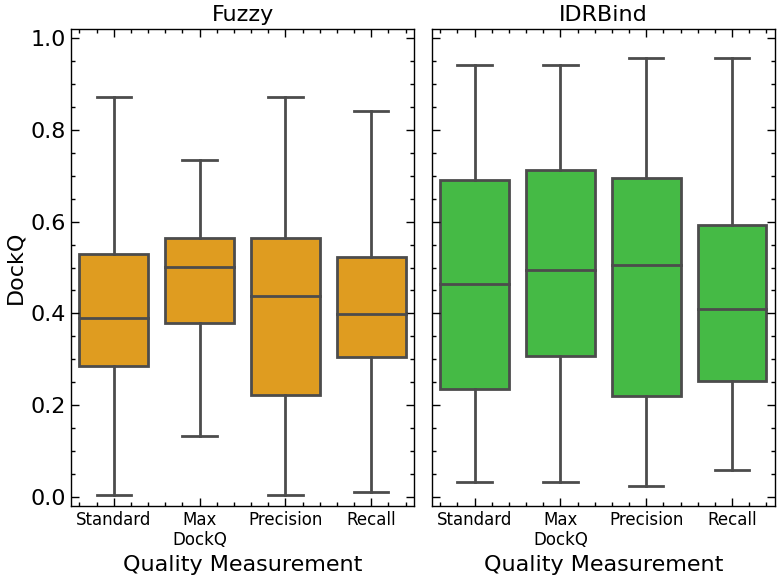

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
order=['Standard', 'Max\nDockQ', 'Precision', 'Recall']
g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == 'Fuzzy'],
                x='protocol', y='dockq', ax=ax[0], order=order, showfliers=False, color=FUZZY_DATASET_COLOR)
g.set(xlabel='Quality Measurement', ylabel='DockQ', ylim=(-0.02, 1.02))
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_title('Fuzzy')

pairs = [
    ('Standard', 'Precision'),
    ('Standard', 'Recall'),
    ('Precision', 'Recall'),
    ('Standard', 'BestRank'),
    ('Precision', 'BestRank'),
    ('Recall', 'BestRank'),
]

# annotator = Annotator(g, pairs, x='protocol', y='dockq', verbose=2, data=df_tmp, order=order)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2, hide_non_significant=True)

g = sns.boxplot(data=df_tmp[df_tmp['dataset'] == 'IDRBind'],
                x='protocol', y='dockq', ax=ax[1], order=order, showfliers=False, color=IDRBIND_DATASET_COLOR)
g.set(xlabel='Quality Measurement', ylabel='')
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_title('IDRBind')

pairs = [
    ('Standard', 'Precision'),
    ('Standard', 'Recall'),
    ('Precision', 'Recall'),
    ('Standard', 'BestRank'),
    ('Precision', 'BestRank'),
    ('Recall', 'BestRank'),
]

plt.tight_layout()
fig.savefig('../figures/fuzzy_dockq_protocol_comparison.pdf', bbox_inches='tight')
plt.show()

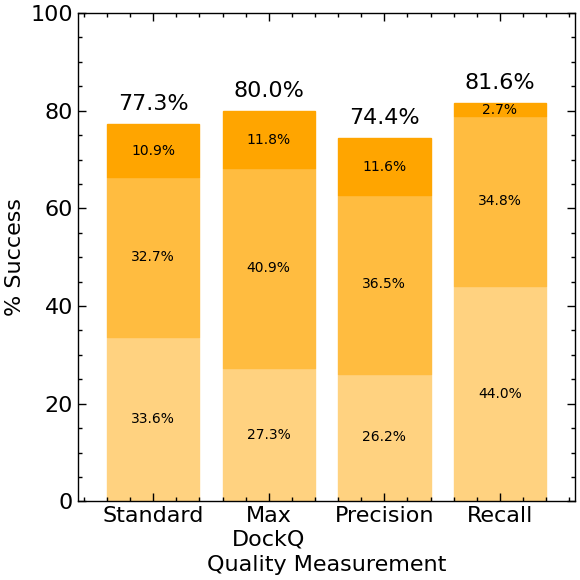

In [117]:
fig, ax = plt.subplots(figsize=(6, 6))
(df_tmp
 .groupby('protocol')['capri_dockq']
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pivot(index='protocol', columns='capri_dockq', values='percent')[CAPRI_CLASSES[1:]]
    .reindex(CAPRI_CLASSES[1:], axis=1)
    .reindex(order, axis=0)
    .plot(kind='bar', stacked=True, rot=0, legend=False, ax=ax, width=0.8)
)

plt.xlabel('Quality Measurement')
plt.ylabel('% Success')
# plt.xticks([0, 1], ['Full IDP', 'Delimited IDP'])
plt.ylim(0, 100)

# set palettes
for i, bar in enumerate(plt.gca().patches):
    bar.set_color(CAPRI_COLORS_FUZZY[i//len(order)+1])

# text on top of bars with percentage
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    # color = 'white' if get_luminance(p.get_facecolor()) <= 0.7 else 'black'  # Choose color based on luminance
    plt.gca().annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', color='k', fontsize=10)

x_sum = {}
for p in plt.gca().patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    x_sum[x] = x_sum.get(x, 0) + height
for p in plt.gca().patches[-len(order):]:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.gca().annotate(f'{x_sum[x]:.1f}%', (x + width / 2, y + height+2), ha='center', va='bottom', color='k', fontsize=16)

# legend
# high_handle = object()
# medium_handle = object()
# acceptable_handle = object()
# pals = [CAPRI_COLORS_FUZZY]
# ax.legend(
#     title='',
#     handles=[acceptable_handle, medium_handle, high_handle],
#     handler_map={
#         high_handle: MultipleRectanglesHandler([pal[3] for pal in pals]),
#         medium_handle: MultipleRectanglesHandler([pal[2] for pal in pals]),
#         acceptable_handle: MultipleRectanglesHandler([pal[1] for pal in pals]),
#     },
#     labels=['Acceptable', 'Medium', 'High'],
#     # loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True
# )
    
plt.tight_layout()
fig.savefig('../figures/fuzzy_capri_protocol_comparison.pdf', bbox_inches='tight')
plt.show()

In [29]:
df = df[(df['seed_rank'] == 1) & (df['reference_model'] == 1) & (df['dataset'] == 'Fuzzy') & (df['recycle'].isna())]
print(df.shape)

(37, 94)


In [33]:
df[(df['seed_rank'] == 1) & (df['exp'] == 'delim_idp')]['pdb_id']

104      2LPB
427      1KDX
870      2KJE
1330     2LWW
1810     2LXS
2370     1ZSG
2880     2PHG
3286     1YX6
3820     2LQI
4280     2KWO
4780     2N8J
5280     2N55
5760     2VDA
6020     2KGB
6530     2L1R
7040     1OZS
7630     2MZP
8260     2KRD
8440     1LXG
9070     1MXL
9870     1IDH
10570    1LXF
11090    2L1L
11530    1EES
11910    2KWJ
12490    2KNC
13030    1S5R
13390    6FGP
13720    2MSR
14050    2L0T
14510    2MBH
15010    2KWK
15490    2MH0
16030    1R8U
16430    2RQH
17110    5XV8
17490    2LKM
Name: pdb_id, dtype: object

In [34]:
idx = df[(df['pdb_id'] == '2LQI')].index[0]
idx

3820

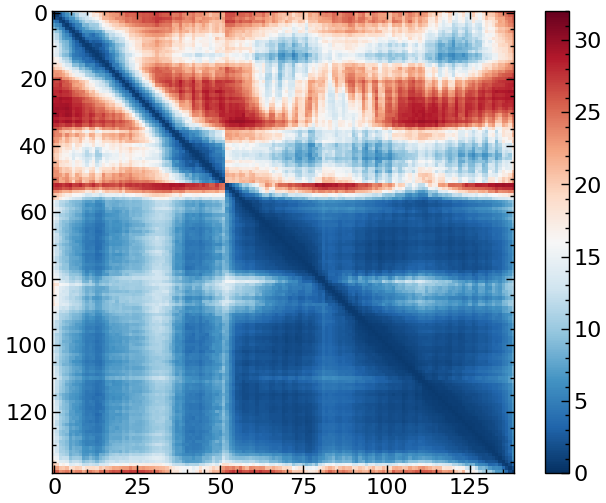

In [35]:
pae = np.concatenate([
    np.concatenate([df['pae_idp_idp_raw'].loc[idx], df['pae_idp_receptor_raw'].loc[idx]], axis=1),
    np.concatenate([df['pae_receptor_idp_raw'].loc[idx], df['pae_receptor_receptor_raw'].loc[idx]], axis=1)
], axis=0)
plt.imshow(pae, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()

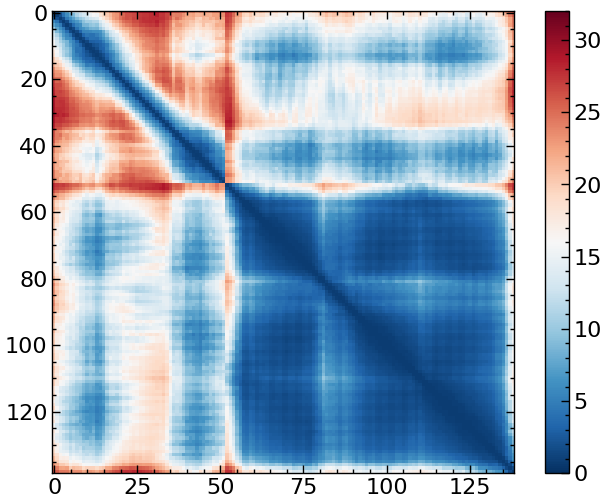

In [37]:
pae = np.concatenate([
    np.concatenate([df['pae_idp_idp_raw'].loc[idx], df['pae_idp_receptor_raw'].loc[idx]], axis=1),
    np.concatenate([df['pae_receptor_idp_raw'].loc[idx], df['pae_receptor_receptor_raw'].loc[idx]], axis=1)
], axis=0)
pae = (pae + pae.T) / 2
plt.imshow(pae, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()

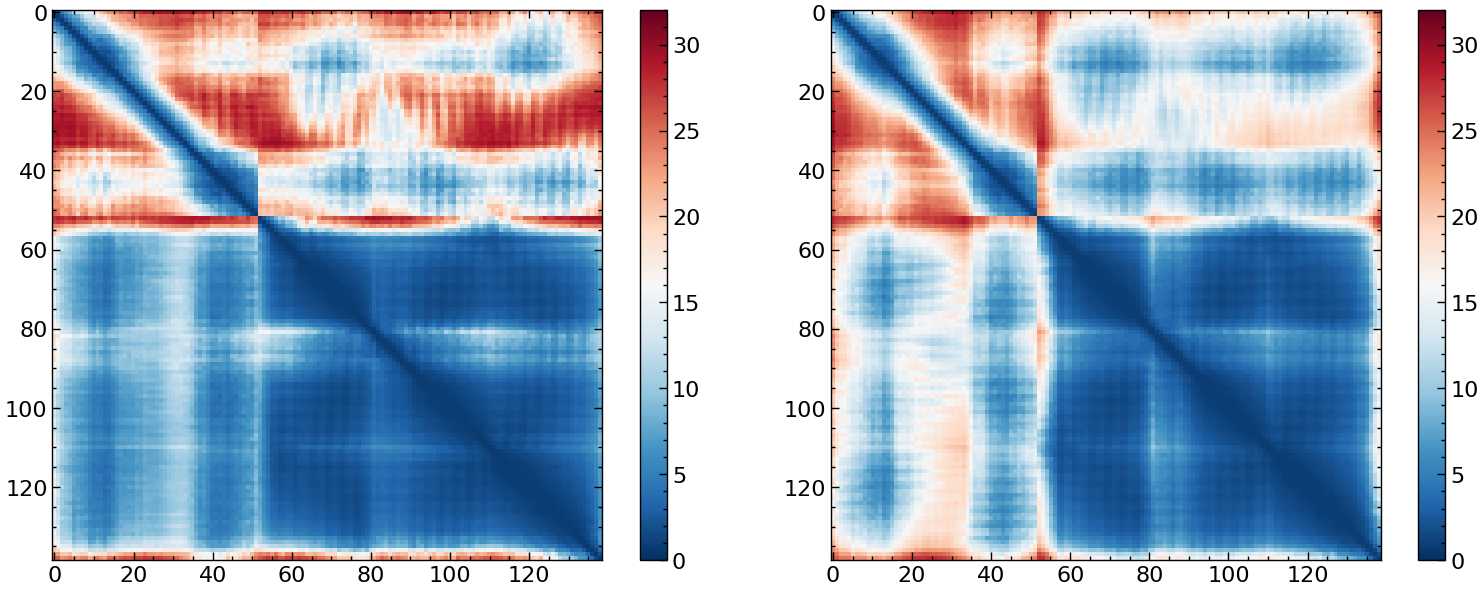

In [38]:
# idp_ids, idp_mask = map_range(df['dv_idp_residue_ids'][idx], df['idp_uniprot'][idx].split(';')[0])
idp_ids = df['dv_idp_residue_ids'].loc[idx]
receptor_ids = df['dv_receptor_residue_ids'].loc[idx]
# idp_af_ids, _ = map_range(np.arange(1, len(df['plddt_idp'].loc[idx])+1),
#                 df['idp_uniprot'][idx].split(';')[0])
# idp_start, idp_end = map(int, df['merged_idp_fuzzy_residues'][idx].split('-'))
# idp_start, idp_end = min(idp_ids), max(idp_ids)
# idp_start = 1

pae_idp_idp = df['pae_idp_idp_raw'].loc[idx][idp_ids-1][:, idp_ids-1]
pae_idp_receptor = df['pae_idp_receptor_raw'].loc[idx][idp_ids-1][:, receptor_ids-1]
pae_receptor_idp = df['pae_receptor_idp_raw'].loc[idx][receptor_ids-1][:, idp_ids-1]
pae_receptor_receptor = df['pae_receptor_receptor_raw'].loc[idx][receptor_ids-1][:, receptor_ids-1]

pae = np.concatenate([
    np.concatenate([pae_idp_idp, pae_idp_receptor], axis=1),
    np.concatenate([pae_receptor_idp, pae_receptor_receptor], axis=1)
], axis=0)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(pae, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow((pae + pae.T) / 2, cmap='RdBu_r', vmin=0, vmax=32)
plt.colorbar()
plt.tight_layout()

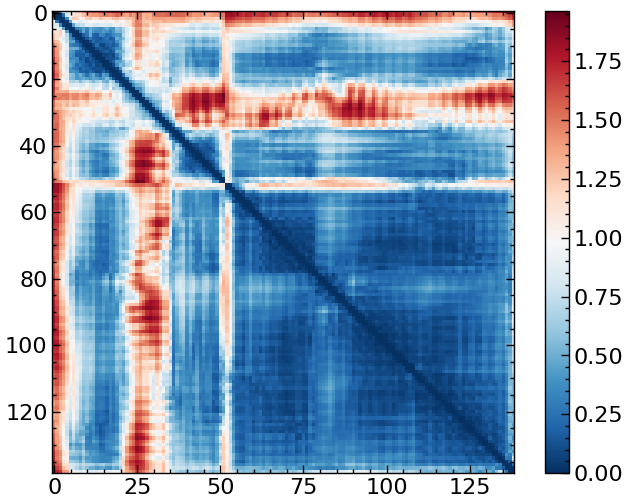

In [39]:
idp_dv = df['idp_dv'].loc[idx]
receptor_dv = df['receptor_dv'].loc[idx]
idp_receptor_dv = df['idp_receptor_dv'].loc[idx]
dv = np.concatenate([
    np.concatenate([idp_dv, idp_receptor_dv], axis=1),
    np.concatenate([idp_receptor_dv.T, receptor_dv], axis=1)
], axis=0)
plt.imshow(np.log1p(dv), cmap='RdBu_r', vmin=0)
plt.colorbar()

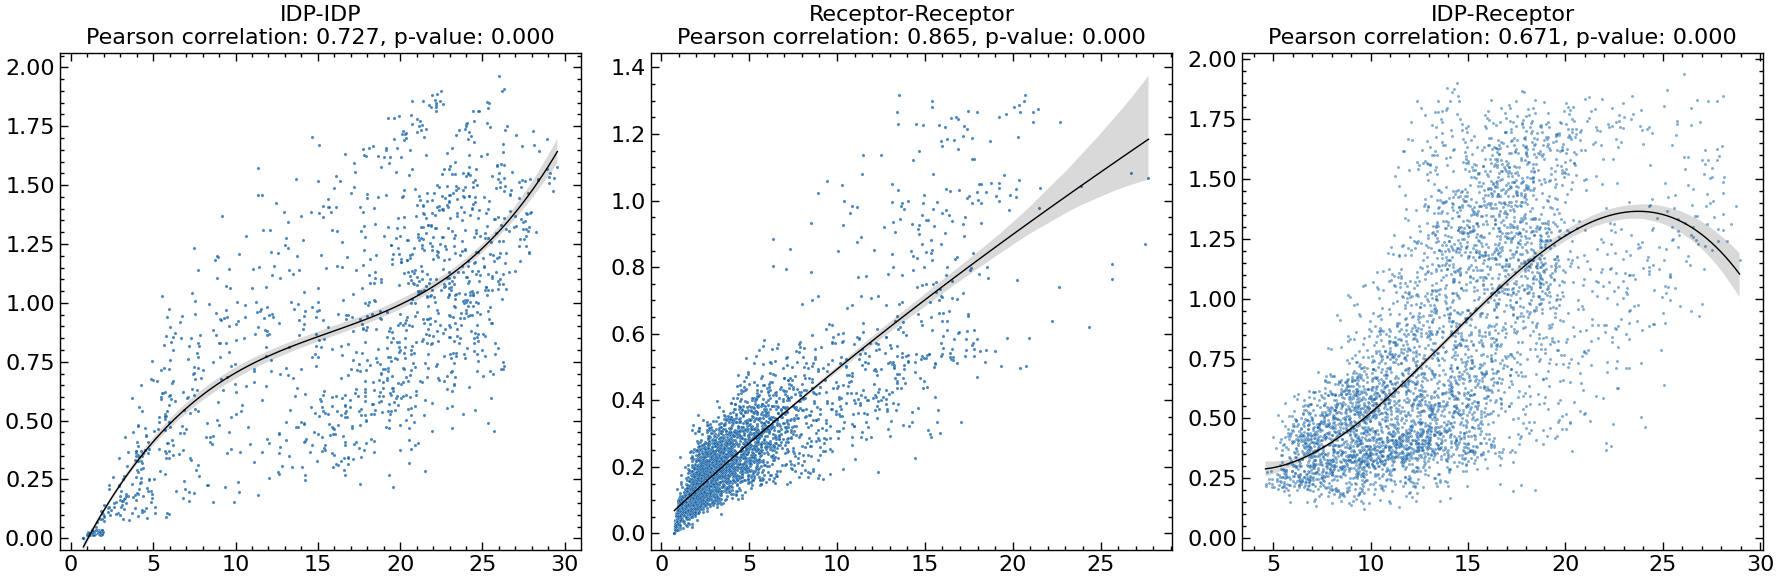

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.subplot(1, 3, 1)
x = np.ravel((pae_idp_idp + pae_idp_idp.T) / 2)
y = np.log1p(idp_dv).ravel()
# y = np.log1p(idp_dv).ravel()
sns.scatterplot(x=x, y=y, alpha=0.5, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-IDP\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.subplot(1, 3, 2)
x = np.ravel((pae_receptor_receptor + pae_receptor_receptor.T) / 2)
# y = np.log1p(np.log1p(receptor_dv)).ravel()
y = np.log1p(receptor_dv).ravel()
sns.scatterplot(x=x, y=y, alpha=0.5, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'Receptor-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.subplot(1, 3, 3)
alpha = 0.5
x = np.ravel(alpha * pae_idp_receptor + (1-alpha) * pae_receptor_idp.T)
# y = np.ravel(np.log1p(np.log1p(idp_receptor_dv)))
y = np.ravel(np.log1p(idp_receptor_dv))
# y = np.ravel(idp_receptor_dv)
sns.scatterplot(x=x, y=y, alpha=0.5, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.tight_layout()

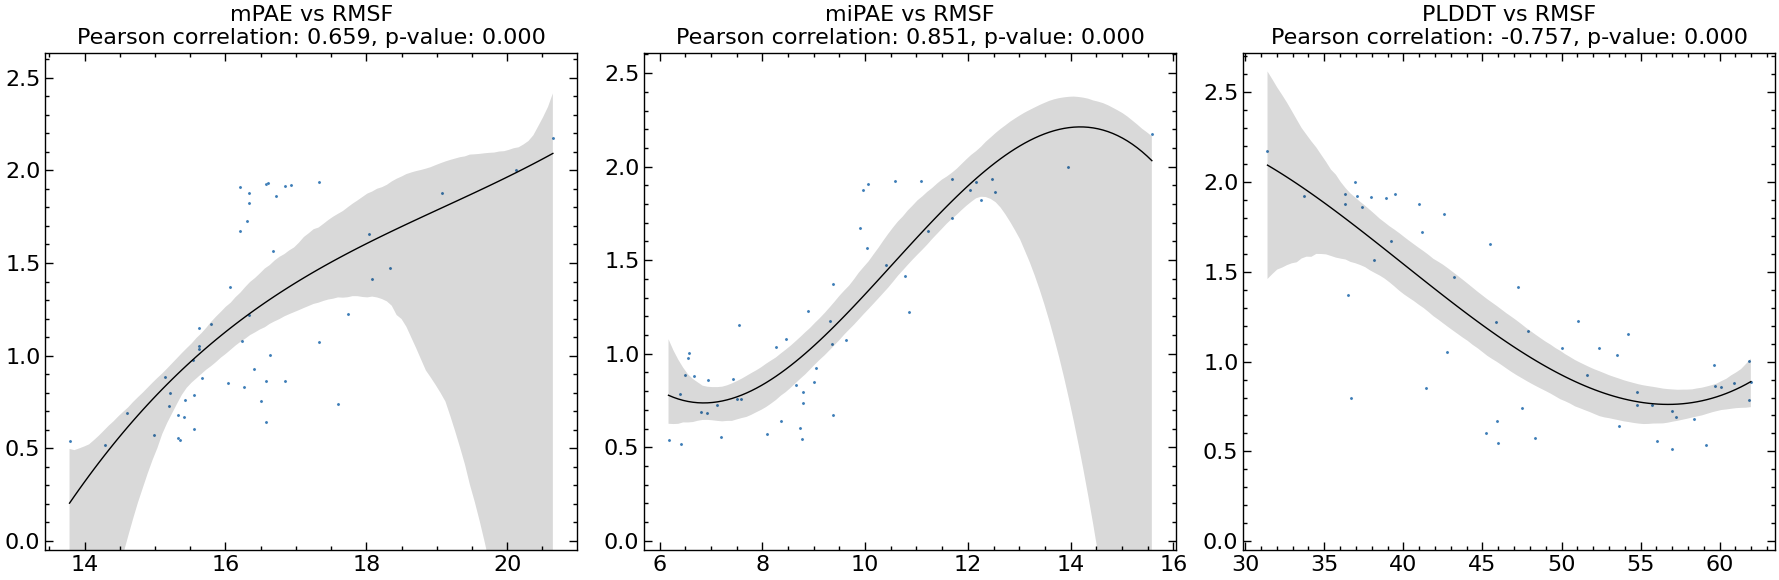

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plt.subplot(1, 3, 1)
x = df['pae_idp_idp_mean'].loc[idx][idp_ids-1]
y = np.log1p(df['idp_rmsf'].loc[idx])
sns.scatterplot(x=x, y=y, alpha=0.8, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'mPAE vs RMSF\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.subplot(1, 3, 2)
x = df['pae_receptor_idp_mean'].loc[idx][idp_ids-1]
sns.scatterplot(x=x, y=y, alpha=0.8, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'miPAE vs RMSF\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.subplot(1, 3, 3)
x = df['plddt_idp'].loc[idx][idp_ids-1]
sns.scatterplot(x=x, y=y, alpha=0.8, s=5)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'PLDDT vs RMSF\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

plt.tight_layout()

In [49]:
# n = 9155
# sample = df_1d_idp.sample(n).reset_index(drop=True)
# x = sample['pae_idp_idp_mean'].astype(float)
# y = sample['idp_rmsf'].astype(float)
# sns.scatterplot(x=x, y=y, data=sample, alpha=0.5, s=5)
# # sns.regplot(x=x, y=y, scatter=False, color='r', line_kws={'linewidth': 1})
# # sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
# correlation, p_value = stats.pearsonr(x, y)
# plt.title(f'IDP-IDP\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
# plt.ylim(-1, 33)
# plt.xlim(-1, 33)

In [50]:
# n = 9155
# sample = df_1d_idp.sample(n).reset_index(drop=True)
# x = sample['pae_idp_idp_mean'].astype(float)
# y = sample['idp_rmsf'].astype(float).apply(lambda x: np.log1p(x))
# sns.scatterplot(x=x, y=y, data=sample, alpha=0.5, s=5)
# sns.regplot(x=x, y=y, scatter=False, color='r', line_kws={'linewidth': 1}, order=1)
# # sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
# correlation, p_value = stats.pearsonr(x, y)
# plt.title(f'IDP-IDP\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
# # plt.ylim(-1, 33)
# plt.xlim(-1, 33)

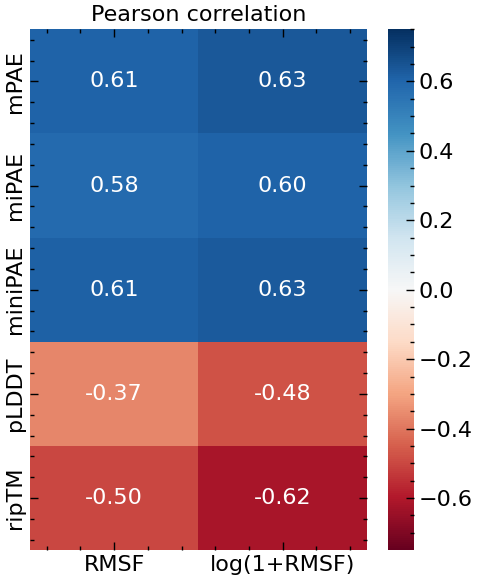

In [51]:
fig, ax = plt.subplots(figsize=(5, 6))
corr_1d = df_1d_idp[['idp_rmsf', 'idp_rmsf_log', 'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'pae_receptor_idp_min', 'plddt_idp', 'riptm_idp']].corr()
corr_1d = corr_1d.loc[['idp_rmsf', 'idp_rmsf_log'], ['pae_idp_idp_mean', 'pae_receptor_idp_mean', 'pae_receptor_idp_min', 'plddt_idp', 'riptm_idp']].T
g = sns.heatmap(corr_1d, cmap='RdBu', annot_kws={'fontsize': 16}, fmt='.2f', center=0, ax=ax, vmax=0.75, vmin=-0.75,
                annot=corr_1d.applymap(lambda x: x),)
g.set_yticklabels(['mPAE', 'miPAE', 'miniPAE', 'pLDDT', 'ripTM'], rotation=90)
g.set_xticklabels(['RMSF', 'log(1+RMSF)'], rotation=0)
g.set_title('Pearson correlation', fontsize=16)
plt.tight_layout()
# fig.savefig('../figures/rmsf_correlation.pdf', bbox_inches='tight')

In [52]:
df_1d_idp[['idp_rmsf', 'idp_rmsf_log', 'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'pae_receptor_idp_min', 'plddt_idp', 'riptm_idp']].corr()

,idp_rmsf,idp_rmsf_log,pae_idp_idp_mean,pae_receptor_idp_mean,pae_receptor_idp_min,plddt_idp,riptm_idp
idp_rmsf,1.000000,0.935149,0.609197,0.583418,0.611206,-0.367937,-0.501806
idp_rmsf_log,0.935149,1.000000,0.634328,0.604288,0.632009,-0.480199,-0.619110
pae_idp_idp_mean,0.609197,0.634328,1.000000,0.653298,0.619743,-0.450131,-0.522223
pae_receptor_idp_mean,0.583418,0.604288,0.653298,1.000000,0.964221,-0.489883,-0.622118
pae_receptor_idp_min,0.611206,0.632009,0.619743,0.964221,1.000000,-0.500380,-0.629166
plddt_idp,-0.367937,-0.480199,-0.450131,-0.489883,-0.500380,1.000000,0.865944
riptm_idp,-0.501806,-0.619110,-0.522223,-0.622118,-0.629166,0.865944,1.000000


In [53]:
df_2d_idp = df_1d.explode(['dv_idp', 'pae_idp']).reset_index(drop=True)
df_2d_idp.shape

(54539, 28)

In [54]:
cols = ['dv_idp', 'pae_idp']
for col in cols:
    df_2d_idp.loc[:, col] = df_2d_idp[col].astype(float)
df_2d_idp[cols].corr()

/tmp/ipykernel_667832/2945731830.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_2d_idp.loc[:, col] = df_2d_idp[col].astype(float)


,dv_idp,pae_idp
dv_idp,1.000000,0.744172
pae_idp,0.744172,1.000000


In [55]:
df_2d_idp['dv_idp_log'] = df_2d_idp['dv_idp'].apply(lambda x: np.log1p(x))
df_2d_idp['dv_idp_log_log'] = df_2d_idp['dv_idp'].apply(lambda x: np.log1p(np.log1p(x)))

In [56]:
df_2d_idp['dv_idp_log'].describe()

count    54539.000000
mean         0.997240
std          0.809266
min          0.000000
25%          0.285997
50%          0.832963
75%          1.552045
max          3.344548
Name: dv_idp_log, dtype: float64

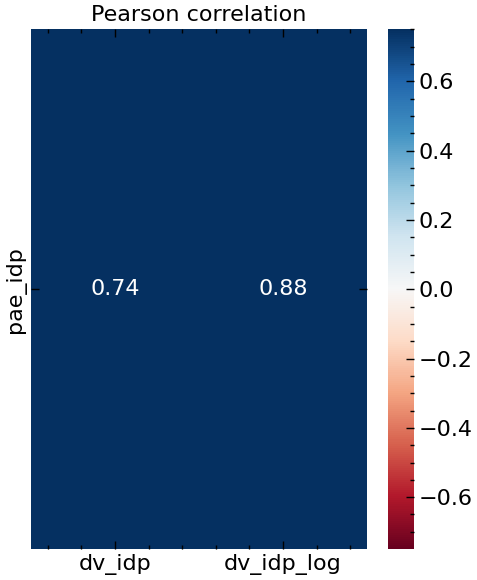

In [57]:
fig, ax = plt.subplots(figsize=(5, 6))
corr_2d = df_2d_idp[['dv_idp', 'dv_idp_log', 'dv_idp_log_log', 'pae_idp']].corr()
corr_2d = corr_2d.loc[['dv_idp', 'dv_idp_log'], ['pae_idp']].T
g = sns.heatmap(corr_2d, cmap='RdBu', annot_kws={'fontsize': 16}, fmt='.2f', center=0, ax=ax, vmax=0.75, vmin=-0.75,
                annot=corr_2d.applymap(lambda x: x),)
# g.set_yticklabels(['mPAE', 'miPAE', 'pLDDT'], rotation=90)
# g.set_xticklabels(['RMSF', 'log(1+RMSF)'], rotation=0)
g.set_title('Pearson correlation', fontsize=16)
plt.tight_layout()
# fig.savefig('../figures/rmsf_correlation.pdf', bbox_inches='tight')

In [58]:
corr_1d

,idp_rmsf,idp_rmsf_log
pae_idp_idp_mean,0.609197,0.634328
pae_receptor_idp_mean,0.583418,0.604288
pae_receptor_idp_min,0.611206,0.632009
plddt_idp,-0.367937,-0.480199
riptm_idp,-0.501806,-0.619110


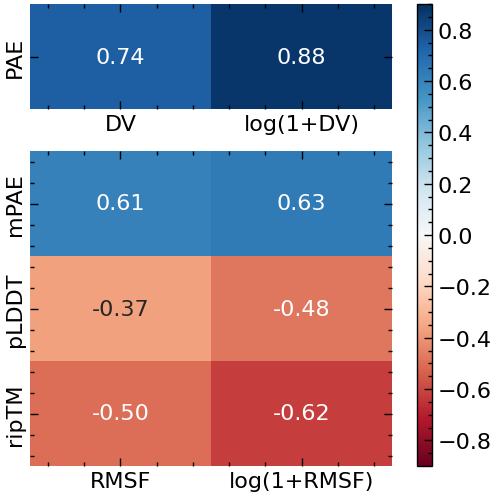

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [1, 3]})

# First heatmap
g1 = sns.heatmap(corr_1d.drop(['pae_receptor_idp_mean', 'pae_receptor_idp_min'], axis=0),
                 cmap='RdBu', annot=True, fmt='.2f', center=0, 
                 vmax=0.9, vmin=-0.9, ax=ax[1], cbar=False, annot_kws={'fontsize': 16})
g1.set_xticklabels(['RMSF', 'log(1+RMSF)'], rotation=0)
g1.set_yticklabels(['mPAE', 'pLDDT', 'ripTM'], rotation=90)

# Second heatmap
g2 = sns.heatmap(corr_2d, cmap='RdBu', annot=True, fmt='.2f', center=0, 
                 vmax=0.9, vmin=-0.9, ax=ax[0], cbar=False, annot_kws={'fontsize': 16})
g2.set_xticklabels(['DV', 'log(1+DV)'])
g2.set_yticklabels(['PAE'], rotation=90)

# Adding a colorbar to the right of the heatmaps
cbar_ax = fig.add_axes([0.9, 0.11, 0.03, 0.77])  # x, y, width, height
plt.colorbar(g1.collections[0], cax=cbar_ax)

plt.subplots_adjust(right=.85)  # Adjust the right space to prevent overlap with colorbar
fig.savefig('../figures/rmsf_dv_correlations.pdf', bbox_inches='tight')

In [70]:
df_1d_receptor = df_1d.explode(['riptm_receptor']).reset_index(drop=True)
print(df_1d_receptor.shape)
df_1d_receptor.head()

(4438, 28)


,pae_idp,dv_idp,pae_inter,dv_inter,pae_receptor,dv_receptor,idp_rmsf,receptor_rmsf,pae_idp_idp_mean,pae_receptor_idp_mean,...,idp_id,receptor_id,seed,exp,seed_rank,combined,dockq,capri,iptm,ptm
0,"[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...","[0.0, 0.004420892801135778, 0.4766846895217895...","[27.69, 28.33, 27.22, 26.23, 25.89, 25.25, 25....","[15.945747375488281, 15.239696502685547, 14.96...","[0.75, 1.585, 3.3200000000000003, 5.445, 6.68,...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[26.128358840942383, 25.147808074951172, 25.19...","[13.382383346557617, 12.740835189819336, 11.29...","[19.16441176470588, 17.779117647058825, 16.975...","[13.482098765432095, 12.597283950617282, 11.29...",...,B,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66
1,"[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...","[0.0, 0.004420892801135778, 0.4766846895217895...","[27.69, 28.33, 27.22, 26.23, 25.89, 25.25, 25....","[15.945747375488281, 15.239696502685547, 14.96...","[0.75, 1.585, 3.3200000000000003, 5.445, 6.68,...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[26.128358840942383, 25.147808074951172, 25.19...","[13.382383346557617, 12.740835189819336, 11.29...","[19.16441176470588, 17.779117647058825, 16.975...","[13.482098765432095, 12.597283950617282, 11.29...",...,B,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66
2,"[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...","[0.0, 0.004420892801135778, 0.4766846895217895...","[27.69, 28.33, 27.22, 26.23, 25.89, 25.25, 25....","[15.945747375488281, 15.239696502685547, 14.96...","[0.75, 1.585, 3.3200000000000003, 5.445, 6.68,...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[26.128358840942383, 25.147808074951172, 25.19...","[13.382383346557617, 12.740835189819336, 11.29...","[19.16441176470588, 17.779117647058825, 16.975...","[13.482098765432095, 12.597283950617282, 11.29...",...,B,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66
3,"[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...","[0.0, 0.004420892801135778, 0.4766846895217895...","[27.69, 28.33, 27.22, 26.23, 25.89, 25.25, 25....","[15.945747375488281, 15.239696502685547, 14.96...","[0.75, 1.585, 3.3200000000000003, 5.445, 6.68,...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[26.128358840942383, 25.147808074951172, 25.19...","[13.382383346557617, 12.740835189819336, 11.29...","[19.16441176470588, 17.779117647058825, 16.975...","[13.482098765432095, 12.597283950617282, 11.29...",...,B,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66
4,"[0.76, 1.595, 3.67, 5.925000000000001, 8.175, ...","[0.0, 0.004420892801135778, 0.4766846895217895...","[27.69, 28.33, 27.22, 26.23, 25.89, 25.25, 25....","[15.945747375488281, 15.239696502685547, 14.96...","[0.75, 1.585, 3.3200000000000003, 5.445, 6.68,...","[0.0, 0.00769254844635725, 0.3701004981994629,...","[26.128358840942383, 25.147808074951172, 25.19...","[13.382383346557617, 12.740835189819336, 11.29...","[19.16441176470588, 17.779117647058825, 16.975...","[13.482098765432095, 12.597283950617282, 11.29...",...,B,A,0,delim_idp,1.0,0.468,0.406,Acceptable,0.42,0.66


(-0.05, 1.05)

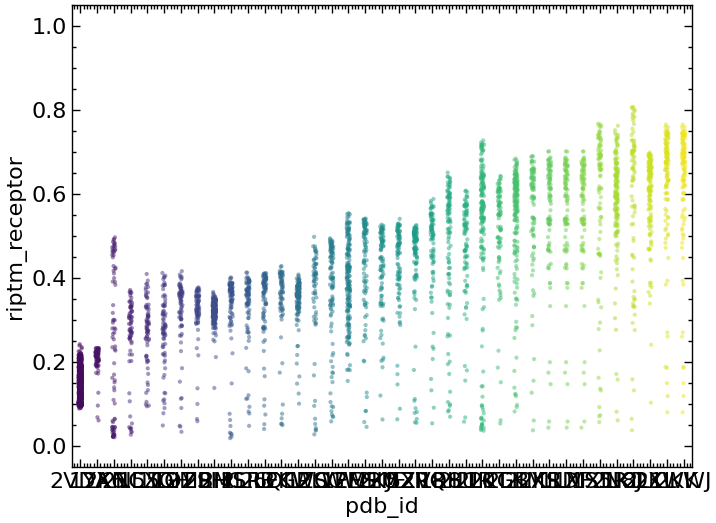

In [77]:
order = df_1d_receptor.groupby('pdb_id')['riptm_receptor'].mean().sort_values().index
g = sns.stripplot(
    data=df_1d_receptor,
    x='pdb_id',
    y='riptm_receptor',
    order=order,
    alpha=0.5,
    s=3,
    palette='viridis',
)
g.set_ylim(-0.05, 1.05)

<Axes: xlabel='pae_idp_idp_mean', ylabel='idp_rmsf_log'>

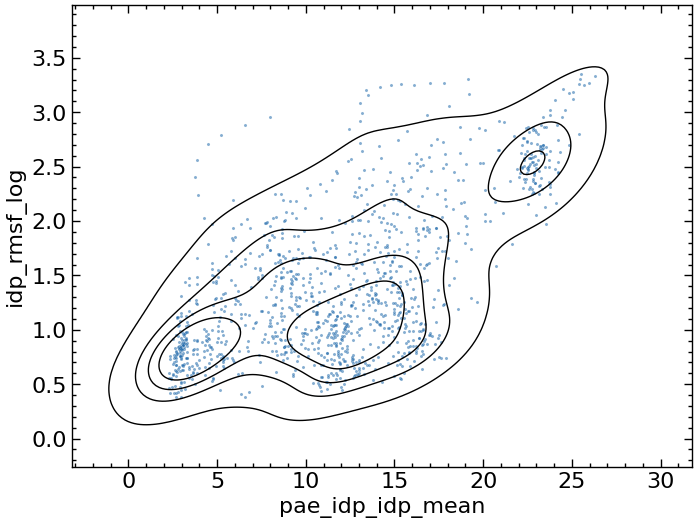

In [52]:
sns.scatterplot(x='pae_idp_idp_mean', y='idp_rmsf_log', data=df_1d_idp, alpha=0.5, s=5)
sns.kdeplot(x='pae_idp_idp_mean', y='idp_rmsf_log', data=df_1d_idp, levels=5, color='k', linewidths=1)

<Axes: xlabel='pae_idp', ylabel='dv_idp_log'>

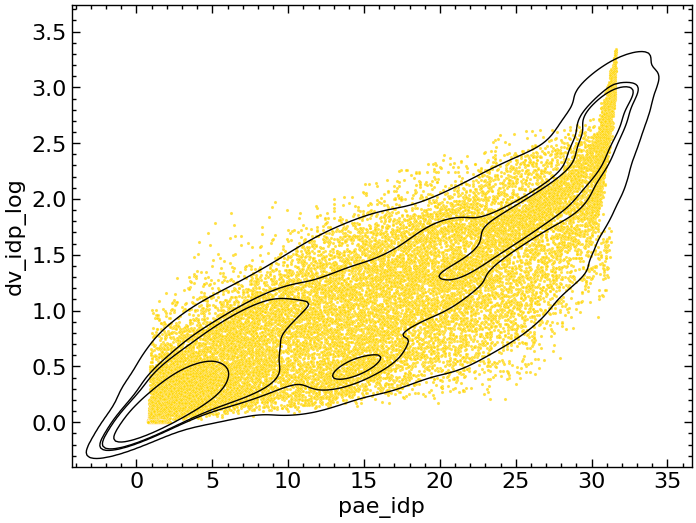

In [51]:
sns.scatterplot(
    data=df_2d_idp,
    x='pae_idp',
    y='dv_idp_log',
    alpha=0.5,
    s=5,
    color=FUZZY_DATASET_COLOR,
)
sns.kdeplot(
    data=df_2d_idp,
    x='pae_idp',
    y='dv_idp_log',
    levels=5,
    color='k',
    linewidths=1,
)

In [52]:
df_perg_2d = df_2d_idp[df_2d_idp['exp'] == 'delim_idp'].groupby(['pdb_id', 'idp_id', 'receptor_id', 'combined', 'dockq', 'capri', 'ptm', 'iptm']) \
    [['dv_idp', 'dv_idp_log', 'pae_idp']].corr().reset_index().rename(columns={'level_8': 'feature'})
df_perg_2d

,pdb_id,idp_id,receptor_id,combined,dockq,capri,ptm,iptm,feature,dv_idp,dv_idp_log,pae_idp
0,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,dv_idp,1.000000,0.957636,0.678958
1,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,dv_idp_log,0.957636,1.000000,0.729135
2,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,pae_idp,0.678958,0.729135,1.000000
3,1IDH,B,A,0.468,0.347,Acceptable,0.66,0.42,dv_idp,1.000000,0.977590,0.815169
4,1IDH,B,A,0.468,0.347,Acceptable,0.66,0.42,dv_idp_log,0.977590,1.000000,0.829312
...,...,...,...,...,...,...,...,...,...,...,...,...
103,5XV8,A,B,0.794,0.560,Acceptable,0.77,0.80,dv_idp_log,0.941377,1.000000,0.920067
104,5XV8,A,B,0.794,0.560,Acceptable,0.77,0.80,pae_idp,0.900551,0.920067,1.000000
105,6FGP,A,B,0.578,0.091,Incorrect,0.69,0.55,dv_idp,1.000000,0.963583,0.764553
106,6FGP,A,B,0.578,0.091,Incorrect,0.69,0.55,dv_idp_log,0.963583,1.000000,0.819906


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Incorrect vs. Acceptable: Mann-Whitney-Wilcoxon test two-sided, P_val:5.989e-02 U_stat=5.300e+01
Medium vs. High: Mann-Whitney-Wilcoxon test two-sided, P_val:2.500e-01 U_stat=7.000e+00
Acceptable vs. Medium: Mann-Whitney-Wilcoxon test two-sided, P_val:8.042e-01 U_stat=6.400e+01
Incorrect vs. Medium: Mann-Whitney-Wilcoxon test two-sided, P_val:3.749e-01 U_stat=2.800e+01
Acceptable vs. High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.111e-01 U_stat=1.700e+01
Incorrect vs. High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.667e-01 U_stat=1.100e+01


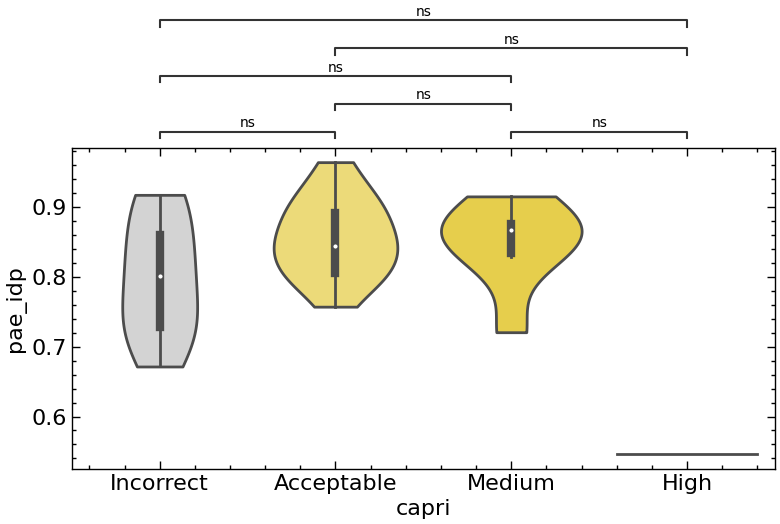

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
df_tmp = df_perg_2d[df_perg_2d['feature'] == 'dv_idp_log']
sns.violinplot(
    data=df_tmp,
    x='capri',
    y='pae_idp',
    order=CAPRI_CLASSES,
    palette=CAPRI_COLORS_FUZZY,
    ax=ax,
    cut=0,
)

pairs = [
    ('Incorrect', 'Acceptable'),
    ('Medium', 'High'),
    ('Incorrect', 'Medium'),
    ('Incorrect', 'High'),
    ('Acceptable', 'Medium'),
    ('Acceptable', 'High'),
]

annotator = Annotator(data=df_tmp, pairs=pairs, x='capri', y='pae_idp', verbose=1, ax=ax, order=CAPRI_CLASSES)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()

plt.tight_layout()

In [54]:
df_perg = df_1d_idp[df_1d_idp['exp'] == 'delim_idp'].groupby(['pdb_id', 'idp_id', 'receptor_id', 'combined', 'dockq', 'capri', 'ptm', 'iptm']) \
    [['idp_rmsf', 'pae_idp_idp_mean', 'pae_receptor_idp_mean', 'plddt_idp', 'pae_idp_mean']].corr().reset_index().rename(columns={'level_8': 'feature'})
df_perg

,pdb_id,idp_id,receptor_id,combined,dockq,capri,ptm,iptm,feature,idp_rmsf,pae_idp_idp_mean,pae_receptor_idp_mean,plddt_idp,pae_idp_mean
0,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,idp_rmsf,1.000000,0.466766,0.617600,-0.541766,0.657877
1,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,pae_idp_idp_mean,0.466766,1.000000,0.327708,-0.344664,0.492394
2,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,pae_receptor_idp_mean,0.617600,0.327708,1.000000,-0.925495,0.983671
3,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,plddt_idp,-0.541766,-0.344664,-0.925495,1.000000,-0.918263
4,1EES,B,A,0.600,0.156,Incorrect,0.76,0.56,pae_idp_mean,0.657877,0.492394,0.983671,-0.918263,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,6FGP,A,B,0.578,0.091,Incorrect,0.69,0.55,idp_rmsf,1.000000,0.902716,0.086676,0.012385,0.238750
176,6FGP,A,B,0.578,0.091,Incorrect,0.69,0.55,pae_idp_idp_mean,0.902716,1.000000,0.027100,0.181255,0.195880
177,6FGP,A,B,0.578,0.091,Incorrect,0.69,0.55,pae_receptor_idp_mean,0.086676,0.027100,1.000000,-0.915484,0.985538
178,6FGP,A,B,0.578,0.091,Incorrect,0.69,0.55,plddt_idp,0.012385,0.181255,-0.915484,1.000000,-0.868999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'RMSF vs mPAE')

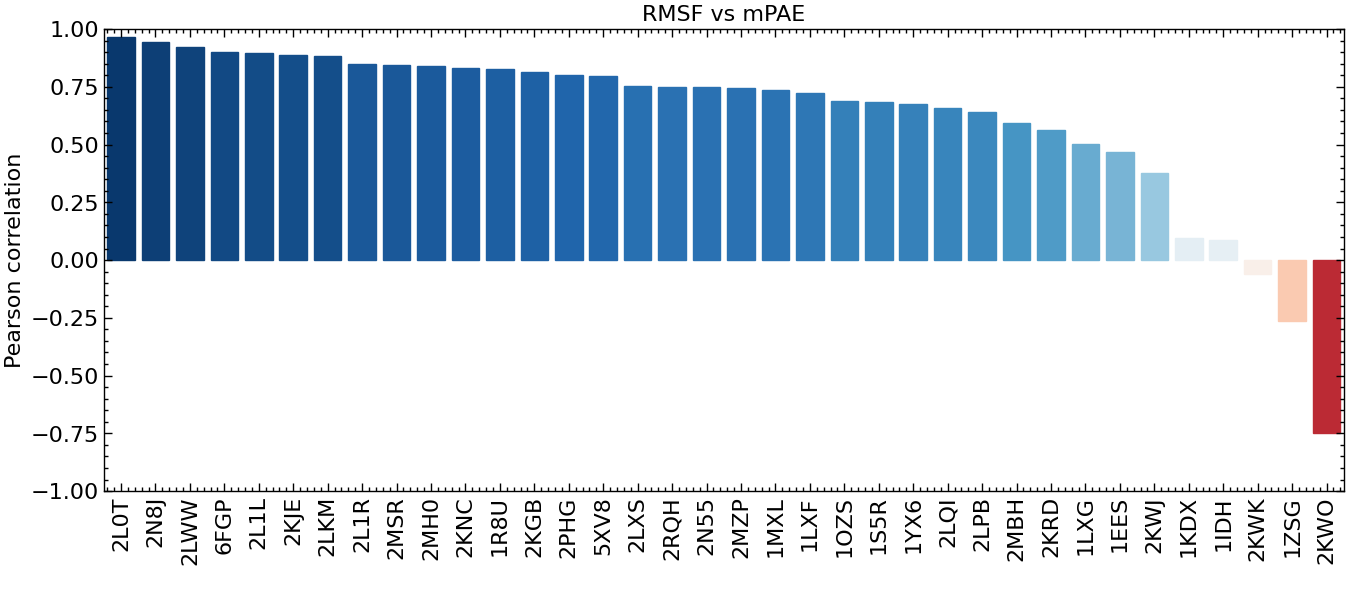

In [56]:
fig, ax = plt.subplots(figsize=(16, 6))
df_tmp = df_perg[(df_perg['feature'] == 'idp_rmsf')]# & (df_perg['exp'] == 'delim_idp')]
df_tmp = df_tmp.sort_values('pae_idp_idp_mean', ascending=False)
g = sns.barplot(data=df_tmp, x='pdb_id', y='pae_idp_idp_mean', ax=ax)
widths = df_tmp['pae_idp_idp_mean'].values
divnorm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
pal = plt.cm.RdBu(divnorm(widths))
for i, bar in enumerate(g.patches):
    bar.set_color(pal[i])
g.legend().remove()
# g.axhline(np.mean(widths), ls='--', color='k')
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.set_ylabel('Pearson correlation')
g.set_xlabel(' ')
g.set_ylim(-1, 1)
g.set_title('RMSF vs mPAE', fontsize=16)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'RMSF vs mPAE')

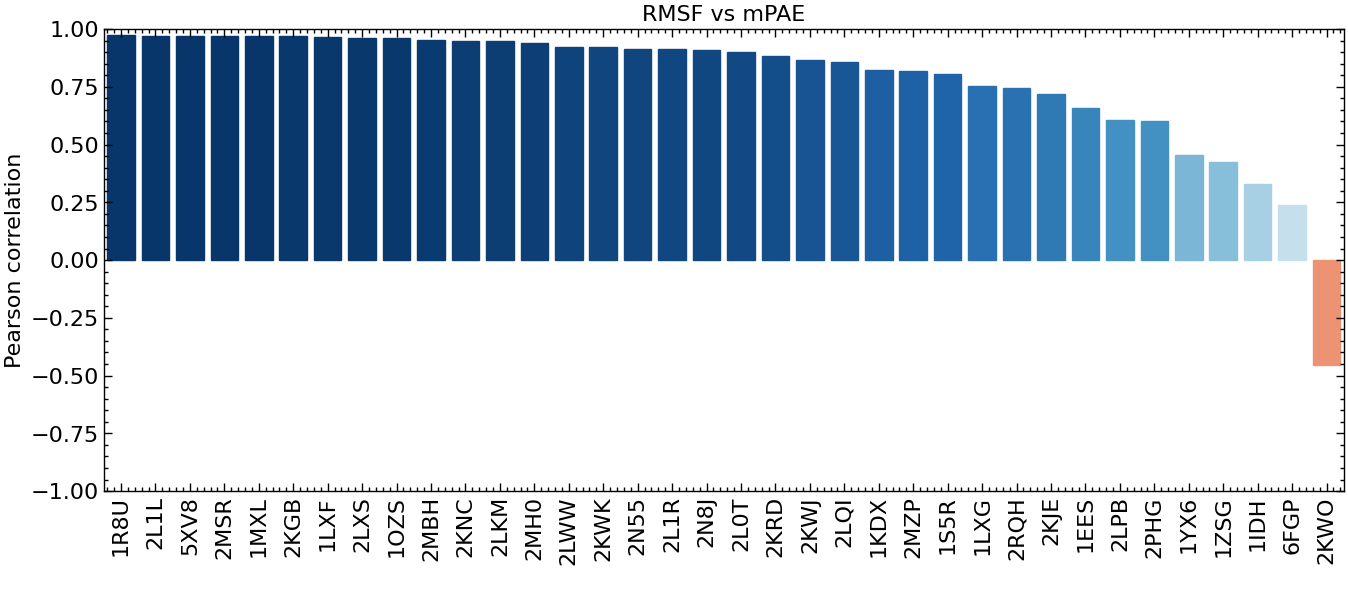

In [57]:
fig, ax = plt.subplots(figsize=(16, 6))
df_tmp = df_perg[(df_perg['feature'] == 'idp_rmsf')]# & (df_perg['exp'] == 'delim_idp')]
df_tmp = df_tmp.sort_values('pae_idp_mean', ascending=False)
g = sns.barplot(data=df_tmp, x='pdb_id', y='pae_idp_mean', ax=ax)
widths = df_tmp['pae_idp_mean'].values
divnorm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
pal = plt.cm.RdBu(divnorm(widths))
for i, bar in enumerate(g.patches):
    bar.set_color(pal[i])
g.legend().remove()
# g.axhline(np.mean(widths), ls='--', color='k')
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.set_ylabel('Pearson correlation')
g.set_xlabel(' ')
g.set_ylim(-1, 1)
g.set_title('RMSF vs mPAE', fontsize=16)

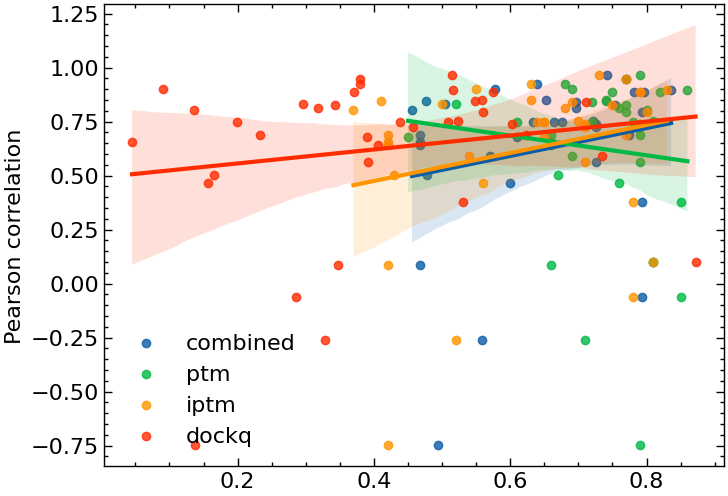

In [62]:
fig, ax = plt.subplots()
df_tmp = df_perg[(df_perg['feature'] == 'idp_rmsf')]# & (df_perg['exp'] == 'delim_idp')]
sns.regplot(data=df_tmp, x='combined', y='pae_idp_idp_mean', ax=ax, label='combined')
sns.regplot(data=df_tmp, x='ptm', y='pae_idp_idp_mean', ax=ax, label='ptm')
sns.regplot(data=df_tmp, x='iptm', y='pae_idp_idp_mean', ax=ax, label='iptm')
sns.regplot(data=df_tmp, x='dockq', y='pae_idp_idp_mean', ax=ax, label='dockq')
plt.xlabel('')
plt.ylabel('Pearson correlation')
plt.legend()

In [ ]:
df_idp = df_1d.explode(['pae_idp', 'dv_idp']).reset_index()
df_idp.shape

In [ ]:
n = 10000
sample = df_idp.sample(n).reset_index(drop=True)
x = sample['pae_idp'].astype(float)
# y = sample['dv_idp'].apply(lambda a: np.log1p(np.log1p(a))).astype(float)
y = sample['dv_idp'].astype(float)
sns.scatterplot(x=x, y=y, data=df_idp, alpha=0.2, s=5)
sns.regplot(x=x, y=y, scatter=False, color='r', line_kws={'linewidth': 1})
sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-IDP\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-1, 33)
plt.xlim(-1, 33)

In [ ]:
sample['dv_idp'].max()

In [ ]:
sns.kdeplot(x=x, color='black', cut=0)
sns.kdeplot(x=sample['dv_idp'].astype(float)*3.5, color='blue', cut=0)
# sns.kdeplot(x=sample['dv_idp'].apply(lambda a: a ** 2).astype(float), color='red')
# sns.kdeplot(x=sample['dv_idp'].apply(lambda a: np.log1p(a)).astype(float), color='red')
# sns.kdeplot(x=sample['dv_idp'].apply(lambda a: np.log1p(np.log1p(a))).astype(float), color='green')

In [ ]:
# order = ['High', 'Medium', 'Low']
order = ['High', 'Low']
y_bin = pd.qcut(y, 2, labels=order[::-1])
g = sns.boxplot(x=x, y=y_bin, order=order, palette='Oranges_r', fliersize=0, width=0.5)

pairs = [
    # ['Low', 'Medium'],
    # ['Medium', 'High'],
    ['Low', 'High']
    # ['0', '1'],
    # ['0', '2'],
    # ['0', '3'],
    # ['0', '4'],
    # ['1', '2'],
    # ['1', '3'],
    # ['1', '4'],
    # ['2', '3'],
    # ['2', '4'],
    # ['3', '4'],
]

annotator = Annotator(g, pairs, x=x, y=y_bin, orient='h', order=order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', verbose=2, loc='outside')
annotator.apply_and_annotate()

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

In [ ]:
df_receptor = df_1d.explode(['pae_receptor', 'dv_receptor'])
df_receptor.shape

In [ ]:
x = df_receptor['pae_receptor']
# y = df_receptor['dv_receptor'].apply(lambda1x: np.log1p(np.log1p(x)))
y = df_receptor['dv_receptor']
sns.scatterplot(x=x, y=y, data=df_receptor, alpha=0.05, s=1)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'Receptor-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)

In [ ]:
df_inter = df_1d.explode(['pae_inter', 'dv_inter'])
df_inter.shape

In [ ]:
sample['dv_inter'].apply(lambda a: np.log1p(np.log1p(a))).describe()

In [ ]:
sample['dv_inter'].astype(float).describe()

In [ ]:
n = 10000
sample = df_inter.sample(n, replace=False).reset_index(drop=True)
x = sample['pae_inter'].astype(float)
# y = sample['dv_inter'].apply(lambda a: np.log1p(np.log1p(a))).astype(float)
y = sample['dv_inter'].astype(float)
sns.scatterplot(x=x, y=y, data=df_inter, alpha=0.1, s=5)
# sns.regplot(x=x, y=y, scatter=False, color='k', line_kws={'linewidth': 1}, order=3)
# sns.kdeplot(x=x, y=y, levels=5, color='k', linewidths=1)
correlation, p_value = stats.pearsonr(x, y)
plt.title(f'IDP-Receptor\nPearson correlation: {correlation:.3f}, p-value: {p_value:.3f}')
plt.ylim(-0.05, None)
plt.xlim(-0.05, 32)

In [ ]:
order = ['High', 'Medium', 'Low']
# order = ['0', '1', '2', '3', '4']
y_bin = pd.qcut(y, 3, labels=order[::-1])
g = sns.boxplot(x=x, y=y_bin, data=df_inter, order=order, palette='Oranges_r')

pairs = [
    ['Low', 'Medium'],
    ['Medium', 'High'],
    ['Low', 'High']
    # ['0', '1'],
    # ['0', '2'],
    # ['0', '3'],
    # ['0', '4'],
    # ['1', '2'],
    # ['1', '3'],
    # ['1', '4'],
    # ['2', '3'],
    # ['2', '4'],
    # ['3', '4'],
]

annotator = Annotator(g, pairs, x=x, y=y_bin, orient='h', order=order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', verbose=2, loc='outside')
annotator.apply_and_annotate()

# g.set_ylabel('')
# g.set_xlabel('Combined score')
# g.set_yticklabels([])
# g.axvline(0.6, ls='--', color='k', lw=0.7, alpha=0.5)
# 2d box legends
# plt.legend(
#     handles=[Patch(facecolor=CAPRI_COLORS[CAPRI_CLASSES.index(c)], label=c) for c in CAPRI_CLASSES[::-1]],
#     labels=CAPRI_CLASSES[::-1], loc='upper left', title='CAPRI', ncol=1
# )

plt.tight_layout()

In [ ]:
n = 5000
sns.kdeplot(x=df_idp.sample(n).reset_index()['pae_idp'], fill=True, alpha=0.5, cut=0)
sns.kdeplot(x=df_inter.sample(n).reset_index()['pae_inter'], fill=True, alpha=0.5, cut=0)
sns.kdeplot(data=df_receptor.sample(n).reset_index(), x='pae_receptor', fill=True, alpha=0.5, cut=0)
plt.legend(['IDP-IDP', 'IDP-Receptor', 'Receptor-Receptor'])

In [ ]:
sns.displot(df_idp, x='dv_idp', kind='kde', fill=True, alpha=0.5)
sns.displot(df_inter, x='dv_inter', kind='kde', fill=True, alpha=0.5)
sns.displot(df_receptor, x='dv_receptor', kind='kde', fill=True, alpha=0.5)

In [ ]:
def parse_residue_range(row, key='idp_iface', plddt_key='plddt_idp', uniprot_key=None, delim=':'):
    try:
        iface = row[key].split(delim)
        iface = [list(map(int, i.split('-'))) for i in iface]
        if uniprot_key is not None:
            _, pdb_start, length, uniprot_start = row[uniprot_key].split(';')[0].split(':')
            pdb_start, length, uniprot_start = int(pdb_start), int(length), int(uniprot_start)
            iface = [list(range(i[0]-pdb_start+uniprot_start-1, i[1]-pdb_start+uniprot_start)) for i in iface]
        else:
            iface = [list(range(i[0]-1, i[1])) for i in iface]
        iface = sum(iface, [])
        iface_arr = np.zeros(len(row[plddt_key]), dtype=int)
        iface_arr[iface] = 1
        return iface_arr
    except Exception as e:
        print(row['pdb_id'], key, plddt_key, uniprot_key, '\t', e)
        print()
        return np.zeros(len(row[plddt_key]), dtype=int)

df.loc[df['exp'] == 'delim_idp', 'idp_fuzzy'] = df[df['exp'] == 'delim_idp'].apply(
    parse_residue_range, key='idp_fuzzy_residues', plddt_key='plddt_idp', delim='_', axis=1)
df.loc[df['exp'] == 'full_idp', 'idp_fuzzy'] = df[df['exp'] == 'full_idp'].apply(
    parse_residue_range, key='fuzzy_regions', plddt_key='plddt_idp', delim='_', axis=1)

mask = (df['exp'] == 'uniprot') & (df['exp_chain'] == 'idp')
df.loc[mask, 'idp_fuzzy'] = df[mask].apply(
    parse_residue_range, key='fuzzy_regions', plddt_key='plddt', delim='_', axis=1)

df.loc[df['exp'] == 'delim_idp', 'idp_iface'] = df[df['exp'] == 'delim_idp'].apply(
    parse_residue_range, key='idp_iface_true', plddt_key='plddt_idp', axis=1)
df.loc[df['exp'] == 'full_idp', 'idp_iface'] = df[df['exp'] == 'full_idp'].apply(
    parse_residue_range, key='idp_iface_true', plddt_key='plddt_idp', uniprot_key='idp_uniprot', axis=1)

In [ ]:
df_tmp = df[df['exp'] == 'delim_idp']
df_tmp = df_tmp[df_tmp.apply(lambda x: len(x['pae_idp_idp_mean']) == len(x['idp_dv_mean']), axis=1)]
df_tmp.shape

In [ ]:
df_residues = df_tmp.explode(['pae_idp_idp_mean', 'idp_dv_mean', 'idp_receptor_dv_mean', 'pae_idp_receptor_mean',
                              'idp_fuzzy'])
df_residues['residue'] = df_residues.groupby(['pdb_id', 'idp_id', 'receptor_id', 'rank',
                                              'model_name', 'model', 'seed', 'exp']).cumcount() + 1
print(df_residues.shape)
df_residues.head()

In [ ]:
df_residues = pd.merge(df_residues, df_fuzpred, left_on=['pdb_id', 'idp_id', 'receptor_id', 'residue'],
         right_on=['pdb_id', 'idp_id', 'receptor_id', 'position'])
print(df_residues.shape)
df_residues.head()

In [ ]:
fg = sns.FacetGrid(df_residues[df_residues['rank'] == 1], col='pdb_id',
                   col_wrap=3, sharex=False, sharey=False)
fg.map_dataframe(sns.lineplot, x='residue', y='idp_dv_mean', label='DV', color='cyan')
fg.map_dataframe(sns.lineplot, x='residue', y='idp_receptor_dv_mean', label='iDV', color='blue')
fg.map_dataframe(sns.lineplot, x='residue', y='pae_idp_idp_mean', label='PAE', color='orange')
fg.map_dataframe(sns.lineplot, x='residue', y='pae_idp_receptor_mean', label='iPAE', color='red')
fg.map_dataframe(sns.lineplot, x='residue', y='idp_fuzzy', color='purple')
# legend
handles, labels = fg.axes[0].get_legend_handles_labels()
fg.fig.legend(handles, labels, loc='lower center', ncol=4)

In [ ]:
# correlation
df_residues[['idp_dv_mean', 'idp_receptor_dv_mean', 'idp_fuzzy', 'pae_idp_idp_mean',
              'pae_idp_receptor_mean']].corr()

In [ ]:
df_full = df[df['exp'] == 'full_idp'].dropna(subset=['plddt_idp', 'idp_fuzzy', 'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'idp_iface'])
df_full = df_full.explode(['plddt_idp', 'pae_idp_idp_mean', 'pae_idp_receptor_mean', 'idp_fuzzy', 'idp_iface'])

# add residue number
df_full['residue'] = df_full.groupby(['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'exp']).cumcount() + 1
df_full = pd.merge(df_full, df_fuzpred, left_on=['pdb_id', 'idp_id', 'receptor_id', 'residue'],
            right_on=['pdb_id', 'idp_id', 'receptor_id', 'position'])
print(df_full.shape)
df_full.head()

In [ ]:
# ROC curve
df_full_rank1 = df_full[(df_full['seed_rank'] == 1) & (df_full['seed'] == 0)]
# df_full_rank1 = df_full[(df_full['rank'] == 1)]
fpr, tpr, thresh = roc_curve(df_full_rank1['idp_iface'].astype(int), df_full_rank1['plddt_idp'].astype(float))
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_iface'].astype(int), df_full_rank1['plddt_idp'].astype(float) > thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pLDDT (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

# fpr, tpr, thresh = roc_curve(df_full['idp_iface'].astype(int), df_full['idp_ifacepred'])
# roc_auc = auc(fpr, tpr)
# print(roc_auc)
# print(classification_report(df_full['idp_iface'].astype(int), df_full['idp_ifacepred'].astype(int)))
# sns.lineplot(x=fpr, y=tpr, label=f'Interface (AUC = {roc_auc:.2f})')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_iface'].astype(int), 32-df_full_rank1['pae_idp_receptor_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_iface'].astype(int), df_full_rank1['pae_idp_receptor_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'miPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[2])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_iface'].astype(int), 32-df_full_rank1['pae_idp_idp_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_iface'].astype(int), df_full_rank1['pae_idp_idp_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'mPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], ls='--', color='k', lw=1)
plt.tight_layout()


In [ ]:
# fuzzy
fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt_idp'].astype(float))
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt_idp'].astype(float) > thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pLDDT (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 32-df_full_rank1['pae_idp_receptor_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_receptor_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'miPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[2])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 32-df_full_rank1['pae_idp_idp_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'mPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDD (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 1-df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(1-thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDO (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], ls='--', color='k', lw=1)
plt.tight_layout()

In [ ]:
def plot_precision_recall_curve(y_true, y_score, label, color=sns.color_palette('Blues', 3)[0]):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_f1_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[max_f1_index]
    sns.lineplot(x=recall, y=precision, label=f'{label} (AP = {average_precision:.2f})', color=color)
    plt.plot(recall[max_f1_index], precision[max_f1_index], color='black', marker='o', markersize=2)
    return best_threshold, f1_scores[max_f1_index]

y_true = df_full_rank1['idp_iface'].astype(int)

best_threshold_pLDDT, best_f1_pLDDT = plot_precision_recall_curve(y_true, df_full_rank1['plddt_idp'].astype(float),
                                                                  'pLDDT', sns.color_palette('Blues', 3)[0])
best_threshold_mPAE, best_f1_mPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_idp_mean'],
                                                                'mPAE', sns.color_palette('Blues', 3)[1])
best_threshold_miPAE, best_f1_miPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_receptor_mean'],
                                                                  'miPAE', sns.color_palette('Blues', 3)[2])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

print("pLDDT:", best_threshold_pLDDT, best_f1_pLDDT)
print("mPAE:", best_threshold_mPAE, best_f1_mPAE)
print("miPAE:", best_threshold_miPAE, best_f1_miPAE)

In [ ]:
y_true = df_full_rank1['idp_fuzzy'].astype(int)

best_threshold_pLDDT, best_f1_pLDDT = plot_precision_recall_curve(y_true, df_full_rank1['plddt_idp'].astype(float),
                                                                  'pLDDT', sns.color_palette('Blues', 3)[0])
best_threshold_mPAE, best_f1_mPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_idp_mean'],
                                                                'mPAE', sns.color_palette('Blues', 3)[1])
best_threshold_miPAE, best_f1_miPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_idp_receptor_mean'],
                                                                  'miPAE', sns.color_palette('Blues', 3)[2])
best_threshold_pdd, best_f1_pdd = plot_precision_recall_curve(y_true, df_full_rank1['pDD'],
                                                                    'pDD', sns.color_palette('Oranges', 2)[0])
best_threshold_pdo, best_f1_pdo = plot_precision_recall_curve(y_true, 1-df_full_rank1['pDD'],
                                                                    'pDO', sns.color_palette('Oranges', 2)[1])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

print("pLDDT:", best_threshold_pLDDT, best_f1_pLDDT)
print("mPAE:", best_threshold_mPAE, best_f1_mPAE)
print("miPAE:", best_threshold_miPAE, best_f1_miPAE)
print("pDD:", best_threshold_pdd, best_f1_pdd)
print("pDO:", best_threshold_pdo, best_f1_pdo)

In [ ]:
df_full = df[(df['exp'] == 'uniprot') & (df['exp_chain'] == 'idp')].dropna(subset=['plddt', 'idp_fuzzy', 'pae_mean'])
df_full = df_full.explode(['plddt', 'pae_mean', 'idp_fuzzy'])

# add residue number
df_full['residue'] = df_full.groupby(['pdb_id', 'idp_id', 'receptor_id', 'rank', 'model_name', 'model', 'seed', 'exp']).cumcount() + 1
df_full = pd.merge(df_full, df_fuzpred, left_on=['pdb_id', 'idp_id', 'receptor_id', 'residue'],
            right_on=['pdb_id', 'idp_id', 'receptor_id', 'position'])
print(df_full.shape)
df_full.head()

In [ ]:
# ROC curve
df_full_rank1 = df_full[(df_full['seed_rank'] == 1) & (df_full['seed'] == 0)]
fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt'].astype(float))
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['plddt'].astype(float) > thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pLDDT (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 32-df_full_rank1['pae_mean'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(32 - thresh[youden], roc_auc)
print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_mean'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'mPAE (AUC = {roc_auc:.2f})', color=sns.color_palette('Blues', 3)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDD (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[0])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

fpr, tpr, thresh = roc_curve(df_full_rank1['idp_fuzzy'].astype(int), 1-df_full_rank1['pDD'])
roc_auc = auc(fpr, tpr)
youden = np.argmax(tpr - fpr)
print(1-thresh[youden], roc_auc)
# print(classification_report(df_full_rank1['idp_fuzzy'].astype(int), df_full_rank1['pae_idp_idp'] < 32-thresh[youden]))
sns.lineplot(x=fpr, y=tpr, label=f'pDO (AUC = {roc_auc:.2f})', color=sns.color_palette('Oranges', 2)[1])
plt.plot(fpr[youden], tpr[youden], marker='.', color='k')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], ls='--', color='k', lw=1)
plt.tight_layout()


In [ ]:
def plot_precision_recall_curve(y_true, y_score, label, color=sns.color_palette('Blues', 3)[0]):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_f1_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[max_f1_index]
    sns.lineplot(x=recall, y=precision, label=f'{label} (AP = {average_precision:.2f})', color=color)
    plt.plot(recall[max_f1_index], precision[max_f1_index], color='black', marker='o', markersize=2)
    return best_threshold, f1_scores[max_f1_index]

y_true = df_full_rank1['idp_fuzzy'].astype(int)

best_threshold_pLDDT, best_f1_pLDDT = plot_precision_recall_curve(y_true, df_full_rank1['plddt'].astype(float),
                                                                  'pLDDT', sns.color_palette('Blues', 3)[0])
best_threshold_mPAE, best_f1_mPAE = plot_precision_recall_curve(y_true, 32-df_full_rank1['pae_mean'],
                                                                'mPAE', sns.color_palette('Blues', 3)[1])
best_threshold_pdd, best_f1_pdd = plot_precision_recall_curve(y_true, df_full_rank1['pDD'],
                                                                    'pDD', sns.color_palette('Oranges', 2)[0])
best_threshold_pdo, best_f1_pdo = plot_precision_recall_curve(y_true, 1-df_full_rank1['pDD'],
                                                                    'pDO', sns.color_palette('Oranges', 2)[1])

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()

print("pLDDT:", best_threshold_pLDDT, best_f1_pLDDT)
print("mPAE:", best_threshold_mPAE, best_f1_mPAE)
print("pDD:", best_threshold_pdd, best_f1_pdd)
print("pDO:", best_threshold_pdo, best_f1_pdo)